In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset 
from delphi.oracle import Left, Interval
import datetime

In [ ]:
STORE_PATH = '/home/pstefanou/knownVsUnknown'
STORE_TABLE_NAME = 'rebuttal12'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

In [2]:
# regression parameters
num_samples, dims = 10000, 10
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))
var = 10.0

# perform each experiment a total of 10 times
for iter_ in range(1):        
#     for var in ra¿nge(1, 20):
    # generate data
    X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
    y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
    # truncate
    indices = phi(y).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = y[indices], X[indices]

    # empirical linear regression
    reg = LinearRegression() 
    reg.fit(x_trunc, y_trunc)
    emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

    # experiment parameters
    args = Parameters({ 
        'alpha': Tensor([y_trunc.size(0)/num_samples]), 
        'phi': phi, 
        'epochs': 10,
        'num_workers': 20, 
        'batch_size': 10,
        'bias': True,
        'num_samples': 100,
        'clamp': True, 
        'radius': 5.0, 
        'var_lr': 1e-2,
        'var': emp_var,
        'lr': 1e-1,
        'shuffle': True
    })


#         # truncated linear regression with known noise variance
#         # dataset 
#         data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
#         S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
#         trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, var=args.var, device='cuda')
#         results = trunc_reg.fit(S)
#         w_, w0_ = results.weight.detach(), results.bias.detach()

    # truncated linear regression with unknown noise variance
    # dataset 
    data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
    S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
    trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, device='cuda')
    results = trunc_reg.fit(S)
    var_ = results.lambda_.inverse().detach()
    w, w0 = results.v.detach()*var_, results.bias.detach()*var_

    # calculate metrics 
    real_params = ch.cat([W, W0])
    ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
    unknown_params = ch.cat([w, w0])
#     known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
    unknown_param_mse = mean_squared_error(unknown_params.cpu(), real_params)
    ols_param_mse = mean_squared_error(ols_params, real_params)
#     known_param_mse = mean_squared_error(known_params.cpu(), real_params)

#     store[STORE_TABLE_NAME].append_row({ 
#         'known_param_mse': known_param_mse,
#         'unknown_param_mse': unknown_param_mse,
#         'ols_param_mse': ols_param_mse,
#         'alpha': float(args.alpha.flatten()),
#         'var': float(var), 
#     })

# close current store
# store.close()

Epoch:1 | Score tensor([ 0.6341,  0.5502, -0.5825, -0.2718, -0.1705, -0.4668,  0.3899,  0.0756,
         0.5202, -0.4358, -0.6072,  9.2530], device='cuda:0') 
Epoch:1 | Score tensor([ 0.6341,  0.5502, -0.5825, -0.2718, -0.1705, -0.4668,  0.3899,  0.0756,
         0.5202, -0.4358, -0.6072,  9.2530], device='cuda:0') 
Epoch:1 | Score tensor([ 0.6341,  0.5502, -0.5825, -0.2718, -0.1705, -0.4668,  0.3899,  0.0756,
         0.5202, -0.4358, -0.6072,  9.2530], device='cuda:0') 
Epoch:1 | Score tensor([ 1.9605e-01,  3.2350e-01, -2.7600e-01,  1.2998e-01, -1.2010e-03,
        -2.3867e-01,  2.5437e-01,  1.4834e-01,  1.5238e-01, -1.3238e-01,
        -4.8676e-01,  5.5314e+00], device='cuda:0') 
Epoch:1 | Score tensor([ 1.9605e-01,  3.2350e-01, -2.7600e-01,  1.2998e-01, -1.2010e-03,
        -2.3867e-01,  2.5437e-01,  1.4834e-01,  1.5238e-01, -1.3238e-01,
        -4.8676e-01,  5.5314e+00], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0778,  0.2734, -0.1522,  0.1352, -0.0936, -0.0357,  0.0805, -0.006

Epoch:1 | Score tensor([-4.2196e-02, -2.8327e-02,  2.1446e-02, -9.1691e-02, -7.3001e-02,
        -1.6049e-01,  1.2333e-03,  1.8083e-02, -9.6636e-03, -6.4808e-02,
        -1.6675e-01,  1.6701e+00], device='cuda:0') 
Epoch:1 | Score tensor([-0.0468, -0.0373,  0.0156, -0.0804, -0.0700, -0.1515,  0.0115,  0.0281,
        -0.0089, -0.0559, -0.1587,  1.5516], device='cuda:0') 
Epoch:1 | Score tensor([-0.0468, -0.0373,  0.0156, -0.0804, -0.0700, -0.1515,  0.0115,  0.0281,                              
        -0.0089, -0.0559, -0.1587,  1.5516], device='cuda:0') 
Epoch:1 | Score tensor([-0.0564, -0.0194, -0.0120, -0.0782, -0.0668, -0.1412,  0.0221,  0.0285,
        -0.0104, -0.0459, -0.1402,  1.5182], device='cuda:0') 
Epoch:1 | Score tensor([-0.0564, -0.0194, -0.0120, -0.0782, -0.0668, -0.1412,  0.0221,  0.0285,
        -0.0104, -0.0459, -0.1402,  1.5182], device='cuda:0') 
Epoch:1 | Score tensor([-0.0614, -0.0131, -0.0175, -0.0807, -0.0666, -0.1260,  0.0247,  0.0264,
        -0.0157, -0.046

Epoch:1 | Score tensor([-0.0843, -0.0399,  0.0213, -0.0211, -0.0348, -0.0898,  0.0046, -0.0234,
        -0.0357, -0.0492, -0.0116,  0.9346], device='cuda:0') 
Epoch:1 | Score tensor([-0.0843, -0.0399,  0.0213, -0.0211, -0.0348, -0.0898,  0.0046, -0.0234,
        -0.0357, -0.0492, -0.0116,  0.9346], device='cuda:0') 
Epoch:1 | Score tensor([-0.0854, -0.0401,  0.0211, -0.0298, -0.0341, -0.0853,  0.0115, -0.0233,
        -0.0351, -0.0526, -0.0180,  0.9470], device='cuda:0') 
Epoch:1 | Score tensor([-0.0854, -0.0401,  0.0211, -0.0298, -0.0341, -0.0853,  0.0115, -0.0233,
        -0.0351, -0.0526, -0.0180,  0.9470], device='cuda:0') 
Epoch:1 | Score tensor([-0.0841, -0.0435,  0.0184, -0.0326, -0.0347, -0.0827,  0.0080, -0.0196,
        -0.0374, -0.0391, -0.0069,  0.8974], device='cuda:0') 
Epoch:1 | Score tensor([-0.0841, -0.0435,  0.0184, -0.0326, -0.0347, -0.0827,  0.0080, -0.0196,
        -0.0374, -0.0391, -0.0069,  0.8974], device='cuda:0') 
Epoch:1 | Score tensor([-0.0832, -0.0356,  0.0

Epoch:1 | Score tensor([-0.0851, -0.0112,  0.0165, -0.0270, -0.0297, -0.0434,  0.0032, -0.0446,
        -0.0025, -0.0174,  0.0873,  0.5637], device='cuda:0') 
Epoch:1 | Score tensor([-0.0847, -0.0049,  0.0146, -0.0312, -0.0276, -0.0442,  0.0016, -0.0455,
        -0.0023, -0.0171,  0.1046,  0.5075], device='cuda:0') 
Epoch:1 | Score tensor([-0.0847, -0.0049,  0.0146, -0.0312, -0.0276, -0.0442,  0.0016, -0.0455,
        -0.0023, -0.0171,  0.1046,  0.5075], device='cuda:0') 
Epoch:1 | Score tensor([-0.0849, -0.0106,  0.0128, -0.0304, -0.0253, -0.0396, -0.0052, -0.0409,
        -0.0040, -0.0217,  0.1171,  0.4269], device='cuda:0') 
Epoch:1 | Score tensor([-0.0849, -0.0106,  0.0128, -0.0304, -0.0253, -0.0396, -0.0052, -0.0409,
        -0.0040, -0.0217,  0.1171,  0.4269], device='cuda:0') 
Epoch:1 | Score tensor([-0.0886, -0.0069,  0.0116, -0.0306, -0.0273, -0.0350, -0.0056, -0.0507,
        -0.0066, -0.0295,  0.1198,  0.4323], device='cuda:0') 
Epoch:1 | Score tensor([-0.0886, -0.0069,  0.0

Epoch:1 | Score tensor([-0.0557,  0.0061,  0.0242, -0.0452, -0.0436, -0.0336, -0.0017, -0.0276,
        -0.0089, -0.0213,  0.1425,  0.3117], device='cuda:0') 
Epoch:1 | Score tensor([-0.0521,  0.0007,  0.0233, -0.0472, -0.0443, -0.0333, -0.0025, -0.0269,
        -0.0084, -0.0220,  0.1399,  0.3294], device='cuda:0') 
Epoch:1 | Score tensor([-0.0521,  0.0007,  0.0233, -0.0472, -0.0443, -0.0333, -0.0025, -0.0269,
        -0.0084, -0.0220,  0.1399,  0.3294], device='cuda:0') 
Epoch:1 | Score tensor([-0.0511, -0.0013,  0.0242, -0.0456, -0.0453, -0.0333, -0.0037, -0.0297,
        -0.0085, -0.0193,  0.1278,  0.3749], device='cuda:0') 
Epoch:1 | Score tensor([-0.0511, -0.0013,  0.0242, -0.0456, -0.0453, -0.0333, -0.0037, -0.0297,
        -0.0085, -0.0193,  0.1278,  0.3749], device='cuda:0') 
Epoch:1 | Score tensor([-0.0521, -0.0012,  0.0245, -0.0456, -0.0427, -0.0333,  0.0008, -0.0283,
        -0.0092, -0.0221,  0.1299,  0.3584], device='cuda:0') 
Epoch:1 | Score tensor([-0.0521, -0.0012,  0.0

Epoch:1 | Score tensor([-0.0364, -0.0078,  0.0192, -0.0322, -0.0222, -0.0280, -0.0051, -0.0232,
        -0.0193, -0.0216,  0.2558, -0.2033], device='cuda:0') 
Epoch:1 | Score tensor([-0.0364, -0.0078,  0.0192, -0.0322, -0.0222, -0.0280, -0.0051, -0.0232,
        -0.0193, -0.0216,  0.2558, -0.2033], device='cuda:0') 
Epoch:1 | Score tensor([-0.0328, -0.0091,  0.0206, -0.0330, -0.0226, -0.0277, -0.0047, -0.0210,
        -0.0193, -0.0197,  0.2607, -0.2320], device='cuda:0') 
Epoch:1 | Score tensor([-0.0328, -0.0091,  0.0206, -0.0330, -0.0226, -0.0277, -0.0047, -0.0210,
        -0.0193, -0.0197,  0.2607, -0.2320], device='cuda:0') 
Epoch:1 | Score tensor([-0.0328, -0.0091,  0.0206, -0.0330, -0.0226, -0.0277, -0.0047, -0.0210,
        -0.0193, -0.0197,  0.2607, -0.2320], device='cuda:0') 
Epoch:1 | Score tensor([-0.0318, -0.0079,  0.0167, -0.0327, -0.0233, -0.0270, -0.0035, -0.0205,
        -0.0166, -0.0179,  0.2682, -0.2706], device='cuda:0') 
Epoch:1 | Score tensor([-0.0318, -0.0079,  0.0

Epoch:1 | Score tensor([-0.0336, -0.0122,  0.0284, -0.0276, -0.0230, -0.0205, -0.0243, -0.0078,
        -0.0220, -0.0184,  0.3225, -0.5508], device='cuda:0') 
Epoch:1 | Score tensor([-0.0319, -0.0125,  0.0280, -0.0275, -0.0208, -0.0197, -0.0251, -0.0082,
        -0.0236, -0.0156,  0.3309, -0.5746], device='cuda:0') 
Epoch:1 | Score tensor([-0.0319, -0.0125,  0.0280, -0.0275, -0.0208, -0.0197, -0.0251, -0.0082,
        -0.0236, -0.0156,  0.3309, -0.5746], device='cuda:0') 
Epoch:1 | Score tensor([-0.0333, -0.0127,  0.0315, -0.0253, -0.0213, -0.0189, -0.0255, -0.0099,
        -0.0239, -0.0185,  0.3306, -0.5824], device='cuda:0') 
Epoch:1 | Score tensor([-0.0333, -0.0127,  0.0315, -0.0253, -0.0213, -0.0189, -0.0255, -0.0099,
        -0.0239, -0.0185,  0.3306, -0.5824], device='cuda:0') 
Epoch:1 | Score tensor([-0.0323, -0.0110,  0.0312, -0.0259, -0.0211, -0.0222, -0.0288, -0.0105,
        -0.0253, -0.0182,  0.3221, -0.5438], device='cuda:0') 
Epoch:1 | Score tensor([-0.0323, -0.0110,  0.0

Epoch:1 | Score tensor([-0.0283, -0.0122,  0.0298, -0.0197, -0.0076, -0.0239, -0.0275, -0.0114,
        -0.0087, -0.0173,  0.3325, -0.5570], device='cuda:0') 
Epoch:1 | Score tensor([-0.0283, -0.0122,  0.0298, -0.0197, -0.0076, -0.0239, -0.0275, -0.0114,
        -0.0087, -0.0173,  0.3325, -0.5570], device='cuda:0') 
Epoch:1 | Score tensor([-0.0269, -0.0093,  0.0315, -0.0187, -0.0069, -0.0259, -0.0288, -0.0139,
        -0.0113, -0.0161,  0.3398, -0.5859], device='cuda:0') 
Epoch:1 | Score tensor([-0.0269, -0.0093,  0.0315, -0.0187, -0.0069, -0.0259, -0.0288, -0.0139,
        -0.0113, -0.0161,  0.3398, -0.5859], device='cuda:0') 
Epoch:1 | Score tensor([-0.0293, -0.0086,  0.0304, -0.0183, -0.0072, -0.0249, -0.0289, -0.0127,
        -0.0109, -0.0150,  0.3454, -0.6072], device='cuda:0') 
Epoch:1 | Score tensor([-0.0293, -0.0086,  0.0304, -0.0183, -0.0072, -0.0249, -0.0289, -0.0127,
        -0.0109, -0.0150,  0.3454, -0.6072], device='cuda:0') 
Epoch:1 | Score tensor([-0.0302, -0.0111,  0.0

Epoch:1 | Score tensor([-0.0178, -0.0014,  0.0305, -0.0152, -0.0080, -0.0253, -0.0333, -0.0094,
        -0.0117, -0.0147,  0.3808, -0.7471], device='cuda:0') 
Epoch:1 | Score tensor([-0.0178, -0.0014,  0.0305, -0.0152, -0.0080, -0.0253, -0.0333, -0.0094,
        -0.0117, -0.0147,  0.3808, -0.7471], device='cuda:0') 
Epoch:1 | Score tensor([-0.0167, -0.0014,  0.0298, -0.0142, -0.0096, -0.0255, -0.0324, -0.0104,
        -0.0125, -0.0146,  0.3780, -0.7348], device='cuda:0') 
Epoch:1 | Score tensor([-0.0167, -0.0014,  0.0298, -0.0142, -0.0096, -0.0255, -0.0324, -0.0104,
        -0.0125, -0.0146,  0.3780, -0.7348], device='cuda:0') 
Epoch:1 | Score tensor([-1.5612e-02, -1.6116e-04,  2.9084e-02, -1.4157e-02, -9.8274e-03,
        -2.5702e-02, -3.0743e-02, -9.9922e-03, -1.2888e-02, -1.3330e-02,
         3.8513e-01, -7.6107e-01], device='cuda:0') 
Epoch:1 | Score tensor([-1.5612e-02, -1.6116e-04,  2.9084e-02, -1.4157e-02, -9.8274e-03,
        -2.5702e-02, -3.0743e-02, -9.9922e-03, -1.2888e-02, 

Epoch:1 | Score tensor([-0.0183,  0.0015,  0.0316, -0.0056, -0.0079, -0.0188, -0.0314, -0.0047,
        -0.0164, -0.0130,  0.3777, -0.7706], device='cuda:0') 
Epoch:1 | Score tensor([-0.0183,  0.0015,  0.0316, -0.0056, -0.0079, -0.0188, -0.0314, -0.0047,
        -0.0164, -0.0130,  0.3777, -0.7706], device='cuda:0') 
Epoch:1 | Score tensor([-1.7766e-02,  2.3968e-05,  3.2449e-02, -4.4846e-03, -8.5579e-03,
        -1.8426e-02, -3.0457e-02, -3.3679e-03, -1.6002e-02, -1.3033e-02,
         3.7845e-01, -7.7876e-01], device='cuda:0') 
Epoch:1 | Score tensor([-1.7766e-02,  2.3968e-05,  3.2449e-02, -4.4846e-03, -8.5579e-03,
        -1.8426e-02, -3.0457e-02, -3.3679e-03, -1.6002e-02, -1.3033e-02,
         3.7845e-01, -7.7876e-01], device='cuda:0') 
Epoch:1 | Score tensor([-0.0189, -0.0013,  0.0317, -0.0034, -0.0078, -0.0192, -0.0297, -0.0016,
        -0.0168, -0.0123,  0.3769, -0.7638], device='cuda:0') 
Epoch:1 | Score tensor([-0.0189, -0.0013,  0.0317, -0.0034, -0.0078, -0.0192, -0.0297, -0.001

Epoch:1 | Score tensor([-0.0137, -0.0079,  0.0335, -0.0049, -0.0034, -0.0160, -0.0200, -0.0039,
        -0.0141, -0.0127,  0.3688, -0.7586], device='cuda:0') 
Epoch:1 | Score tensor([-0.0154, -0.0086,  0.0315, -0.0040, -0.0043, -0.0163, -0.0216, -0.0058,
        -0.0144, -0.0129,  0.3624, -0.7337], device='cuda:0') 
Epoch:1 | Score tensor([-0.0154, -0.0086,  0.0315, -0.0040, -0.0043, -0.0163, -0.0216, -0.0058,
        -0.0144, -0.0129,  0.3624, -0.7337], device='cuda:0') 
Epoch:1 | Score tensor([-0.0164, -0.0079,  0.0319, -0.0026, -0.0041, -0.0169, -0.0206, -0.0072,
        -0.0145, -0.0120,  0.3597, -0.7201], device='cuda:0') 
Epoch:1 | Score tensor([-0.0164, -0.0079,  0.0319, -0.0026, -0.0041, -0.0169, -0.0206, -0.0072,
        -0.0145, -0.0120,  0.3597, -0.7201], device='cuda:0') 
Epoch:1 | Score tensor([-0.0165, -0.0079,  0.0328, -0.0036, -0.0054, -0.0159, -0.0224, -0.0055,
        -0.0157, -0.0113,  0.3615, -0.7325], device='cuda:0') 
Epoch:1 | Score tensor([-0.0165, -0.0079,  0.0

Epoch:1 | Score tensor([-0.0151, -0.0054,  0.0365, -0.0055, -0.0077, -0.0128, -0.0227, -0.0012,
        -0.0192, -0.0051,  0.3368, -0.6278], device='cuda:0') 
Epoch:1 | Score tensor([-0.0151, -0.0054,  0.0365, -0.0055, -0.0077, -0.0128, -0.0227, -0.0012,                               
        -0.0192, -0.0051,  0.3368, -0.6278], device='cuda:0') 
Epoch:1 | Score tensor([-1.5856e-02, -5.1890e-03,  3.6567e-02, -6.1563e-03, -7.8551e-03,
        -1.2795e-02, -2.4403e-02, -2.4079e-04, -1.9145e-02, -4.7264e-03,
         3.3294e-01, -6.1091e-01], device='cuda:0') 
Epoch:1 | Score tensor([-1.5856e-02, -5.1890e-03,  3.6567e-02, -6.1563e-03, -7.8551e-03,
        -1.2795e-02, -2.4403e-02, -2.4079e-04, -1.9145e-02, -4.7264e-03,
         3.3294e-01, -6.1091e-01], device='cuda:0') 
Epoch:1 | Score tensor([-0.0172, -0.0040,  0.0350, -0.0050, -0.0099, -0.0140, -0.0246, -0.0021,
        -0.0203, -0.0037,  0.3285, -0.5862], device='cuda:0') 
Epoch:1 | Score tensor([-0.0172, -0.0040,  0.0350, -0.0050, -0

Epoch:1 | Score tensor([-0.0155, -0.0050,  0.0380, -0.0088, -0.0120, -0.0182, -0.0274, -0.0066,
        -0.0222, -0.0090,  0.3188, -0.5030], device='cuda:0') 
Epoch:1 | Score tensor([-0.0162, -0.0069,  0.0367, -0.0072, -0.0109, -0.0192, -0.0282, -0.0055,
        -0.0214, -0.0099,  0.3195, -0.5080], device='cuda:0') 
Epoch:1 | Score tensor([-0.0162, -0.0069,  0.0367, -0.0072, -0.0109, -0.0192, -0.0282, -0.0055,
        -0.0214, -0.0099,  0.3195, -0.5080], device='cuda:0') 
Epoch:1 | Score tensor([-0.0165, -0.0058,  0.0356, -0.0074, -0.0098, -0.0198, -0.0261, -0.0061,
        -0.0201, -0.0103,  0.3192, -0.5069], device='cuda:0') 
Epoch:1 | Score tensor([-0.0165, -0.0058,  0.0356, -0.0074, -0.0098, -0.0198, -0.0261, -0.0061,
        -0.0201, -0.0103,  0.3192, -0.5069], device='cuda:0') 
Epoch:1 | Score tensor([-0.0154, -0.0058,  0.0344, -0.0076, -0.0094, -0.0190, -0.0255, -0.0062,
        -0.0212, -0.0104,  0.3170, -0.4995], device='cuda:0') 
Epoch:1 | Score tensor([-0.0154, -0.0058,  0.0

Epoch:1 | Score tensor([-0.0148, -0.0104,  0.0332, -0.0083, -0.0069, -0.0146, -0.0228, -0.0038,
        -0.0133, -0.0100,  0.3144, -0.5244], device='cuda:0') 
Epoch:1 | Score tensor([-0.0148, -0.0104,  0.0332, -0.0083, -0.0069, -0.0146, -0.0228, -0.0038,
        -0.0133, -0.0100,  0.3144, -0.5244], device='cuda:0') 
Epoch:1 | Score tensor([-0.0135, -0.0104,  0.0333, -0.0079, -0.0060, -0.0137, -0.0224, -0.0043,
        -0.0117, -0.0097,  0.3157, -0.5326], device='cuda:0') 
Epoch:1 | Score tensor([-0.0135, -0.0104,  0.0333, -0.0079, -0.0060, -0.0137, -0.0224, -0.0043,
        -0.0117, -0.0097,  0.3157, -0.5326], device='cuda:0') 
Epoch:1 | Score tensor([-0.0134, -0.0110,  0.0338, -0.0073, -0.0063, -0.0150, -0.0225, -0.0043,
        -0.0125, -0.0095,  0.3127, -0.5163], device='cuda:0') 
Epoch:1 | Score tensor([-0.0134, -0.0110,  0.0338, -0.0073, -0.0063, -0.0150, -0.0225, -0.0043,
        -0.0125, -0.0095,  0.3127, -0.5163], device='cuda:0') 
Epoch:1 | Score tensor([-0.0143, -0.0118,  0.0

Epoch:1 | Score tensor([-0.0126, -0.0191,  0.0311, -0.0050,  0.0011, -0.0075, -0.0231, -0.0046,
        -0.0088, -0.0104,  0.3147, -0.5485], device='cuda:0') 
Epoch:1 | Score tensor([-0.0126, -0.0191,  0.0311, -0.0050,  0.0011, -0.0075, -0.0231, -0.0046,                               
        -0.0088, -0.0104,  0.3147, -0.5485], device='cuda:0') 
Epoch:1 | Score tensor([-0.0128, -0.0186,  0.0300, -0.0063,  0.0006, -0.0076, -0.0228, -0.0047,
        -0.0089, -0.0106,  0.3153, -0.5503], device='cuda:0') 
Epoch:1 | Score tensor([-0.0128, -0.0186,  0.0300, -0.0063,  0.0006, -0.0076, -0.0228, -0.0047,
        -0.0089, -0.0106,  0.3153, -0.5503], device='cuda:0') 
Epoch:1 | Score tensor([-1.3982e-02, -1.9115e-02,  3.0457e-02, -5.9883e-03,  3.4318e-04,
        -8.6028e-03, -2.2929e-02, -5.4132e-03, -8.8465e-03, -1.0095e-02,
         3.1231e-01, -5.3757e-01], device='cuda:0') 
Epoch:1 | Score tensor([-1.3982e-02, -1.9115e-02,  3.0457e-02, -5.9883e-03,  3.4318e-04,
        -8.6028e-03, -2.2929e

Epoch:1 | Score tensor([-0.0145, -0.0165,  0.0211, -0.0056, -0.0022, -0.0073, -0.0145, -0.0083,
        -0.0120, -0.0138,  0.3109, -0.5356], device='cuda:0') 
Epoch:1 | Score tensor([-0.0145, -0.0165,  0.0211, -0.0056, -0.0022, -0.0073, -0.0145, -0.0083,
        -0.0120, -0.0138,  0.3109, -0.5356], device='cuda:0') 
Epoch:1 | Score tensor([-0.0153, -0.0161,  0.0206, -0.0055, -0.0024, -0.0078, -0.0146, -0.0071,
        -0.0121, -0.0149,  0.3061, -0.5149], device='cuda:0') 
Epoch:1 | Score tensor([-0.0153, -0.0161,  0.0206, -0.0055, -0.0024, -0.0078, -0.0146, -0.0071,
        -0.0121, -0.0149,  0.3061, -0.5149], device='cuda:0') 
Epoch:1 | Score tensor([-0.0160, -0.0155,  0.0210, -0.0058, -0.0019, -0.0072, -0.0149, -0.0068,
        -0.0121, -0.0152,  0.3039, -0.5056], device='cuda:0') 
Epoch:1 | Score tensor([-0.0160, -0.0155,  0.0210, -0.0058, -0.0019, -0.0072, -0.0149, -0.0068,
        -0.0121, -0.0152,  0.3039, -0.5056], device='cuda:0') 
Epoch:1 | Score tensor([-0.0159, -0.0156,  0.0

Epoch:1 | Score tensor([-0.0130, -0.0127,  0.0185, -0.0090, -0.0126, -0.0099, -0.0139, -0.0015,
        -0.0106, -0.0097,  0.3035, -0.4907], device='cuda:0') 
Epoch:1 | Score tensor([-0.0130, -0.0127,  0.0185, -0.0090, -0.0126, -0.0099, -0.0139, -0.0015,
        -0.0106, -0.0097,  0.3035, -0.4907], device='cuda:0') 
Epoch:1 | Score tensor([-0.0120, -0.0127,  0.0185, -0.0082, -0.0124, -0.0104, -0.0136, -0.0013,
        -0.0109, -0.0089,  0.3055, -0.4987], device='cuda:0') 
Epoch:1 | Score tensor([-0.0120, -0.0127,  0.0185, -0.0082, -0.0124, -0.0104, -0.0136, -0.0013,
        -0.0109, -0.0089,  0.3055, -0.4987], device='cuda:0') 
Epoch:1 | Score tensor([-0.0103, -0.0126,  0.0186, -0.0084, -0.0133, -0.0093, -0.0139, -0.0025,
        -0.0114, -0.0100,  0.3060, -0.4957], device='cuda:0') 
Epoch:1 | Score tensor([-0.0103, -0.0126,  0.0186, -0.0084, -0.0133, -0.0093, -0.0139, -0.0025,
        -0.0114, -0.0100,  0.3060, -0.4957], device='cuda:0') 
Epoch:1 | Score tensor([-0.0103, -0.0126,  0.0

Epoch:1 | Score tensor([-0.0054, -0.0131,  0.0175, -0.0029, -0.0095, -0.0092, -0.0150,  0.0008,
        -0.0100, -0.0120,  0.3184, -0.5696], device='cuda:0') 
Epoch:1 | Score tensor([-0.0054, -0.0131,  0.0175, -0.0029, -0.0095, -0.0092, -0.0150,  0.0008,
        -0.0100, -0.0120,  0.3184, -0.5696], device='cuda:0') 
Epoch:1 | Score tensor([-0.0063, -0.0137,  0.0182, -0.0033, -0.0095, -0.0093, -0.0144,  0.0010,
        -0.0104, -0.0128,  0.3165, -0.5612], device='cuda:0') 
Epoch:1 | Score tensor([-0.0063, -0.0137,  0.0182, -0.0033, -0.0095, -0.0093, -0.0144,  0.0010,
        -0.0104, -0.0128,  0.3165, -0.5612], device='cuda:0') 
Epoch:1 | Score tensor([-6.3636e-03, -1.2957e-02,  1.8220e-02, -4.3373e-03, -9.2976e-03,
        -1.0272e-02, -1.5527e-02,  1.0065e-04, -1.0132e-02, -1.2703e-02,
         3.1669e-01, -5.6265e-01], device='cuda:0') 
Epoch:1 | Score tensor([-6.3636e-03, -1.2957e-02,  1.8220e-02, -4.3373e-03, -9.2976e-03,
        -1.0272e-02, -1.5527e-02,  1.0065e-04, -1.0132e-02, 

Epoch:1 | Score tensor([-0.0092, -0.0119,  0.0146, -0.0071, -0.0074, -0.0076, -0.0142, -0.0048,
        -0.0105, -0.0105,  0.3117, -0.5356], device='cuda:0') 
Epoch:1 | Score tensor([-0.0079, -0.0118,  0.0148, -0.0072, -0.0069, -0.0079, -0.0128, -0.0049,
        -0.0110, -0.0098,  0.3119, -0.5359], device='cuda:0') 
Epoch:1 | Score tensor([-0.0079, -0.0118,  0.0148, -0.0072, -0.0069, -0.0079, -0.0128, -0.0049,
        -0.0110, -0.0098,  0.3119, -0.5359], device='cuda:0') 
Epoch:1 | Score tensor([-0.0080, -0.0122,  0.0155, -0.0068, -0.0069, -0.0072, -0.0125, -0.0050,
        -0.0111, -0.0102,  0.3099, -0.5324], device='cuda:0') 
Epoch:1 | Score tensor([-0.0080, -0.0122,  0.0155, -0.0068, -0.0069, -0.0072, -0.0125, -0.0050,
        -0.0111, -0.0102,  0.3099, -0.5324], device='cuda:0') 
Epoch:1 | Score tensor([-0.0079, -0.0130,  0.0135, -0.0063, -0.0080, -0.0058, -0.0128, -0.0057,
        -0.0113, -0.0087,  0.3093, -0.5271], device='cuda:0') 
Epoch:1 | Score tensor([-0.0079, -0.0130,  0.0

Epoch:1 | Score tensor([-0.0055, -0.0122,  0.0232, -0.0114, -0.0097, -0.0044, -0.0162, -0.0030,
        -0.0118, -0.0079,  0.3196, -0.5741], device='cuda:0') 
Epoch:1 | Score tensor([-0.0055, -0.0122,  0.0232, -0.0114, -0.0097, -0.0044, -0.0162, -0.0030,
        -0.0118, -0.0079,  0.3196, -0.5741], device='cuda:0') 
Epoch:1 | Score tensor([-0.0044, -0.0130,  0.0226, -0.0116, -0.0095, -0.0057, -0.0166, -0.0031,
        -0.0102, -0.0085,  0.3203, -0.5727], device='cuda:0') 
Epoch:1 | Score tensor([-0.0044, -0.0130,  0.0226, -0.0116, -0.0095, -0.0057, -0.0166, -0.0031,
        -0.0102, -0.0085,  0.3203, -0.5727], device='cuda:0') 
Epoch:1 | Score tensor([-0.0053, -0.0134,  0.0218, -0.0116, -0.0092, -0.0050, -0.0164, -0.0032,
        -0.0103, -0.0092,  0.3192, -0.5667], device='cuda:0') 
Epoch:1 | Score tensor([-0.0053, -0.0134,  0.0218, -0.0116, -0.0092, -0.0050, -0.0164, -0.0032,
        -0.0103, -0.0092,  0.3192, -0.5667], device='cuda:0') 
Epoch:1 | Score tensor([-0.0043, -0.0128,  0.0

Epoch:1 | Score tensor([-0.0067, -0.0128,  0.0212, -0.0075, -0.0045, -0.0075, -0.0167, -0.0035,
        -0.0076, -0.0091,  0.3221, -0.5828], device='cuda:0') 
Epoch:1 | Score tensor([-0.0064, -0.0137,  0.0206, -0.0072, -0.0048, -0.0081, -0.0165, -0.0033,
        -0.0062, -0.0104,  0.3168, -0.5582], device='cuda:0') 
Epoch:1 | Score tensor([-0.0064, -0.0137,  0.0206, -0.0072, -0.0048, -0.0081, -0.0165, -0.0033,
        -0.0062, -0.0104,  0.3168, -0.5582], device='cuda:0') 
Epoch:1 | Score tensor([-0.0065, -0.0131,  0.0210, -0.0071, -0.0053, -0.0085, -0.0162, -0.0034,
        -0.0063, -0.0113,  0.3158, -0.5549], device='cuda:0') 
Epoch:1 | Score tensor([-0.0065, -0.0131,  0.0210, -0.0071, -0.0053, -0.0085, -0.0162, -0.0034,
        -0.0063, -0.0113,  0.3158, -0.5549], device='cuda:0') 
Epoch:1 | Score tensor([-0.0061, -0.0135,  0.0210, -0.0077, -0.0054, -0.0089, -0.0169, -0.0035,
        -0.0063, -0.0111,  0.3128, -0.5406], device='cuda:0') 
Epoch:1 | Score tensor([-0.0061, -0.0135,  0.0

Epoch:1 | Score tensor([-6.3210e-04, -1.2607e-02,  2.0692e-02, -5.3080e-03, -6.4540e-03,
        -9.1641e-03, -1.6455e-02, -1.1276e-03, -9.7395e-03, -1.2153e-02,
         3.3089e-01, -6.3480e-01], device='cuda:0') 
Epoch:1 | Score tensor([-4.1906e-04, -1.3274e-02,  2.0407e-02, -5.8721e-03, -6.7703e-03,
        -9.0371e-03, -1.6808e-02,  7.8643e-05, -9.6677e-03, -1.2240e-02,
         3.3480e-01, -6.5511e-01], device='cuda:0') 
Epoch:1 | Score tensor([-4.1906e-04, -1.3274e-02,  2.0407e-02, -5.8721e-03, -6.7703e-03,
        -9.0371e-03, -1.6808e-02,  7.8643e-05, -9.6677e-03, -1.2240e-02,
         3.3480e-01, -6.5511e-01], device='cuda:0') 
Epoch:1 | Score tensor([-4.1906e-04, -1.3274e-02,  2.0407e-02, -5.8721e-03, -6.7703e-03,
        -9.0371e-03, -1.6808e-02,  7.8643e-05, -9.6677e-03, -1.2240e-02,
         3.3480e-01, -6.5511e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.3762e-04, -1.2268e-02,  1.9897e-02, -5.2231e-03, -6.7694e-03,
        -8.4843e-03, -1.6835e-02, -5.0696e-06, -9.4

Epoch:2 | Score tensor([ 0.1014, -0.0292,  0.0321, -0.0293,  0.0648, -0.0209,  0.0501,  0.0033,
        -0.0575,  0.0449,  0.0932,  0.4983], device='cuda:0') 
Epoch:2 | Score tensor([ 0.1014, -0.0292,  0.0321, -0.0293,  0.0648, -0.0209,  0.0501,  0.0033,
        -0.0575,  0.0449,  0.0932,  0.4983], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0625, -0.0180,  0.0580, -0.0201,  0.0743, -0.0067,  0.0142,  0.0053,
        -0.0550,  0.0439,  0.1658,  0.1663], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0625, -0.0180,  0.0580, -0.0201,  0.0743, -0.0067,  0.0142,  0.0053,
        -0.0550,  0.0439,  0.1658,  0.1663], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0612, -0.0169,  0.0606, -0.0163,  0.0534, -0.0225,  0.0302,  0.0234,
        -0.0837,  0.0595,  0.1824,  0.1481], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0612, -0.0169,  0.0606, -0.0163,  0.0534, -0.0225,  0.0302,  0.0234,
        -0.0837,  0.0595,  0.1824,  0.1481], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0588, -0.0035,  0.0

Epoch:2 | Score tensor([ 0.0372,  0.0402,  0.0201, -0.0196,  0.0054,  0.0171,  0.0403,  0.0264,
        -0.0329,  0.0527,  0.1284, -0.0735], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0372,  0.0402,  0.0201, -0.0196,  0.0054,  0.0171,  0.0403,  0.0264,
        -0.0329,  0.0527,  0.1284, -0.0735], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0394,  0.0319,  0.0177, -0.0211,  0.0055,  0.0223,  0.0507,  0.0254,
        -0.0262,  0.0502,  0.1499, -0.2034], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0394,  0.0319,  0.0177, -0.0211,  0.0055,  0.0223,  0.0507,  0.0254,
        -0.0262,  0.0502,  0.1499, -0.2034], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0417,  0.0305,  0.0013, -0.0305,  0.0109,  0.0079,  0.0498,  0.0044,
        -0.0242,  0.0448,  0.1238, -0.1272], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0417,  0.0305,  0.0013, -0.0305,  0.0109,  0.0079,  0.0498,  0.0044,
        -0.0242,  0.0448,  0.1238, -0.1272], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0368,  0.0184, -0.0

Epoch:2 | Score tensor([-0.0263, -0.0085,  0.0109, -0.0478,  0.0349, -0.0318,  0.0232,  0.0260,
         0.0198,  0.0207,  0.0849, -0.0958], device='cuda:0') 
Epoch:2 | Score tensor([-0.0263, -0.0085,  0.0109, -0.0478,  0.0349, -0.0318,  0.0232,  0.0260,
         0.0198,  0.0207,  0.0849, -0.0958], device='cuda:0') 
Epoch:2 | Score tensor([-0.0327, -0.0075,  0.0112, -0.0448,  0.0327, -0.0356,  0.0216,  0.0177,
         0.0176,  0.0092,  0.0691,  0.0263], device='cuda:0') 
Epoch:2 | Score tensor([-0.0327, -0.0075,  0.0112, -0.0448,  0.0327, -0.0356,  0.0216,  0.0177,
         0.0176,  0.0092,  0.0691,  0.0263], device='cuda:0') 
Epoch:2 | Score tensor([-0.0352, -0.0088,  0.0039, -0.0421,  0.0360, -0.0364,  0.0144,  0.0163,
         0.0185,  0.0085,  0.0472,  0.1637], device='cuda:0') 
Epoch:2 | Score tensor([-0.0352, -0.0088,  0.0039, -0.0421,  0.0360, -0.0364,  0.0144,  0.0163,
         0.0185,  0.0085,  0.0472,  0.1637], device='cuda:0') 
Epoch:2 | Score tensor([-0.0350, -0.0065,  0.0

Epoch:2 | Score tensor([-0.0240, -0.0214, -0.0126, -0.0368, -0.0070, -0.0327,  0.0056,  0.0326,
         0.0165, -0.0176,  0.0545,  0.1399], device='cuda:0') 
Epoch:2 | Score tensor([-0.0240, -0.0214, -0.0126, -0.0368, -0.0070, -0.0327,  0.0056,  0.0326,
         0.0165, -0.0176,  0.0545,  0.1399], device='cuda:0') 
Epoch:2 | Score tensor([-0.0226, -0.0208, -0.0102, -0.0377, -0.0081, -0.0289,  0.0075,  0.0366,
         0.0215, -0.0190,  0.0454,  0.1832], device='cuda:0') 
Epoch:2 | Score tensor([-0.0226, -0.0208, -0.0102, -0.0377, -0.0081, -0.0289,  0.0075,  0.0366,
         0.0215, -0.0190,  0.0454,  0.1832], device='cuda:0') 
Epoch:2 | Score tensor([-0.0240, -0.0278, -0.0067, -0.0363, -0.0149, -0.0329,  0.0138,  0.0435,
         0.0190, -0.0191,  0.0557,  0.1212], device='cuda:0') 
Epoch:2 | Score tensor([-0.0240, -0.0278, -0.0067, -0.0363, -0.0149, -0.0329,  0.0138,  0.0435,
         0.0190, -0.0191,  0.0557,  0.1212], device='cuda:0') 
Epoch:2 | Score tensor([-0.0276, -0.0288, -0.0

Epoch:2 | Score tensor([-0.0078, -0.0252,  0.0016, -0.0260, -0.0201, -0.0222,  0.0159,  0.0264,
        -0.0012, -0.0035,  0.0308,  0.2302], device='cuda:0') 
Epoch:2 | Score tensor([-0.0078, -0.0252,  0.0016, -0.0260, -0.0201, -0.0222,  0.0159,  0.0264,
        -0.0012, -0.0035,  0.0308,  0.2302], device='cuda:0') 
Epoch:2 | Score tensor([-0.0078, -0.0252,  0.0016, -0.0260, -0.0201, -0.0222,  0.0159,  0.0264,
        -0.0012, -0.0035,  0.0308,  0.2302], device='cuda:0') 
Epoch:2 | Score tensor([-0.0086, -0.0266,  0.0015, -0.0258, -0.0171, -0.0227,  0.0238,  0.0257,
        -0.0069, -0.0020,  0.0609,  0.0895], device='cuda:0') 
Epoch:2 | Score tensor([-0.0086, -0.0266,  0.0015, -0.0258, -0.0171, -0.0227,  0.0238,  0.0257,
        -0.0069, -0.0020,  0.0609,  0.0895], device='cuda:0') 
Epoch:2 | Score tensor([-0.0105, -0.0250,  0.0010, -0.0238, -0.0098, -0.0270,  0.0231,  0.0231,
        -0.0056,  0.0002,  0.0720,  0.0350], device='cuda:0') 
Epoch:2 | Score tensor([-0.0105, -0.0250,  0.0

Epoch:2 | Score tensor([-0.0046, -0.0187, -0.0097, -0.0198,  0.0009, -0.0115,  0.0149,  0.0083,
        -0.0009, -0.0006,  0.0660,  0.1106], device='cuda:0') 
Epoch:2 | Score tensor([-0.0046, -0.0187, -0.0097, -0.0198,  0.0009, -0.0115,  0.0149,  0.0083,
        -0.0009, -0.0006,  0.0660,  0.1106], device='cuda:0') 
Epoch:2 | Score tensor([-0.0018, -0.0186, -0.0068, -0.0174, -0.0012, -0.0148,  0.0148,  0.0044,
         0.0013,  0.0018,  0.0663,  0.1091], device='cuda:0') 
Epoch:2 | Score tensor([-0.0018, -0.0186, -0.0068, -0.0174, -0.0012, -0.0148,  0.0148,  0.0044,
         0.0013,  0.0018,  0.0663,  0.1091], device='cuda:0') 
Epoch:2 | Score tensor([-0.0012, -0.0152, -0.0075, -0.0181, -0.0014, -0.0122,  0.0157,  0.0033,
         0.0045,  0.0038,  0.0715,  0.1046], device='cuda:0') 
Epoch:2 | Score tensor([-0.0012, -0.0152, -0.0075, -0.0181, -0.0014, -0.0122,  0.0157,  0.0033,
         0.0045,  0.0038,  0.0715,  0.1046], device='cuda:0') 
Epoch:2 | Score tensor([-0.0006, -0.0147, -0.0

Epoch:2 | Score tensor([-2.4054e-03, -1.2108e-02,  2.1821e-03, -4.9413e-03, -1.9443e-02,
        -9.9109e-03,  1.6751e-05,  1.4931e-03,  6.6565e-03,  2.4746e-03,
         7.5530e-02,  1.2775e-01], device='cuda:0') 
Epoch:2 | Score tensor([-2.4054e-03, -1.2108e-02,  2.1821e-03, -4.9413e-03, -1.9443e-02,
        -9.9109e-03,  1.6751e-05,  1.4931e-03,  6.6565e-03,  2.4746e-03,
         7.5530e-02,  1.2775e-01], device='cuda:0') 
Epoch:2 | Score tensor([-0.0005, -0.0103,  0.0020, -0.0068, -0.0180, -0.0138,  0.0014, -0.0022,
         0.0047,  0.0060,  0.0766,  0.1301], device='cuda:0') 
Epoch:2 | Score tensor([-0.0005, -0.0103,  0.0020, -0.0068, -0.0180, -0.0138,  0.0014, -0.0022,                               
         0.0047,  0.0060,  0.0766,  0.1301], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0019, -0.0101,  0.0017, -0.0033, -0.0155, -0.0130,  0.0024, -0.0021,
         0.0025,  0.0060,  0.0768,  0.1371], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0019, -0.0101,  0.0017, -0.0033, -0

Epoch:2 | Score tensor([ 0.0036, -0.0101,  0.0068, -0.0060, -0.0085, -0.0127, -0.0021, -0.0030,
         0.0002,  0.0005,  0.0635,  0.1347], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0036, -0.0101,  0.0068, -0.0060, -0.0085, -0.0127, -0.0021, -0.0030,
         0.0002,  0.0005,  0.0635,  0.1347], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0014, -0.0085,  0.0045, -0.0054, -0.0112, -0.0122, -0.0029, -0.0036,
         0.0002,  0.0019,  0.0662,  0.1117], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0014, -0.0085,  0.0045, -0.0054, -0.0112, -0.0122, -0.0029, -0.0036,
         0.0002,  0.0019,  0.0662,  0.1117], device='cuda:0') 
Epoch:2 | Score tensor([-0.0007, -0.0106,  0.0044, -0.0042, -0.0106, -0.0122, -0.0028, -0.0060,
        -0.0017,  0.0038,  0.0749,  0.0675], device='cuda:0') 
Epoch:2 | Score tensor([-0.0007, -0.0106,  0.0044, -0.0042, -0.0106, -0.0122, -0.0028, -0.0060,
        -0.0017,  0.0038,  0.0749,  0.0675], device='cuda:0') 
Epoch:2 | Score tensor([-0.0007, -0.0106,  0.0

Epoch:2 | Score tensor([-4.9081e-03, -7.5994e-03,  4.0299e-03, -1.3581e-03, -8.0968e-03,
        -5.6979e-03, -6.7412e-03, -3.8423e-03, -4.7783e-03,  5.6665e-05,
         5.2927e-02,  1.0930e-01], device='cuda:0') 
Epoch:2 | Score tensor([-4.5188e-03, -8.0159e-03,  5.2383e-03, -2.3534e-03, -9.3891e-03,
        -3.9486e-03, -6.1182e-03, -2.3088e-03, -4.5778e-03,  1.2299e-05,
         4.8232e-02,  1.3275e-01], device='cuda:0') 
Epoch:2 | Score tensor([-4.5188e-03, -8.0159e-03,  5.2383e-03, -2.3534e-03, -9.3891e-03,
        -3.9486e-03, -6.1182e-03, -2.3088e-03, -4.5778e-03,  1.2299e-05,
         4.8232e-02,  1.3275e-01], device='cuda:0') 
Epoch:2 | Score tensor([-0.0056, -0.0076,  0.0033, -0.0029, -0.0083, -0.0054, -0.0049, -0.0024,
        -0.0035,  0.0025,  0.0549,  0.0978], device='cuda:0') 
Epoch:2 | Score tensor([-0.0056, -0.0076,  0.0033, -0.0029, -0.0083, -0.0054, -0.0049, -0.0024,                               
        -0.0035,  0.0025,  0.0549,  0.0978], device='cuda:0') 
Epoch:

Epoch:2 | Score tensor([-0.0020, -0.0139,  0.0011, -0.0003, -0.0173, -0.0024, -0.0066,  0.0045,
         0.0007, -0.0055,  0.0548,  0.0727], device='cuda:0') 
Epoch:2 | Score tensor([-0.0011, -0.0135,  0.0039, -0.0012, -0.0176, -0.0029, -0.0049,  0.0056,
        -0.0019, -0.0062,  0.0588,  0.0458], device='cuda:0') 
Epoch:2 | Score tensor([-0.0011, -0.0135,  0.0039, -0.0012, -0.0176, -0.0029, -0.0049,  0.0056,
        -0.0019, -0.0062,  0.0588,  0.0458], device='cuda:0') 
Epoch:2 | Score tensor([-0.0011, -0.0135,  0.0039, -0.0012, -0.0176, -0.0029, -0.0049,  0.0056,
        -0.0019, -0.0062,  0.0588,  0.0458], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0003, -0.0124,  0.0042, -0.0030, -0.0173, -0.0022, -0.0041,  0.0024,
        -0.0016, -0.0048,  0.0617,  0.0370], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0003, -0.0124,  0.0042, -0.0030, -0.0173, -0.0022, -0.0041,  0.0024,
        -0.0016, -0.0048,  0.0617,  0.0370], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0006, -0.0120,  0.0

Epoch:2 | Score tensor([ 2.0121e-05, -1.0684e-02,  4.6919e-03, -2.6719e-03, -1.0374e-02,
        -9.1849e-03, -9.4886e-03, -5.2910e-03, -8.2940e-03, -8.2912e-03,
         5.1947e-02,  7.7486e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 7.6658e-05, -9.8677e-03,  4.9385e-03, -2.9594e-03, -1.0644e-02,
        -1.0678e-02, -9.1592e-03, -4.8835e-03, -7.7838e-03, -7.6356e-03,
         5.1834e-02,  8.1860e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 7.6658e-05, -9.8677e-03,  4.9385e-03, -2.9594e-03, -1.0644e-02,
        -1.0678e-02, -9.1592e-03, -4.8835e-03, -7.7838e-03, -7.6356e-03,
         5.1834e-02,  8.1860e-02], device='cuda:0') 
Epoch:2 | Score tensor([-0.0002, -0.0113,  0.0062, -0.0021, -0.0094, -0.0104, -0.0093, -0.0041,
        -0.0067, -0.0081,  0.0526,  0.0789], device='cuda:0') 
Epoch:2 | Score tensor([-0.0002, -0.0113,  0.0062, -0.0021, -0.0094, -0.0104, -0.0093, -0.0041,                               
        -0.0067, -0.0081,  0.0526,  0.0789], device='cuda:0') 
Epoch:

Epoch:2 | Score tensor([ 0.0047, -0.0067,  0.0058,  0.0032, -0.0014, -0.0089, -0.0071,  0.0051,
        -0.0073, -0.0067,  0.0514,  0.0695], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0047, -0.0067,  0.0058,  0.0032, -0.0014, -0.0089, -0.0071,  0.0051,
        -0.0073, -0.0067,  0.0514,  0.0695], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0042, -0.0060,  0.0038,  0.0019, -0.0009, -0.0083, -0.0058,  0.0053,
        -0.0070, -0.0057,  0.0509,  0.0719], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0042, -0.0060,  0.0038,  0.0019, -0.0009, -0.0083, -0.0058,  0.0053,
        -0.0070, -0.0057,  0.0509,  0.0719], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0032, -0.0076,  0.0036,  0.0034, -0.0003, -0.0084, -0.0041,  0.0070,
        -0.0083, -0.0062,  0.0519,  0.0760], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0032, -0.0076,  0.0036,  0.0034, -0.0003, -0.0084, -0.0041,  0.0070,
        -0.0083, -0.0062,  0.0519,  0.0760], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0036, -0.0068,  0.0

Epoch:2 | Score tensor([-0.0026, -0.0012,  0.0045,  0.0030, -0.0022, -0.0083, -0.0015,  0.0028,
        -0.0035, -0.0025,  0.0455,  0.0897], device='cuda:0') 
Epoch:2 | Score tensor([-0.0026, -0.0012,  0.0045,  0.0030, -0.0022, -0.0083, -0.0015,  0.0028,
        -0.0035, -0.0025,  0.0455,  0.0897], device='cuda:0') 
Epoch:2 | Score tensor([-0.0043, -0.0008,  0.0057,  0.0032, -0.0007, -0.0086, -0.0007,  0.0026,
        -0.0034, -0.0034,  0.0438,  0.1080], device='cuda:0') 
Epoch:2 | Score tensor([-0.0043, -0.0008,  0.0057,  0.0032, -0.0007, -0.0086, -0.0007,  0.0026,
        -0.0034, -0.0034,  0.0438,  0.1080], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0002,  0.0067,  0.0038, -0.0013, -0.0084, -0.0011,  0.0028,
        -0.0022, -0.0051,  0.0435,  0.1049], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0002,  0.0067,  0.0038, -0.0013, -0.0084, -0.0011,  0.0028,
        -0.0022, -0.0051,  0.0435,  0.1049], device='cuda:0') 
Epoch:2 | Score tensor([-2.8870e-03, -9.3560e-

Epoch:2 | Score tensor([-0.0005,  0.0046,  0.0070,  0.0013, -0.0034, -0.0017,  0.0020, -0.0016,
         0.0004, -0.0007,  0.0408,  0.0428], device='cuda:0') 
Epoch:2 | Score tensor([-0.0005,  0.0046,  0.0070,  0.0013, -0.0034, -0.0017,  0.0020, -0.0016,                               
         0.0004, -0.0007,  0.0408,  0.0428], device='cuda:0') 
Epoch:2 | Score tensor([ 3.6079e-04,  5.5439e-03,  6.5631e-03,  1.2869e-03, -2.2694e-03,
        -2.1989e-03,  1.8055e-03, -2.2745e-03, -9.9507e-05, -1.8178e-03,
         4.1250e-02,  3.9936e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 3.6079e-04,  5.5439e-03,  6.5631e-03,  1.2869e-03, -2.2694e-03,
        -2.1989e-03,  1.8055e-03, -2.2745e-03, -9.9507e-05, -1.8178e-03,
         4.1250e-02,  3.9936e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0010,  0.0055,  0.0064,  0.0002, -0.0025, -0.0028,  0.0018, -0.0020,
        -0.0004, -0.0012,  0.0402,  0.0430], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0010,  0.0055,  0.0064,  0.0002, -0

Epoch:2 | Score tensor([-0.0002,  0.0037,  0.0052,  0.0020, -0.0059,  0.0002, -0.0035, -0.0023,
        -0.0015, -0.0048,  0.0368,  0.0452], device='cuda:0') 
Epoch:2 | Score tensor([-0.0002,  0.0037,  0.0052,  0.0020, -0.0059,  0.0002, -0.0035, -0.0023,
        -0.0015, -0.0048,  0.0368,  0.0452], device='cuda:0') 
Epoch:2 | Score tensor([-0.0015,  0.0028,  0.0043,  0.0008, -0.0068,  0.0015, -0.0024, -0.0025,
        -0.0027, -0.0045,  0.0359,  0.0502], device='cuda:0') 
Epoch:2 | Score tensor([-0.0015,  0.0028,  0.0043,  0.0008, -0.0068,  0.0015, -0.0024, -0.0025,
        -0.0027, -0.0045,  0.0359,  0.0502], device='cuda:0') 
Epoch:2 | Score tensor([-0.0017,  0.0028,  0.0043,  0.0008, -0.0071,  0.0014, -0.0016, -0.0022,
        -0.0033, -0.0042,  0.0366,  0.0469], device='cuda:0') 
Epoch:2 | Score tensor([-0.0017,  0.0028,  0.0043,  0.0008, -0.0071,  0.0014, -0.0016, -0.0022,
        -0.0033, -0.0042,  0.0366,  0.0469], device='cuda:0') 
Epoch:2 | Score tensor([-2.0159e-03,  1.7801e-

Epoch:2 | Score tensor([ 6.6401e-05,  1.0069e-03,  2.8303e-03,  3.1170e-03, -3.5988e-03,
         3.9692e-03,  9.9113e-04, -2.6340e-03, -5.8740e-03, -6.3438e-03,
         3.1966e-02,  7.5976e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 6.6401e-05,  1.0069e-03,  2.8303e-03,  3.1170e-03, -3.5988e-03,
         3.9692e-03,  9.9113e-04, -2.6340e-03, -5.8740e-03, -6.3438e-03,
         3.1966e-02,  7.5976e-02], device='cuda:0') 
Epoch:2 | Score tensor([-0.0003,  0.0009,  0.0022,  0.0034, -0.0038,  0.0038, -0.0005, -0.0014,
        -0.0053, -0.0064,  0.0341,  0.0674], device='cuda:0') 
Epoch:2 | Score tensor([-0.0003,  0.0009,  0.0022,  0.0034, -0.0038,  0.0038, -0.0005, -0.0014,                               
        -0.0053, -0.0064,  0.0341,  0.0674], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0005, -0.0008,  0.0032,  0.0025, -0.0025,  0.0045, -0.0011, -0.0012,
        -0.0051, -0.0077,  0.0348,  0.0622], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0005, -0.0008,  0.0032,  0.0025, -0

Epoch:2 | Score tensor([ 5.6373e-03, -1.4504e-03,  3.1266e-03, -3.6190e-05,  7.1112e-04,
         7.4836e-03,  2.9051e-03, -5.8954e-03, -5.3639e-03, -2.0973e-03,
         3.3657e-02,  6.4763e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0062, -0.0026,  0.0033,  0.0003,  0.0012,  0.0064,  0.0020, -0.0059,
        -0.0057, -0.0017,  0.0310,  0.0780], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0062, -0.0026,  0.0033,  0.0003,  0.0012,  0.0064,  0.0020, -0.0059,                               
        -0.0057, -0.0017,  0.0310,  0.0780], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0050, -0.0035,  0.0028,  0.0014,  0.0015,  0.0056,  0.0019, -0.0059,
        -0.0051, -0.0003,  0.0360,  0.0566], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0050, -0.0035,  0.0028,  0.0014,  0.0015,  0.0056,  0.0019, -0.0059,
        -0.0051, -0.0003,  0.0360,  0.0566], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0045, -0.0028,  0.0040,  0.0005, -0.0002,  0.0064,  0.0002, -0.0060,
        -0.0041, -0.00

Epoch:2 | Score tensor([ 4.3423e-03, -2.5364e-03,  2.3618e-03, -1.1410e-03, -5.0819e-05,
         3.7974e-03, -8.5896e-04, -7.3389e-03, -2.4544e-03, -5.0203e-04,
         3.4639e-02,  5.9394e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0041, -0.0017,  0.0026, -0.0012, -0.0004,  0.0039, -0.0014, -0.0080,
        -0.0018,  0.0002,  0.0359,  0.0621], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0041, -0.0017,  0.0026, -0.0012, -0.0004,  0.0039, -0.0014, -0.0080,                               
        -0.0018,  0.0002,  0.0359,  0.0621], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0041, -0.0017,  0.0026, -0.0012, -0.0004,  0.0039, -0.0014, -0.0080,
        -0.0018,  0.0002,  0.0359,  0.0621], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0034, -0.0021,  0.0030, -0.0027,  0.0001,  0.0044, -0.0008, -0.0075,
        -0.0030,  0.0005,  0.0354,  0.0669], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0034, -0.0021,  0.0030, -0.0027,  0.0001,  0.0044, -0.0008, -0.0075,
        -0.0030,  0.00

Epoch:2 | Score tensor([ 0.0061, -0.0021,  0.0008,  0.0002, -0.0019,  0.0050, -0.0023, -0.0077,
        -0.0002, -0.0015,  0.0330,  0.0606], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0061, -0.0021,  0.0008,  0.0002, -0.0019,  0.0050, -0.0023, -0.0077,
        -0.0002, -0.0015,  0.0330,  0.0606], device='cuda:0') 
Epoch:2 | Score tensor([ 6.1625e-03, -2.3055e-03, -7.3700e-05, -9.2246e-04, -2.1451e-03,
         5.9152e-03, -2.8451e-03, -7.4257e-03, -3.9073e-04, -8.1587e-04,
         2.9118e-02,  7.5720e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 6.1625e-03, -2.3055e-03, -7.3700e-05, -9.2246e-04, -2.1451e-03,
         5.9152e-03, -2.8451e-03, -7.4257e-03, -3.9073e-04, -8.1587e-04,
         2.9118e-02,  7.5720e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 6.6464e-03, -1.9807e-03,  1.3908e-03, -2.9600e-03, -8.2513e-04,
         6.0542e-03, -3.0486e-03, -7.0965e-03, -4.2434e-04, -4.0045e-05,
         3.0711e-02,  6.6104e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 6.6464e-03, 

Epoch:2 | Score tensor([ 0.0009,  0.0002, -0.0007, -0.0011,  0.0029,  0.0006, -0.0035, -0.0058,
        -0.0032,  0.0047,  0.0304,  0.0488], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0014,  0.0008, -0.0013, -0.0014,  0.0030,  0.0006, -0.0030, -0.0065,
        -0.0030,  0.0040,  0.0298,  0.0520], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0014,  0.0008, -0.0013, -0.0014,  0.0030,  0.0006, -0.0030, -0.0065,
        -0.0030,  0.0040,  0.0298,  0.0520], device='cuda:0') 
Epoch:2 | Score tensor([ 9.9657e-04,  3.0591e-04, -8.7685e-04, -1.7479e-03,  2.4791e-03,
        -7.7703e-05, -2.7382e-03, -7.0064e-03, -3.6400e-03,  4.6580e-03,
         3.1107e-02,  5.0148e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 9.9657e-04,  3.0591e-04, -8.7685e-04, -1.7479e-03,  2.4791e-03,
        -7.7703e-05, -2.7382e-03, -7.0064e-03, -3.6400e-03,  4.6580e-03,
         3.1107e-02,  5.0148e-02], device='cuda:0') 
Epoch:2 | Score tensor([-0.0002, -0.0001, -0.0014, -0.0009,  0.0038, -0.0007, -0.0033, -0.006

Epoch:2 | Score tensor([ 0.0003,  0.0048,  0.0002, -0.0018,  0.0019, -0.0024,  0.0019, -0.0034,
        -0.0037, -0.0017,  0.0313,  0.0403], device='cuda:0') 
Epoch:2 | Score tensor([-4.2984e-05,  4.9671e-03,  9.1085e-04, -1.9933e-03,  2.3583e-03,
        -2.7998e-03,  2.0295e-03, -3.2019e-03, -3.5683e-03, -2.2351e-03,
         3.2235e-02,  3.9329e-02], device='cuda:0') 
Epoch:2 | Score tensor([-4.2984e-05,  4.9671e-03,  9.1085e-04, -1.9933e-03,  2.3583e-03,
        -2.7998e-03,  2.0295e-03, -3.2019e-03, -3.5683e-03, -2.2351e-03,
         3.2235e-02,  3.9329e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0003,  0.0047,  0.0008, -0.0022,  0.0026, -0.0035,  0.0024, -0.0034,
        -0.0034, -0.0023,  0.0325,  0.0354], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0003,  0.0047,  0.0008, -0.0022,  0.0026, -0.0035,  0.0024, -0.0034,                               
        -0.0034, -0.0023,  0.0325,  0.0354], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0002,  0.0043,  0.0004, -0.0021,  0

Epoch:2 | Score tensor([-0.0015,  0.0030,  0.0040, -0.0027,  0.0036, -0.0033,  0.0045, -0.0049,
        -0.0021, -0.0027,  0.0312,  0.0441], device='cuda:0') 
Epoch:2 | Score tensor([ 3.6788e-05,  2.8359e-03,  4.0429e-03, -2.3084e-03,  3.3403e-03,
        -4.3434e-03,  4.6473e-03, -5.2775e-03, -1.7088e-03, -2.7408e-03,
         3.0596e-02,  4.9661e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 3.6788e-05,  2.8359e-03,  4.0429e-03, -2.3084e-03,  3.3403e-03,
        -4.3434e-03,  4.6473e-03, -5.2775e-03, -1.7088e-03, -2.7408e-03,
         3.0596e-02,  4.9661e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 5.7057e-05,  2.8548e-03,  4.1225e-03, -2.6852e-03,  3.3518e-03,
        -4.4376e-03,  4.6221e-03, -5.3655e-03, -1.2089e-03, -3.1360e-03,
         2.9625e-02,  5.1728e-02], device='cuda:0') 
Epoch:2 | Score tensor([ 5.7057e-05,  2.8548e-03,  4.1225e-03, -2.6852e-03,  3.3518e-03,
        -4.4376e-03,  4.6221e-03, -5.3655e-03, -1.2089e-03, -3.1360e-03,
         2.9625e-02,  5.1728e-02],

Epoch:3 | Score tensor([-0.0919, -0.0995,  0.1127,  0.0493, -0.0891, -0.1479,  0.0256,  0.0213,
         0.0704,  0.0141, -0.2290,  0.3430], device='cuda:0') 
Epoch:3 | Score tensor([-0.0919, -0.0995,  0.1127,  0.0493, -0.0891, -0.1479,  0.0256,  0.0213,
         0.0704,  0.0141, -0.2290,  0.3430], device='cuda:0') 
Epoch:3 | Score tensor([-0.0669, -0.1127,  0.0865,  0.0974, -0.0991, -0.1118,  0.0254,  0.0586,
         0.0851,  0.0248, -0.1689,  0.0299], device='cuda:0') 
Epoch:3 | Score tensor([-0.0669, -0.1127,  0.0865,  0.0974, -0.0991, -0.1118,  0.0254,  0.0586,
         0.0851,  0.0248, -0.1689,  0.0299], device='cuda:0') 
Epoch:3 | Score tensor([-0.0688, -0.1177,  0.0772,  0.0849, -0.1098, -0.0902,  0.0098,  0.0660,
         0.0705,  0.0245, -0.1966,  0.1413], device='cuda:0') 
Epoch:3 | Score tensor([-0.0688, -0.1177,  0.0772,  0.0849, -0.1098, -0.0902,  0.0098,  0.0660,
         0.0705,  0.0245, -0.1966,  0.1413], device='cuda:0') 
Epoch:3 | Score tensor([-0.0528, -0.1207,  0.0

Epoch:3 | Score tensor([ 0.0027, -0.0395,  0.0122,  0.0186, -0.0726, -0.0160, -0.0002, -0.0283,
         0.0269,  0.0203, -0.0731, -0.0355], device='cuda:0') 
Epoch:3 | Score tensor([-8.6197e-06, -3.4386e-02,  1.0633e-02,  1.2611e-02, -7.2049e-02,
        -1.9752e-02, -9.9774e-04, -2.0633e-02,  2.3996e-02,  2.2923e-02,
        -6.9514e-02, -3.3398e-02], device='cuda:0') 
Epoch:3 | Score tensor([-8.6197e-06, -3.4386e-02,  1.0633e-02,  1.2611e-02, -7.2049e-02,
        -1.9752e-02, -9.9774e-04, -2.0633e-02,  2.3996e-02,  2.2923e-02,
        -6.9514e-02, -3.3398e-02], device='cuda:0') 
Epoch:3 | Score tensor([-0.0070, -0.0291,  0.0251,  0.0071, -0.0696, -0.0007, -0.0044, -0.0069,
         0.0302,  0.0090, -0.0685, -0.0615], device='cuda:0') 
Epoch:3 | Score tensor([-0.0070, -0.0291,  0.0251,  0.0071, -0.0696, -0.0007, -0.0044, -0.0069,                              
         0.0302,  0.0090, -0.0685, -0.0615], device='cuda:0') 
Epoch:3 | Score tensor([-0.0138, -0.0359,  0.0246,  0.0005, -0.

Epoch:3 | Score tensor([-0.0110,  0.0017, -0.0643,  0.0149, -0.0305, -0.0160, -0.0210, -0.0157,
         0.0169,  0.0168, -0.0315, -0.0371], device='cuda:0') 
Epoch:3 | Score tensor([-0.0136,  0.0055, -0.0618,  0.0088, -0.0347, -0.0134, -0.0233, -0.0182,
         0.0079,  0.0146, -0.0407,  0.0041], device='cuda:0') 
Epoch:3 | Score tensor([-0.0136,  0.0055, -0.0618,  0.0088, -0.0347, -0.0134, -0.0233, -0.0182,
         0.0079,  0.0146, -0.0407,  0.0041], device='cuda:0') 
Epoch:3 | Score tensor([-0.0092,  0.0011, -0.0587,  0.0042, -0.0389, -0.0154, -0.0295, -0.0083,
         0.0093,  0.0151, -0.0706,  0.1650], device='cuda:0') 
Epoch:3 | Score tensor([-0.0092,  0.0011, -0.0587,  0.0042, -0.0389, -0.0154, -0.0295, -0.0083,
         0.0093,  0.0151, -0.0706,  0.1650], device='cuda:0') 
Epoch:3 | Score tensor([-0.0092,  0.0011, -0.0587,  0.0042, -0.0389, -0.0154, -0.0295, -0.0083,
         0.0093,  0.0151, -0.0706,  0.1650], device='cuda:0') 
Epoch:3 | Score tensor([ 6.7716e-03,  1.7708e-

Epoch:3 | Score tensor([-0.0092, -0.0096, -0.0194, -0.0058, -0.0293, -0.0039, -0.0367, -0.0014,
         0.0175, -0.0082, -0.0485,  0.0353], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0111, -0.0146, -0.0060, -0.0270, -0.0022, -0.0341, -0.0005,
         0.0188, -0.0080, -0.0284, -0.0481], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0111, -0.0146, -0.0060, -0.0270, -0.0022, -0.0341, -0.0005,
         0.0188, -0.0080, -0.0284, -0.0481], device='cuda:0') 
Epoch:3 | Score tensor([-0.0056, -0.0118, -0.0168, -0.0080, -0.0288, -0.0037, -0.0321, -0.0022,
         0.0195, -0.0113, -0.0458,  0.0106], device='cuda:0') 
Epoch:3 | Score tensor([-0.0056, -0.0118, -0.0168, -0.0080, -0.0288, -0.0037, -0.0321, -0.0022,
         0.0195, -0.0113, -0.0458,  0.0106], device='cuda:0') 
Epoch:3 | Score tensor([-0.0054, -0.0118, -0.0194, -0.0101, -0.0307, -0.0033, -0.0307, -0.0041,
         0.0155, -0.0099, -0.0608,  0.0732], device='cuda:0') 
Epoch:3 | Score tensor([-0.0054, -0.0118, -0.0

Epoch:3 | Score tensor([-0.0131, -0.0089, -0.0265, -0.0262, -0.0094,  0.0031, -0.0297, -0.0007,
         0.0155, -0.0040, -0.0346,  0.0023], device='cuda:0') 
Epoch:3 | Score tensor([-0.0131, -0.0089, -0.0265, -0.0262, -0.0094,  0.0031, -0.0297, -0.0007,
         0.0155, -0.0040, -0.0346,  0.0023], device='cuda:0') 
Epoch:3 | Score tensor([-0.0143, -0.0066, -0.0262, -0.0211, -0.0149,  0.0028, -0.0302,  0.0030,
         0.0121, -0.0047, -0.0371,  0.0178], device='cuda:0') 
Epoch:3 | Score tensor([-0.0143, -0.0066, -0.0262, -0.0211, -0.0149,  0.0028, -0.0302,  0.0030,
         0.0121, -0.0047, -0.0371,  0.0178], device='cuda:0') 
Epoch:3 | Score tensor([-0.0144, -0.0084, -0.0271, -0.0201, -0.0142,  0.0053, -0.0276,  0.0056,
         0.0111, -0.0048, -0.0355, -0.0024], device='cuda:0') 
Epoch:3 | Score tensor([-0.0144, -0.0084, -0.0271, -0.0201, -0.0142,  0.0053, -0.0276,  0.0056,
         0.0111, -0.0048, -0.0355, -0.0024], device='cuda:0') 
Epoch:3 | Score tensor([-0.0190, -0.0098, -0.0

Epoch:3 | Score tensor([-0.0244, -0.0144, -0.0228,  0.0040, -0.0140,  0.0154, -0.0200,  0.0105,
         0.0198, -0.0103, -0.0434,  0.0083], device='cuda:0') 
Epoch:3 | Score tensor([-0.0206, -0.0141, -0.0238,  0.0028, -0.0145,  0.0155, -0.0181,  0.0107,
         0.0215, -0.0088, -0.0368,  0.0009], device='cuda:0') 
Epoch:3 | Score tensor([-0.0206, -0.0141, -0.0238,  0.0028, -0.0145,  0.0155, -0.0181,  0.0107,
         0.0215, -0.0088, -0.0368,  0.0009], device='cuda:0') 
Epoch:3 | Score tensor([-0.0236, -0.0169, -0.0254,  0.0049, -0.0163,  0.0166, -0.0139,  0.0122,
         0.0233, -0.0105, -0.0331, -0.0008], device='cuda:0') 
Epoch:3 | Score tensor([-0.0236, -0.0169, -0.0254,  0.0049, -0.0163,  0.0166, -0.0139,  0.0122,
         0.0233, -0.0105, -0.0331, -0.0008], device='cuda:0') 
Epoch:3 | Score tensor([-0.0236, -0.0169, -0.0254,  0.0049, -0.0163,  0.0166, -0.0139,  0.0122,
         0.0233, -0.0105, -0.0331, -0.0008], device='cuda:0') 
Epoch:3 | Score tensor([-0.0245, -0.0230, -0.0

Epoch:3 | Score tensor([-0.0174, -0.0162, -0.0106,  0.0062, -0.0045,  0.0168, -0.0170,  0.0163,
         0.0099,  0.0061, -0.0317, -0.0057], device='cuda:0') 
Epoch:3 | Score tensor([-0.0174, -0.0162, -0.0106,  0.0062, -0.0045,  0.0168, -0.0170,  0.0163,
         0.0099,  0.0061, -0.0317, -0.0057], device='cuda:0') 
Epoch:3 | Score tensor([-0.0172, -0.0157, -0.0088,  0.0115, -0.0053,  0.0167, -0.0158,  0.0152,
         0.0081,  0.0059, -0.0241, -0.0348], device='cuda:0') 
Epoch:3 | Score tensor([-0.0172, -0.0157, -0.0088,  0.0115, -0.0053,  0.0167, -0.0158,  0.0152,
         0.0081,  0.0059, -0.0241, -0.0348], device='cuda:0') 
Epoch:3 | Score tensor([-0.0173, -0.0156, -0.0085,  0.0137, -0.0062,  0.0146, -0.0165,  0.0133,
         0.0081,  0.0081, -0.0265, -0.0185], device='cuda:0') 
Epoch:3 | Score tensor([-0.0173, -0.0156, -0.0085,  0.0137, -0.0062,  0.0146, -0.0165,  0.0133,
         0.0081,  0.0081, -0.0265, -0.0185], device='cuda:0') 
Epoch:3 | Score tensor([-0.0189, -0.0139, -0.0

Epoch:3 | Score tensor([-0.0222, -0.0081, -0.0101,  0.0065, -0.0025,  0.0052, -0.0118,  0.0042,
        -0.0004,  0.0042, -0.0156, -0.0341], device='cuda:0') 
Epoch:3 | Score tensor([-0.0229, -0.0060, -0.0105,  0.0065, -0.0030,  0.0063, -0.0119,  0.0047,
        -0.0015,  0.0037, -0.0167, -0.0220], device='cuda:0') 
Epoch:3 | Score tensor([-0.0229, -0.0060, -0.0105,  0.0065, -0.0030,  0.0063, -0.0119,  0.0047,
        -0.0015,  0.0037, -0.0167, -0.0220], device='cuda:0') 
Epoch:3 | Score tensor([-0.0223, -0.0063, -0.0104,  0.0047, -0.0034,  0.0045, -0.0135,  0.0053,
        -0.0013,  0.0037, -0.0241,  0.0025], device='cuda:0') 
Epoch:3 | Score tensor([-0.0223, -0.0063, -0.0104,  0.0047, -0.0034,  0.0045, -0.0135,  0.0053,
        -0.0013,  0.0037, -0.0241,  0.0025], device='cuda:0') 
Epoch:3 | Score tensor([-0.0201, -0.0058, -0.0114,  0.0070, -0.0047,  0.0036, -0.0149,  0.0052,
        -0.0022,  0.0032, -0.0162, -0.0328], device='cuda:0') 
Epoch:3 | Score tensor([-0.0201, -0.0058, -0.0

Epoch:3 | Score tensor([-0.0079, -0.0027, -0.0168,  0.0084, -0.0035,  0.0068, -0.0096,  0.0076,
        -0.0083, -0.0019, -0.0180,  0.0122], device='cuda:0') 
Epoch:3 | Score tensor([-0.0079, -0.0027, -0.0168,  0.0084, -0.0035,  0.0068, -0.0096,  0.0076,
        -0.0083, -0.0019, -0.0180,  0.0122], device='cuda:0') 
Epoch:3 | Score tensor([-0.0100, -0.0036, -0.0170,  0.0059, -0.0034,  0.0077, -0.0098,  0.0077,
        -0.0082,  0.0028, -0.0098, -0.0213], device='cuda:0') 
Epoch:3 | Score tensor([-0.0100, -0.0036, -0.0170,  0.0059, -0.0034,  0.0077, -0.0098,  0.0077,
        -0.0082,  0.0028, -0.0098, -0.0213], device='cuda:0') 
Epoch:3 | Score tensor([-0.0110, -0.0070, -0.0182,  0.0079, -0.0056,  0.0072, -0.0127,  0.0093,
        -0.0083,  0.0035, -0.0174,  0.0084], device='cuda:0') 
Epoch:3 | Score tensor([-0.0110, -0.0070, -0.0182,  0.0079, -0.0056,  0.0072, -0.0127,  0.0093,
        -0.0083,  0.0035, -0.0174,  0.0084], device='cuda:0') 
Epoch:3 | Score tensor([-0.0110, -0.0070, -0.0

Epoch:3 | Score tensor([-0.0096, -0.0068, -0.0134,  0.0006,  0.0011,  0.0036, -0.0107,  0.0079,
        -0.0001, -0.0017, -0.0160,  0.0180], device='cuda:0') 
Epoch:3 | Score tensor([-0.0107, -0.0053, -0.0120,  0.0007,  0.0014,  0.0018, -0.0105,  0.0073,
         0.0022, -0.0004, -0.0205,  0.0514], device='cuda:0') 
Epoch:3 | Score tensor([-0.0107, -0.0053, -0.0120,  0.0007,  0.0014,  0.0018, -0.0105,  0.0073,
         0.0022, -0.0004, -0.0205,  0.0514], device='cuda:0') 
Epoch:3 | Score tensor([-0.0111, -0.0046, -0.0120,  0.0007,  0.0028,  0.0030, -0.0156,  0.0108,
         0.0032, -0.0028, -0.0049, -0.0320], device='cuda:0') 
Epoch:3 | Score tensor([-0.0111, -0.0046, -0.0120,  0.0007,  0.0028,  0.0030, -0.0156,  0.0108,
         0.0032, -0.0028, -0.0049, -0.0320], device='cuda:0') 
Epoch:3 | Score tensor([-0.0109, -0.0032, -0.0130,  0.0002,  0.0007,  0.0038, -0.0172,  0.0103,
         0.0017, -0.0051, -0.0138,  0.0078], device='cuda:0') 
Epoch:3 | Score tensor([-0.0109, -0.0032, -0.0

Epoch:3 | Score tensor([-0.0104, -0.0042, -0.0160,  0.0059, -0.0010,  0.0052, -0.0175,  0.0053,
        -0.0050, -0.0050, -0.0227,  0.0082], device='cuda:0') 
Epoch:3 | Score tensor([-0.0104, -0.0042, -0.0160,  0.0059, -0.0010,  0.0052, -0.0175,  0.0053,
        -0.0050, -0.0050, -0.0227,  0.0082], device='cuda:0') 
Epoch:3 | Score tensor([-0.0101, -0.0038, -0.0159,  0.0053, -0.0006,  0.0057, -0.0156,  0.0070,
        -0.0061, -0.0059, -0.0198,  0.0005], device='cuda:0') 
Epoch:3 | Score tensor([-0.0101, -0.0038, -0.0159,  0.0053, -0.0006,  0.0057, -0.0156,  0.0070,
        -0.0061, -0.0059, -0.0198,  0.0005], device='cuda:0') 
Epoch:3 | Score tensor([-0.0108, -0.0058, -0.0144,  0.0078, -0.0012,  0.0083, -0.0158,  0.0058,
        -0.0069, -0.0057, -0.0163, -0.0194], device='cuda:0') 
Epoch:3 | Score tensor([-0.0108, -0.0058, -0.0144,  0.0078, -0.0012,  0.0083, -0.0158,  0.0058,
        -0.0069, -0.0057, -0.0163, -0.0194], device='cuda:0') 
Epoch:3 | Score tensor([-0.0090, -0.0054, -0.0

Epoch:3 | Score tensor([-0.0021, -0.0032, -0.0083,  0.0062,  0.0036, -0.0010, -0.0123,  0.0031,
        -0.0051, -0.0010, -0.0235,  0.0457], device='cuda:0') 
Epoch:3 | Score tensor([-0.0021, -0.0032, -0.0083,  0.0062,  0.0036, -0.0010, -0.0123,  0.0031,
        -0.0051, -0.0010, -0.0235,  0.0457], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0065, -0.0009, -0.0044,  0.0085,  0.0082, -0.0006, -0.0090,  0.0072,
        -0.0095,  0.0054,  0.0174, -0.3904], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0065, -0.0009, -0.0044,  0.0085,  0.0082, -0.0006, -0.0090,  0.0072,
        -0.0095,  0.0054,  0.0174, -0.3904], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0058, -0.0013, -0.0055,  0.0066,  0.0073, -0.0005, -0.0066,  0.0065,
        -0.0099,  0.0060,  0.0082, -0.3548], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0058, -0.0013, -0.0055,  0.0066,  0.0073, -0.0005, -0.0066,  0.0065,
        -0.0099,  0.0060,  0.0082, -0.3548], device='cuda:0') 
Epoch:3 | Score tensor([ 7.0668e-03,  1.6973e-

Epoch:3 | Score tensor([ 1.8112e-03, -5.1413e-03, -7.0669e-03,  3.2679e-03,  6.3723e-03,
        -4.6603e-03, -7.8414e-03, -2.2224e-03, -6.5677e-03,  1.7090e-05,
        -6.2946e-03, -2.5012e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0028, -0.0046, -0.0092,  0.0003,  0.0073, -0.0055, -0.0076, -0.0040,
        -0.0060, -0.0008, -0.0099, -0.2164], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0028, -0.0046, -0.0092,  0.0003,  0.0073, -0.0055, -0.0076, -0.0040,                               
        -0.0060, -0.0008, -0.0099, -0.2164], device='cuda:0') 
Epoch:3 | Score tensor([ 2.8190e-03, -6.3928e-04, -8.8049e-03,  3.2735e-03,  6.7047e-03,
        -6.0486e-03, -1.7511e-04, -2.6179e-03,  8.2023e-04,  5.5102e-03,
         1.3884e-02, -4.3554e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 2.8190e-03, -6.3928e-04, -8.8049e-03,  3.2735e-03,  6.7047e-03,
        -6.0486e-03, -1.7511e-04, -2.6179e-03,  8.2023e-04,  5.5102e-03,
         1.3884e-02, -4.3554e-01], device='cuda:0') 
Epoch:

Epoch:3 | Score tensor([ 3.6530e-04, -2.8272e-03, -4.9833e-03, -4.0522e-05,  2.2458e-03,
        -8.0498e-03, -7.6316e-03, -5.2578e-03, -1.2139e-03,  2.6367e-03,
        -7.1232e-03, -3.1699e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 3.6530e-04, -2.8272e-03, -4.9833e-03, -4.0522e-05,  2.2458e-03,
        -8.0498e-03, -7.6316e-03, -5.2578e-03, -1.2139e-03,  2.6367e-03,
        -7.1232e-03, -3.1699e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0004, -0.0034, -0.0050, -0.0011,  0.0026, -0.0090, -0.0078, -0.0062,
        -0.0030,  0.0022, -0.0076, -0.3061], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0004, -0.0034, -0.0050, -0.0011,  0.0026, -0.0090, -0.0078, -0.0062,                               
        -0.0030,  0.0022, -0.0076, -0.3061], device='cuda:0') 
Epoch:3 | Score tensor([-0.0004, -0.0035, -0.0042, -0.0009,  0.0042, -0.0070, -0.0059, -0.0051,
        -0.0027,  0.0017, -0.0008, -0.3394], device='cuda:0') 
Epoch:3 | Score tensor([-0.0004, -0.0035, -0.0042, -0.0009,  0

Epoch:3 | Score tensor([-7.5597e-03, -2.1711e-03, -7.0949e-03,  3.1802e-03,  4.5205e-03,
         7.6419e-05, -4.9282e-03, -2.7193e-03, -3.6854e-03, -7.2658e-04,
        -2.7889e-03, -2.8232e-01], device='cuda:0') 
Epoch:3 | Score tensor([-0.0069, -0.0026, -0.0051,  0.0030,  0.0028,  0.0009, -0.0059, -0.0026,
        -0.0045, -0.0007, -0.0011, -0.2870], device='cuda:0') 
Epoch:3 | Score tensor([-0.0069, -0.0026, -0.0051,  0.0030,  0.0028,  0.0009, -0.0059, -0.0026,                               
        -0.0045, -0.0007, -0.0011, -0.2870], device='cuda:0') 
Epoch:3 | Score tensor([-0.0069, -0.0026, -0.0051,  0.0030,  0.0028,  0.0009, -0.0059, -0.0026,
        -0.0045, -0.0007, -0.0011, -0.2870], device='cuda:0') 
Epoch:3 | Score tensor([-6.1829e-03, -2.4569e-03, -4.6947e-03,  3.4349e-03,  2.9307e-03,
         3.0737e-04, -5.9221e-03, -3.3511e-03, -3.1476e-03, -1.2144e-04,
        -8.6206e-04, -2.8658e-01], device='cuda:0') 
Epoch:3 | Score tensor([-6.1829e-03, -2.4569e-03, -4.6947e-03,

Epoch:3 | Score tensor([-0.0037, -0.0064, -0.0062, -0.0021,  0.0030, -0.0043, -0.0076, -0.0069,
        -0.0035,  0.0044, -0.0057, -0.2702], device='cuda:0') 
Epoch:3 | Score tensor([-0.0037, -0.0064, -0.0062, -0.0021,  0.0030, -0.0043, -0.0076, -0.0069,
        -0.0035,  0.0044, -0.0057, -0.2702], device='cuda:0') 
Epoch:3 | Score tensor([-0.0031, -0.0056, -0.0058, -0.0015,  0.0038, -0.0042, -0.0075, -0.0066,
        -0.0037,  0.0041, -0.0053, -0.2727], device='cuda:0') 
Epoch:3 | Score tensor([-0.0031, -0.0056, -0.0058, -0.0015,  0.0038, -0.0042, -0.0075, -0.0066,
        -0.0037,  0.0041, -0.0053, -0.2727], device='cuda:0') 
Epoch:3 | Score tensor([-0.0030, -0.0053, -0.0057, -0.0020,  0.0028, -0.0045, -0.0077, -0.0065,
        -0.0030,  0.0045, -0.0043, -0.2765], device='cuda:0') 
Epoch:3 | Score tensor([-0.0030, -0.0053, -0.0057, -0.0020,  0.0028, -0.0045, -0.0077, -0.0065,
        -0.0030,  0.0045, -0.0043, -0.2765], device='cuda:0') 
Epoch:3 | Score tensor([-0.0033, -0.0052, -0.0

Epoch:3 | Score tensor([-0.0039, -0.0020, -0.0021,  0.0022,  0.0015, -0.0066, -0.0053, -0.0037,
        -0.0043,  0.0036, -0.0014, -0.2465], device='cuda:0') 
Epoch:3 | Score tensor([-0.0039, -0.0020, -0.0021,  0.0022,  0.0015, -0.0066, -0.0053, -0.0037,
        -0.0043,  0.0036, -0.0014, -0.2465], device='cuda:0') 
Epoch:3 | Score tensor([-0.0033, -0.0018, -0.0019,  0.0025,  0.0012, -0.0068, -0.0057, -0.0033,
        -0.0044,  0.0032,  0.0012, -0.2573], device='cuda:0') 
Epoch:3 | Score tensor([-0.0033, -0.0018, -0.0019,  0.0025,  0.0012, -0.0068, -0.0057, -0.0033,
        -0.0044,  0.0032,  0.0012, -0.2573], device='cuda:0') 
Epoch:3 | Score tensor([-0.0033, -0.0018, -0.0019,  0.0025,  0.0012, -0.0068, -0.0057, -0.0033,
        -0.0044,  0.0032,  0.0012, -0.2573], device='cuda:0') 
Epoch:3 | Score tensor([-3.5325e-03, -1.6322e-03, -9.8441e-04,  2.6208e-03,  1.7708e-04,
        -6.8566e-03, -6.0575e-03, -3.3206e-03, -4.9692e-03,  3.6159e-03,
        -2.1331e-04, -2.5060e-01], device='

Epoch:3 | Score tensor([-4.2666e-03,  6.2072e-05, -4.0396e-03,  4.8362e-03,  1.1942e-03,
        -8.8400e-03, -9.4124e-03, -2.0563e-03, -4.3381e-03,  3.4751e-03,
         2.6650e-03, -2.4713e-01], device='cuda:0') 
Epoch:3 | Score tensor([-0.0044,  0.0004, -0.0025,  0.0046,  0.0003, -0.0087, -0.0100, -0.0017,
        -0.0050,  0.0032, -0.0009, -0.2321], device='cuda:0') 
Epoch:3 | Score tensor([-0.0044,  0.0004, -0.0025,  0.0046,  0.0003, -0.0087, -0.0100, -0.0017,                               
        -0.0050,  0.0032, -0.0009, -0.2321], device='cuda:0') 
Epoch:3 | Score tensor([-0.0035,  0.0011, -0.0021,  0.0046, -0.0011, -0.0090, -0.0109, -0.0024,
        -0.0041,  0.0036, -0.0005, -0.2280], device='cuda:0') 
Epoch:3 | Score tensor([-0.0035,  0.0011, -0.0021,  0.0046, -0.0011, -0.0090, -0.0109, -0.0024,
        -0.0041,  0.0036, -0.0005, -0.2280], device='cuda:0') 
Epoch:3 | Score tensor([-0.0037,  0.0011, -0.0016,  0.0048, -0.0006, -0.0083, -0.0105, -0.0017,
        -0.0029,  0.00

Epoch:3 | Score tensor([-1.1333e-03, -1.2916e-03, -4.1100e-03,  2.1276e-03, -1.4636e-04,
        -5.6141e-03, -6.2762e-03,  2.2722e-03, -5.6362e-04,  1.0488e-03,
        -5.0730e-03, -2.1382e-01], device='cuda:0') 
Epoch:3 | Score tensor([-8.2121e-06, -1.7822e-03, -3.7095e-03,  1.4539e-03, -3.8255e-04,
        -4.3249e-03, -6.2970e-03,  3.8573e-03, -1.7718e-04,  8.6833e-05,
        -2.3293e-03, -2.2977e-01], device='cuda:0') 
Epoch:3 | Score tensor([-8.2121e-06, -1.7822e-03, -3.7095e-03,  1.4539e-03, -3.8255e-04,
        -4.3249e-03, -6.2970e-03,  3.8573e-03, -1.7718e-04,  8.6833e-05,
        -2.3293e-03, -2.2977e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 8.5364e-05, -1.4628e-03, -3.8508e-03,  1.9791e-03,  1.4552e-04,
        -4.4221e-03, -6.4981e-03,  3.6765e-03, -3.5004e-04,  2.8798e-04,
        -2.8927e-03, -2.2695e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 8.5364e-05, -1.4628e-03, -3.8508e-03,  1.9791e-03,  1.4552e-04,
        -4.4221e-03, -6.4981e-03,  3.6765e-03, -3.5

Epoch:3 | Score tensor([ 0.0005, -0.0016, -0.0070,  0.0060, -0.0006, -0.0025, -0.0085, -0.0019,
        -0.0014, -0.0045,  0.0023, -0.2292], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0005, -0.0016, -0.0070,  0.0060, -0.0006, -0.0025, -0.0085, -0.0019,
        -0.0014, -0.0045,  0.0023, -0.2292], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0007, -0.0026, -0.0074,  0.0064, -0.0002, -0.0029, -0.0084, -0.0027,
        -0.0009, -0.0038, -0.0006, -0.2188], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0007, -0.0026, -0.0074,  0.0064, -0.0002, -0.0029, -0.0084, -0.0027,
        -0.0009, -0.0038, -0.0006, -0.2188], device='cuda:0') 
Epoch:3 | Score tensor([ 3.7653e-04, -2.6606e-03, -6.9526e-03,  6.3927e-03, -1.5139e-04,
        -2.1739e-03, -8.4016e-03, -2.4129e-03, -1.3384e-03, -3.8945e-03,
        -1.3641e-03, -2.1243e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 3.7653e-04, -2.6606e-03, -6.9526e-03,  6.3927e-03, -1.5139e-04,
        -2.1739e-03, -8.4016e-03, -2.4129e-03, -1.3384e-03, 

Epoch:3 | Score tensor([ 0.0014, -0.0028, -0.0054,  0.0082, -0.0041, -0.0032, -0.0065,  0.0018,
        -0.0028, -0.0030, -0.0026, -0.2116], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0012, -0.0029, -0.0057,  0.0077, -0.0046, -0.0032, -0.0064,  0.0021,
        -0.0026, -0.0033, -0.0035, -0.2056], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0012, -0.0029, -0.0057,  0.0077, -0.0046, -0.0032, -0.0064,  0.0021,
        -0.0026, -0.0033, -0.0035, -0.2056], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0012, -0.0029, -0.0057,  0.0077, -0.0046, -0.0032, -0.0064,  0.0021,
        -0.0026, -0.0033, -0.0035, -0.2056], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0020, -0.0033, -0.0056,  0.0080, -0.0035, -0.0016, -0.0054,  0.0008,
        -0.0026, -0.0044, -0.0029, -0.2054], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0020, -0.0033, -0.0056,  0.0080, -0.0035, -0.0016, -0.0054,  0.0008,
        -0.0026, -0.0044, -0.0029, -0.2054], device='cuda:0') 
Epoch:3 | Score tensor([ 2.4206e-03, -3.6376e-

Epoch:3 | Score tensor([ 2.2895e-03, -2.0751e-03, -8.4437e-03,  3.8128e-03, -5.4696e-05,
        -1.5430e-03, -5.7275e-03, -5.8194e-05, -4.0554e-03, -2.6554e-03,
         7.8731e-05, -2.0595e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 2.2895e-03, -2.0751e-03, -8.4437e-03,  3.8128e-03, -5.4696e-05,
        -1.5430e-03, -5.7275e-03, -5.8194e-05, -4.0554e-03, -2.6554e-03,
         7.8731e-05, -2.0595e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 1.8743e-03, -1.5629e-03, -8.5278e-03,  4.0399e-03,  1.2522e-05,
        -1.3290e-03, -6.0544e-03, -4.9220e-06, -3.8129e-03, -2.2782e-03,
        -7.3898e-04, -2.0123e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 1.8743e-03, -1.5629e-03, -8.5278e-03,  4.0399e-03,  1.2522e-05,
        -1.3290e-03, -6.0544e-03, -4.9220e-06, -3.8129e-03, -2.2782e-03,
        -7.3898e-04, -2.0123e-01], device='cuda:0') 
Epoch:3 | Score tensor([ 0.0017, -0.0014, -0.0095,  0.0034,  0.0015, -0.0015, -0.0069, -0.0004,
        -0.0048, -0.0016, -0.0009, -0.1980],

Epoch:4 | Score tensor([-0.1034, -0.0733,  0.1912, -0.0256, -0.0262, -0.0234, -0.0939,  0.1250,
         0.0153,  0.0898, -0.1026,  0.8484], device='cuda:0') 
Epoch:4 | Score tensor([-0.1034, -0.0733,  0.1912, -0.0256, -0.0262, -0.0234, -0.0939,  0.1250,
         0.0153,  0.0898, -0.1026,  0.8484], device='cuda:0') 
Epoch:4 | Score tensor([-0.1445, -0.0857,  0.1551, -0.0277,  0.0271, -0.0495, -0.0773,  0.0973,
        -0.0238,  0.0893, -0.0955,  0.8254], device='cuda:0') 
Epoch:4 | Score tensor([-0.1445, -0.0857,  0.1551, -0.0277,  0.0271, -0.0495, -0.0773,  0.0973,
        -0.0238,  0.0893, -0.0955,  0.8254], device='cuda:0') 
Epoch:4 | Score tensor([-0.1445, -0.0857,  0.1551, -0.0277,  0.0271, -0.0495, -0.0773,  0.0973,
        -0.0238,  0.0893, -0.0955,  0.8254], device='cuda:0') 
Epoch:4 | Score tensor([-0.1303, -0.0732,  0.1414, -0.0028,  0.0123, -0.0669, -0.0567,  0.0893,
        -0.0366,  0.0856, -0.1237,  0.8795], device='cuda:0') 
Epoch:4 | Score tensor([-0.1303, -0.0732,  0.1

Epoch:4 | Score tensor([-0.0813, -0.0063,  0.0469, -0.0420, -0.0537, -0.0216,  0.0303,  0.0390,
        -0.0108, -0.0031, -0.0060,  0.1946], device='cuda:0') 
Epoch:4 | Score tensor([-0.0813, -0.0063,  0.0469, -0.0420, -0.0537, -0.0216,  0.0303,  0.0390,
        -0.0108, -0.0031, -0.0060,  0.1946], device='cuda:0') 
Epoch:4 | Score tensor([-0.0738, -0.0101,  0.0479, -0.0390, -0.0536, -0.0382,  0.0255,  0.0395,
        -0.0128, -0.0107, -0.0363,  0.3298], device='cuda:0') 
Epoch:4 | Score tensor([-0.0738, -0.0101,  0.0479, -0.0390, -0.0536, -0.0382,  0.0255,  0.0395,
        -0.0128, -0.0107, -0.0363,  0.3298], device='cuda:0') 
Epoch:4 | Score tensor([-0.0761, -0.0103,  0.0404, -0.0468, -0.0565, -0.0335,  0.0202,  0.0406,
        -0.0178, -0.0096, -0.0240,  0.2751], device='cuda:0') 
Epoch:4 | Score tensor([-0.0761, -0.0103,  0.0404, -0.0468, -0.0565, -0.0335,  0.0202,  0.0406,
        -0.0178, -0.0096, -0.0240,  0.2751], device='cuda:0') 
Epoch:4 | Score tensor([-0.0707, -0.0002,  0.0

Epoch:4 | Score tensor([-0.0767, -0.0149,  0.0396, -0.0261, -0.0337, -0.0169,  0.0222,  0.0075,
         0.0102, -0.0222, -0.0436,  0.0729], device='cuda:0') 
Epoch:4 | Score tensor([-0.0767, -0.0149,  0.0396, -0.0261, -0.0337, -0.0169,  0.0222,  0.0075,
         0.0102, -0.0222, -0.0436,  0.0729], device='cuda:0') 
Epoch:4 | Score tensor([-0.0767, -0.0149,  0.0396, -0.0261, -0.0337, -0.0169,  0.0222,  0.0075,
         0.0102, -0.0222, -0.0436,  0.0729], device='cuda:0') 
Epoch:4 | Score tensor([-0.0819, -0.0062,  0.0330, -0.0412, -0.0343, -0.0246,  0.0140, -0.0006,
         0.0216, -0.0151, -0.0708,  0.2306], device='cuda:0') 
Epoch:4 | Score tensor([-0.0819, -0.0062,  0.0330, -0.0412, -0.0343, -0.0246,  0.0140, -0.0006,
         0.0216, -0.0151, -0.0708,  0.2306], device='cuda:0') 
Epoch:4 | Score tensor([-0.0614, -0.0124,  0.0403, -0.0405, -0.0130, -0.0232,  0.0107, -0.0017,
         0.0143, -0.0018, -0.0264, -0.1788], device='cuda:0') 
Epoch:4 | Score tensor([-0.0614, -0.0124,  0.0

Epoch:4 | Score tensor([-0.0288, -0.0190,  0.0025, -0.0059,  0.0045, -0.0234, -0.0014,  0.0031,
         0.0070, -0.0216, -0.0448,  0.0334], device='cuda:0') 
Epoch:4 | Score tensor([-0.0272, -0.0214,  0.0010, -0.0082,  0.0020, -0.0208, -0.0022, -0.0037,
         0.0060, -0.0159, -0.0491,  0.0465], device='cuda:0') 
Epoch:4 | Score tensor([-0.0272, -0.0214,  0.0010, -0.0082,  0.0020, -0.0208, -0.0022, -0.0037,
         0.0060, -0.0159, -0.0491,  0.0465], device='cuda:0') 
Epoch:4 | Score tensor([-0.0268, -0.0165,  0.0061, -0.0087,  0.0025, -0.0209, -0.0054, -0.0089,
         0.0083, -0.0160, -0.0456,  0.0460], device='cuda:0') 
Epoch:4 | Score tensor([-0.0268, -0.0165,  0.0061, -0.0087,  0.0025, -0.0209, -0.0054, -0.0089,
         0.0083, -0.0160, -0.0456,  0.0460], device='cuda:0') 
Epoch:4 | Score tensor([-0.0252, -0.0186,  0.0095, -0.0090,  0.0020, -0.0188, -0.0038, -0.0054,
         0.0101, -0.0166, -0.0339,  0.0107], device='cuda:0') 
Epoch:4 | Score tensor([-0.0252, -0.0186,  0.0

Epoch:4 | Score tensor([-0.0180, -0.0061,  0.0068, -0.0148, -0.0152, -0.0199, -0.0020, -0.0026,
         0.0064,  0.0005, -0.0325,  0.0536], device='cuda:0') 
Epoch:4 | Score tensor([-0.0180, -0.0061,  0.0068, -0.0148, -0.0152, -0.0199, -0.0020, -0.0026,                               
         0.0064,  0.0005, -0.0325,  0.0536], device='cuda:0') 
Epoch:4 | Score tensor([-0.0205, -0.0060,  0.0076, -0.0151, -0.0169, -0.0209, -0.0029,  0.0004,
         0.0041,  0.0035, -0.0358,  0.0724], device='cuda:0') 
Epoch:4 | Score tensor([-0.0205, -0.0060,  0.0076, -0.0151, -0.0169, -0.0209, -0.0029,  0.0004,
         0.0041,  0.0035, -0.0358,  0.0724], device='cuda:0') 
Epoch:4 | Score tensor([-0.0155, -0.0067,  0.0069, -0.0158, -0.0130, -0.0160, -0.0050,  0.0040,
         0.0083,  0.0091, -0.0241,  0.0285], device='cuda:0') 
Epoch:4 | Score tensor([-0.0155, -0.0067,  0.0069, -0.0158, -0.0130, -0.0160, -0.0050,  0.0040,
         0.0083,  0.0091, -0.0241,  0.0285], device='cuda:0') 
Epoch:4 | Score

Epoch:4 | Score tensor([-0.0060,  0.0039,  0.0049, -0.0182,  0.0051,  0.0007,  0.0010,  0.0045,
         0.0121, -0.0008, -0.0169,  0.0286], device='cuda:0') 
Epoch:4 | Score tensor([-0.0054, -0.0002,  0.0047, -0.0185,  0.0046, -0.0017,  0.0027,  0.0026,
         0.0082,  0.0002, -0.0319,  0.1107], device='cuda:0') 
Epoch:4 | Score tensor([-0.0054, -0.0002,  0.0047, -0.0185,  0.0046, -0.0017,  0.0027,  0.0026,
         0.0082,  0.0002, -0.0319,  0.1107], device='cuda:0') 
Epoch:4 | Score tensor([-0.0054, -0.0002,  0.0047, -0.0185,  0.0046, -0.0017,  0.0027,  0.0026,
         0.0082,  0.0002, -0.0319,  0.1107], device='cuda:0') 
Epoch:4 | Score tensor([-0.0057, -0.0014,  0.0023, -0.0137,  0.0065,  0.0026,  0.0027,  0.0002,
         0.0092,  0.0003, -0.0185,  0.0415], device='cuda:0') 
Epoch:4 | Score tensor([-0.0057, -0.0014,  0.0023, -0.0137,  0.0065,  0.0026,  0.0027,  0.0002,
         0.0092,  0.0003, -0.0185,  0.0415], device='cuda:0') 
Epoch:4 | Score tensor([-0.0086, -0.0018,  0.0

Epoch:4 | Score tensor([-0.0089,  0.0178,  0.0072, -0.0217,  0.0018, -0.0019, -0.0021, -0.0010,
         0.0151, -0.0005, -0.0107, -0.0053], device='cuda:0') 
Epoch:4 | Score tensor([-1.0973e-02,  1.1989e-02,  4.1204e-03, -2.0867e-02,  5.0091e-03,
        -7.9816e-03, -1.9424e-03, -4.5261e-05,  1.0370e-02, -8.2382e-03,
        -3.1213e-02,  8.0708e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.0973e-02,  1.1989e-02,  4.1204e-03, -2.0867e-02,  5.0091e-03,
        -7.9816e-03, -1.9424e-03, -4.5261e-05,  1.0370e-02, -8.2382e-03,
        -3.1213e-02,  8.0708e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0027,  0.0090,  0.0046, -0.0148,  0.0090, -0.0068, -0.0044, -0.0057,
         0.0137, -0.0120, -0.0038, -0.1005], device='cuda:0') 
Epoch:4 | Score tensor([-0.0027,  0.0090,  0.0046, -0.0148,  0.0090, -0.0068, -0.0044, -0.0057,                               
         0.0137, -0.0120, -0.0038, -0.1005], device='cuda:0') 
Epoch:4 | Score tensor([-0.0030,  0.0092,  0.0049, -0.0127,  0

Epoch:4 | Score tensor([-0.0075,  0.0126,  0.0022, -0.0088,  0.0046, -0.0080,  0.0012, -0.0073,
         0.0019, -0.0157, -0.0169,  0.0342], device='cuda:0') 
Epoch:4 | Score tensor([-0.0078,  0.0144,  0.0026, -0.0074,  0.0065, -0.0085, -0.0021, -0.0087,
         0.0007, -0.0162, -0.0200,  0.0560], device='cuda:0') 
Epoch:4 | Score tensor([-0.0078,  0.0144,  0.0026, -0.0074,  0.0065, -0.0085, -0.0021, -0.0087,
         0.0007, -0.0162, -0.0200,  0.0560], device='cuda:0') 
Epoch:4 | Score tensor([-0.0096,  0.0116,  0.0016, -0.0069,  0.0049, -0.0048, -0.0077, -0.0084,
         0.0009, -0.0101, -0.0142,  0.0316], device='cuda:0') 
Epoch:4 | Score tensor([-0.0096,  0.0116,  0.0016, -0.0069,  0.0049, -0.0048, -0.0077, -0.0084,
         0.0009, -0.0101, -0.0142,  0.0316], device='cuda:0') 
Epoch:4 | Score tensor([-0.0109,  0.0112,  0.0030, -0.0080,  0.0058, -0.0056, -0.0088, -0.0081,
         0.0024, -0.0082, -0.0136,  0.0218], device='cuda:0') 
Epoch:4 | Score tensor([-0.0109,  0.0112,  0.0

Epoch:4 | Score tensor([-6.5508e-03,  6.3735e-03,  5.2879e-04, -2.1229e-03, -3.7777e-03,
        -8.4737e-04, -4.5841e-05,  3.0908e-04, -2.4807e-04, -5.8132e-03,
        -2.1514e-03,  1.3095e-02], device='cuda:0') 
Epoch:4 | Score tensor([-6.5508e-03,  6.3735e-03,  5.2879e-04, -2.1229e-03, -3.7777e-03,
        -8.4737e-04, -4.5841e-05,  3.0908e-04, -2.4807e-04, -5.8132e-03,
        -2.1514e-03,  1.3095e-02], device='cuda:0') 
Epoch:4 | Score tensor([-7.9800e-03,  6.6294e-03,  2.3811e-03, -4.8251e-03, -3.7759e-03,
         1.8631e-03, -1.7834e-04,  2.3172e-05, -1.0325e-03, -7.3633e-03,
        -9.9839e-03,  5.1914e-02], device='cuda:0') 
Epoch:4 | Score tensor([-7.9800e-03,  6.6294e-03,  2.3811e-03, -4.8251e-03, -3.7759e-03,
         1.8631e-03, -1.7834e-04,  2.3172e-05, -1.0325e-03, -7.3633e-03,
        -9.9839e-03,  5.1914e-02], device='cuda:0') 
Epoch:4 | Score tensor([-5.5012e-03,  8.9776e-03,  3.2149e-05, -4.8064e-03, -2.1549e-03,
         2.8317e-03, -1.5726e-03,  2.5647e-03, -2.9

Epoch:4 | Score tensor([-0.0086,  0.0036, -0.0006, -0.0085, -0.0028, -0.0009, -0.0073,  0.0013,
        -0.0024, -0.0031,  0.0007,  0.0434], device='cuda:0') 
Epoch:4 | Score tensor([-0.0086,  0.0036, -0.0006, -0.0085, -0.0028, -0.0009, -0.0073,  0.0013,
        -0.0024, -0.0031,  0.0007,  0.0434], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079,  0.0020, -0.0004, -0.0078, -0.0029, -0.0009, -0.0050, -0.0024,
        -0.0008, -0.0002,  0.0075,  0.0090], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079,  0.0020, -0.0004, -0.0078, -0.0029, -0.0009, -0.0050, -0.0024,
        -0.0008, -0.0002,  0.0075,  0.0090], device='cuda:0') 
Epoch:4 | Score tensor([-0.0076,  0.0018, -0.0005, -0.0090, -0.0021, -0.0013, -0.0036, -0.0026,
        -0.0016,  0.0009,  0.0052,  0.0199], device='cuda:0') 
Epoch:4 | Score tensor([-0.0076,  0.0018, -0.0005, -0.0090, -0.0021, -0.0013, -0.0036, -0.0026,
        -0.0016,  0.0009,  0.0052,  0.0199], device='cuda:0') 
Epoch:4 | Score tensor([-8.2475e-03,  1.4908e-

Epoch:4 | Score tensor([-0.0039,  0.0043,  0.0076, -0.0023, -0.0057,  0.0003, -0.0071,  0.0084,
        -0.0032, -0.0034,  0.0044,  0.0249], device='cuda:0') 
Epoch:4 | Score tensor([-0.0038,  0.0041,  0.0080, -0.0028, -0.0060,  0.0012, -0.0067,  0.0088,
        -0.0034, -0.0032,  0.0026,  0.0302], device='cuda:0') 
Epoch:4 | Score tensor([-0.0038,  0.0041,  0.0080, -0.0028, -0.0060,  0.0012, -0.0067,  0.0088,
        -0.0034, -0.0032,  0.0026,  0.0302], device='cuda:0') 
Epoch:4 | Score tensor([-0.0042,  0.0044,  0.0083, -0.0019, -0.0058,  0.0002, -0.0051,  0.0091,
        -0.0032, -0.0033,  0.0019,  0.0303], device='cuda:0') 
Epoch:4 | Score tensor([-0.0042,  0.0044,  0.0083, -0.0019, -0.0058,  0.0002, -0.0051,  0.0091,
        -0.0032, -0.0033,  0.0019,  0.0303], device='cuda:0') 
Epoch:4 | Score tensor([-0.0038,  0.0042,  0.0082, -0.0022, -0.0062, -0.0007, -0.0055,  0.0090,
        -0.0032, -0.0036,  0.0003,  0.0354], device='cuda:0') 
Epoch:4 | Score tensor([-0.0038,  0.0042,  0.0

Epoch:4 | Score tensor([-0.0033,  0.0095, -0.0019,  0.0002, -0.0036, -0.0056,  0.0018,  0.0079,
        -0.0029, -0.0041,  0.0013,  0.0054], device='cuda:0') 
Epoch:4 | Score tensor([-0.0033,  0.0095, -0.0019,  0.0002, -0.0036, -0.0056,  0.0018,  0.0079,                               
        -0.0029, -0.0041,  0.0013,  0.0054], device='cuda:0') 
Epoch:4 | Score tensor([-0.0023,  0.0112, -0.0020,  0.0002, -0.0042, -0.0064,  0.0021,  0.0077,
        -0.0028, -0.0026, -0.0033,  0.0227], device='cuda:0') 
Epoch:4 | Score tensor([-0.0023,  0.0112, -0.0020,  0.0002, -0.0042, -0.0064,  0.0021,  0.0077,
        -0.0028, -0.0026, -0.0033,  0.0227], device='cuda:0') 
Epoch:4 | Score tensor([-1.9706e-03,  9.8188e-03, -3.1486e-03,  7.1787e-05, -4.4119e-03,
        -5.5959e-03,  1.1707e-03,  7.6590e-03, -3.6744e-03, -2.7492e-03,
         8.7548e-04,  1.3925e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.9706e-03,  9.8188e-03, -3.1486e-03,  7.1787e-05, -4.4119e-03,
        -5.5959e-03,  1.1707e

Epoch:4 | Score tensor([-0.0059,  0.0086, -0.0027, -0.0025, -0.0048, -0.0027,  0.0027, -0.0007,
        -0.0007, -0.0072, -0.0056,  0.0436], device='cuda:0') 
Epoch:4 | Score tensor([-0.0059,  0.0086, -0.0027, -0.0025, -0.0048, -0.0027,  0.0027, -0.0007,
        -0.0007, -0.0072, -0.0056,  0.0436], device='cuda:0') 
Epoch:4 | Score tensor([-5.3459e-03,  8.0148e-03, -1.9046e-03, -2.0380e-03, -3.9251e-03,
        -2.5777e-03,  2.2825e-03,  4.8072e-05, -1.3422e-03, -7.0321e-03,
        -2.7574e-03,  2.9191e-02], device='cuda:0') 
Epoch:4 | Score tensor([-5.3459e-03,  8.0148e-03, -1.9046e-03, -2.0380e-03, -3.9251e-03,
        -2.5777e-03,  2.2825e-03,  4.8072e-05, -1.3422e-03, -7.0321e-03,
        -2.7574e-03,  2.9191e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0043,  0.0079, -0.0031, -0.0012, -0.0035, -0.0022,  0.0022, -0.0011,
         0.0001, -0.0064,  0.0031,  0.0073], device='cuda:0') 
Epoch:4 | Score tensor([-0.0043,  0.0079, -0.0031, -0.0012, -0.0035, -0.0022,  0.0022, -0.001

Epoch:4 | Score tensor([-4.7795e-03,  8.2912e-03, -3.4613e-03,  2.9251e-03, -4.5025e-04,
         9.3331e-04,  1.9237e-03, -5.7450e-05, -5.0194e-03,  7.9707e-04,
         3.2484e-03, -2.2664e-03], device='cuda:0') 
Epoch:4 | Score tensor([-6.6426e-03,  7.8312e-03, -3.4184e-03,  1.7659e-03,  5.9771e-05,
         4.3838e-04,  7.7839e-04, -1.9096e-03, -5.0982e-03, -2.6996e-04,
        -1.9936e-03,  2.5358e-02], device='cuda:0') 
Epoch:4 | Score tensor([-6.6426e-03,  7.8312e-03, -3.4184e-03,  1.7659e-03,  5.9771e-05,
         4.3838e-04,  7.7839e-04, -1.9096e-03, -5.0982e-03, -2.6996e-04,
        -1.9936e-03,  2.5358e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0052,  0.0060, -0.0036,  0.0035,  0.0006, -0.0004,  0.0018, -0.0017,
        -0.0051, -0.0023, -0.0009,  0.0236], device='cuda:0') 
Epoch:4 | Score tensor([-0.0052,  0.0060, -0.0036,  0.0035,  0.0006, -0.0004,  0.0018, -0.0017,                               
        -0.0051, -0.0023, -0.0009,  0.0236], device='cuda:0') 
Epoch:

Epoch:4 | Score tensor([-0.0002,  0.0070, -0.0017, -0.0031,  0.0028,  0.0032,  0.0002,  0.0040,
        -0.0031,  0.0016, -0.0042,  0.0522], device='cuda:0') 
Epoch:4 | Score tensor([-0.0002,  0.0070, -0.0017, -0.0031,  0.0028,  0.0032,  0.0002,  0.0040,
        -0.0031,  0.0016, -0.0042,  0.0522], device='cuda:0') 
Epoch:4 | Score tensor([-0.0005,  0.0081, -0.0041, -0.0068,  0.0025,  0.0057, -0.0008,  0.0041,
         0.0003,  0.0024,  0.0067, -0.0115], device='cuda:0') 
Epoch:4 | Score tensor([-0.0005,  0.0081, -0.0041, -0.0068,  0.0025,  0.0057, -0.0008,  0.0041,
         0.0003,  0.0024,  0.0067, -0.0115], device='cuda:0') 
Epoch:4 | Score tensor([-0.0002,  0.0084, -0.0039, -0.0070,  0.0030,  0.0057,  0.0003,  0.0032,
        -0.0011,  0.0030,  0.0005,  0.0232], device='cuda:0') 
Epoch:4 | Score tensor([-0.0002,  0.0084, -0.0039, -0.0070,  0.0030,  0.0057,  0.0003,  0.0032,
        -0.0011,  0.0030,  0.0005,  0.0232], device='cuda:0') 
Epoch:4 | Score tensor([-0.0002,  0.0082, -0.0

Epoch:4 | Score tensor([-4.9476e-03,  1.1099e-02, -1.5531e-03, -1.2825e-02,  1.0302e-02,
         1.4870e-05,  2.6470e-03, -1.3730e-03,  3.9531e-03, -2.6565e-04,
        -7.4527e-03, -4.2913e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0057,  0.0117, -0.0017, -0.0124,  0.0101,  0.0007,  0.0025, -0.0015,
         0.0035,  0.0002, -0.0098, -0.0349], device='cuda:0') 
Epoch:4 | Score tensor([-0.0057,  0.0117, -0.0017, -0.0124,  0.0101,  0.0007,  0.0025, -0.0015,                               
         0.0035,  0.0002, -0.0098, -0.0349], device='cuda:0') 
Epoch:4 | Score tensor([-6.1632e-03,  1.0427e-02, -1.0003e-03, -1.1769e-02,  8.5451e-03,
         6.8133e-04,  2.7585e-03, -6.6609e-04,  3.8098e-03,  4.9629e-05,
        -9.1847e-03, -3.4705e-02], device='cuda:0') 
Epoch:4 | Score tensor([-6.1632e-03,  1.0427e-02, -1.0003e-03, -1.1769e-02,  8.5451e-03,
         6.8133e-04,  2.7585e-03, -6.6609e-04,  3.8098e-03,  4.9629e-05,
        -9.1847e-03, -3.4705e-02], device='cuda:0') 
Epoch:

Epoch:4 | Score tensor([-2.8044e-03,  5.9244e-03, -1.5966e-04, -1.0536e-02,  7.7703e-03,
        -4.0860e-03,  8.8671e-05,  3.3982e-03,  2.2816e-03,  4.1802e-03,
        -8.6959e-03, -1.4220e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0023,  0.0057,  0.0009, -0.0102,  0.0056, -0.0042,  0.0010,  0.0035,
         0.0017,  0.0048, -0.0016, -0.0450], device='cuda:0') 
Epoch:4 | Score tensor([-0.0023,  0.0057,  0.0009, -0.0102,  0.0056, -0.0042,  0.0010,  0.0035,                               
         0.0017,  0.0048, -0.0016, -0.0450], device='cuda:0') 
Epoch:4 | Score tensor([-0.0021,  0.0060,  0.0008, -0.0106,  0.0056, -0.0039,  0.0009,  0.0037,
         0.0019,  0.0050, -0.0013, -0.0444], device='cuda:0') 
Epoch:4 | Score tensor([-0.0021,  0.0060,  0.0008, -0.0106,  0.0056, -0.0039,  0.0009,  0.0037,
         0.0019,  0.0050, -0.0013, -0.0444], device='cuda:0') 
Epoch:4 | Score tensor([-1.8454e-03,  6.0233e-03, -2.6135e-05, -1.1258e-02,  5.2638e-03,
        -3.4162e-03,  7.1029e

Epoch:4 | Score tensor([-0.0031,  0.0087, -0.0037, -0.0089,  0.0022, -0.0007, -0.0019, -0.0011,
         0.0046,  0.0041, -0.0029, -0.0208], device='cuda:0') 
Epoch:4 | Score tensor([-0.0031,  0.0087, -0.0037, -0.0089,  0.0022, -0.0007, -0.0019, -0.0011,
         0.0046,  0.0041, -0.0029, -0.0208], device='cuda:0') 
Epoch:4 | Score tensor([-3.8302e-03,  9.2344e-03, -3.8385e-03, -8.5754e-03,  1.4993e-03,
        -1.4102e-03, -2.2098e-03, -1.3058e-03,  4.2437e-03,  3.0936e-03,
         7.0230e-05, -3.2583e-02], device='cuda:0') 
Epoch:4 | Score tensor([-3.8302e-03,  9.2344e-03, -3.8385e-03, -8.5754e-03,  1.4993e-03,
        -1.4102e-03, -2.2098e-03, -1.3058e-03,  4.2437e-03,  3.0936e-03,
         7.0230e-05, -3.2583e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0039,  0.0089, -0.0040, -0.0089,  0.0013, -0.0010, -0.0026, -0.0010,
         0.0040,  0.0028, -0.0007, -0.0300], device='cuda:0') 
Epoch:4 | Score tensor([-0.0039,  0.0089, -0.0040, -0.0089,  0.0013, -0.0010, -0.0026, -0.001

Epoch:4 | Score tensor([-0.0030,  0.0073, -0.0056, -0.0044, -0.0002,  0.0016, -0.0033, -0.0013,
         0.0038,  0.0039, -0.0019,  0.0051], device='cuda:0') 
Epoch:4 | Score tensor([-0.0030,  0.0073, -0.0056, -0.0044, -0.0002,  0.0016, -0.0033, -0.0013,                               
         0.0038,  0.0039, -0.0019,  0.0051], device='cuda:0') 
Epoch:4 | Score tensor([-0.0032,  0.0089, -0.0046, -0.0026,  0.0016,  0.0012, -0.0035,  0.0001,
         0.0026,  0.0048,  0.0048, -0.0377], device='cuda:0') 
Epoch:4 | Score tensor([-0.0032,  0.0089, -0.0046, -0.0026,  0.0016,  0.0012, -0.0035,  0.0001,
         0.0026,  0.0048,  0.0048, -0.0377], device='cuda:0') 
Epoch:4 | Score tensor([-0.0022,  0.0101, -0.0033, -0.0021, -0.0004,  0.0006, -0.0037,  0.0010,
         0.0034,  0.0045,  0.0040, -0.0337], device='cuda:0') 
Epoch:4 | Score tensor([-0.0022,  0.0101, -0.0033, -0.0021, -0.0004,  0.0006, -0.0037,  0.0010,
         0.0034,  0.0045,  0.0040, -0.0337], device='cuda:0') 
Epoch:4 | Score

Epoch:4 | Score tensor([-0.0052,  0.0118, -0.0019, -0.0067, -0.0028,  0.0027, -0.0066, -0.0051,
         0.0081,  0.0021, -0.0094, -0.0756], device='cuda:0') 
Epoch:4 | Score tensor([-0.0052,  0.0118, -0.0019, -0.0067, -0.0028,  0.0027, -0.0066, -0.0051,
         0.0081,  0.0021, -0.0094, -0.0756], device='cuda:0') 
Epoch:4 | Score tensor([-0.0051,  0.0115, -0.0012, -0.0071, -0.0032,  0.0028, -0.0060, -0.0041,
         0.0078,  0.0013, -0.0077, -0.0839], device='cuda:0') 
Epoch:4 | Score tensor([-0.0051,  0.0115, -0.0012, -0.0071, -0.0032,  0.0028, -0.0060, -0.0041,
         0.0078,  0.0013, -0.0077, -0.0839], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053,  0.0106, -0.0021, -0.0052, -0.0035,  0.0028, -0.0057, -0.0052,
         0.0071, -0.0002, -0.0113, -0.0647], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053,  0.0106, -0.0021, -0.0052, -0.0035,  0.0028, -0.0057, -0.0052,
         0.0071, -0.0002, -0.0113, -0.0647], device='cuda:0') 
Epoch:4 | Score tensor([-0.0049,  0.0099, -0.0

Epoch:4 | Score tensor([-7.6665e-04,  1.1151e-02, -2.3076e-03, -4.9272e-03, -6.0542e-03,
         1.0323e-03, -3.9192e-03, -8.7942e-05,  2.1795e-03,  1.9164e-04,
        -5.6816e-03, -6.2922e-02], device='cuda:0') 
Epoch:4 | Score tensor([-7.6665e-04,  1.1151e-02, -2.3076e-03, -4.9272e-03, -6.0542e-03,
         1.0323e-03, -3.9192e-03, -8.7942e-05,  2.1795e-03,  1.9164e-04,
        -5.6816e-03, -6.2922e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0003,  0.0093, -0.0036, -0.0051, -0.0059,  0.0019, -0.0032, -0.0003,
         0.0023,  0.0014, -0.0061, -0.0567], device='cuda:0') 
Epoch:4 | Score tensor([-0.0003,  0.0093, -0.0036, -0.0051, -0.0059,  0.0019, -0.0032, -0.0003,                               
         0.0023,  0.0014, -0.0061, -0.0567], device='cuda:0') 
Epoch:4 | Score tensor([-8.5912e-04,  9.5578e-03, -3.8493e-03, -4.3773e-03, -5.5495e-03,
         1.7403e-03, -2.8644e-03, -2.7030e-05,  3.1432e-03,  1.4703e-03,
        -3.6242e-03, -6.8933e-02], device='cuda:0') 
Epoch:

Epoch:4 | Score tensor([-0.0029,  0.0053, -0.0028, -0.0025, -0.0081,  0.0008, -0.0024,  0.0020,
         0.0045,  0.0004, -0.0028, -0.0541], device='cuda:0') 
Epoch:4 | Score tensor([-0.0029,  0.0053, -0.0028, -0.0025, -0.0081,  0.0008, -0.0024,  0.0020,
         0.0045,  0.0004, -0.0028, -0.0541], device='cuda:0') 
Epoch:4 | Score tensor([-0.0029,  0.0050, -0.0030, -0.0026, -0.0080,  0.0005, -0.0019,  0.0015,
         0.0048,  0.0001, -0.0037, -0.0487], device='cuda:0') 
Epoch:4 | Score tensor([-0.0029,  0.0050, -0.0030, -0.0026, -0.0080,  0.0005, -0.0019,  0.0015,
         0.0048,  0.0001, -0.0037, -0.0487], device='cuda:0') 
Epoch:4 | Score tensor([-2.8435e-03,  5.0156e-03, -3.2232e-03, -2.7762e-03, -7.5672e-03,
        -2.4539e-04, -2.0249e-03,  1.3938e-03,  4.7549e-03, -7.2373e-06,
        -2.3769e-03, -5.6309e-02], device='cuda:0') 
Epoch:4 | Score tensor([-2.8435e-03,  5.0156e-03, -3.2232e-03, -2.7762e-03, -7.5672e-03,
        -2.4539e-04, -2.0249e-03,  1.3938e-03,  4.7549e-03, 

Epoch:5 | Score tensor([ 0.0228, -0.0489,  0.0528,  0.0776, -0.2139,  0.0033,  0.0216,  0.0789,
         0.0484, -0.1514, -0.3757,  1.2556], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0228, -0.0489,  0.0528,  0.0776, -0.2139,  0.0033,  0.0216,  0.0789,                             
         0.0484, -0.1514, -0.3757,  1.2556], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0446, -0.0713,  0.0366,  0.0523, -0.1856,  0.0024,  0.0323,  0.0772,
         0.0432, -0.1298, -0.2491,  0.8275], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0446, -0.0713,  0.0366,  0.0523, -0.1856,  0.0024,  0.0323,  0.0772,
         0.0432, -0.1298, -0.2491,  0.8275], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0436, -0.0614, -0.0374,  0.0070, -0.1616,  0.0019, -0.0428,  0.0105,
         0.0480, -0.1320, -0.2909,  1.2130], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0436, -0.0614, -0.0374,  0.0070, -0.1616,  0.0019, -0.0428,  0.0105,
         0.0480, -0.1320, -0.2909,  1.2130], device='cuda:0') 
Epoch:5 | Score t

Epoch:5 | Score tensor([-0.0103, -0.0339,  0.0155, -0.0241, -0.0294, -0.0444,  0.0052,  0.0156,
         0.0052, -0.1060, -0.0569,  0.4158], device='cuda:0') 
Epoch:5 | Score tensor([-0.0103, -0.0339,  0.0155, -0.0241, -0.0294, -0.0444,  0.0052,  0.0156,
         0.0052, -0.1060, -0.0569,  0.4158], device='cuda:0') 
Epoch:5 | Score tensor([-0.0054, -0.0263,  0.0117, -0.0284, -0.0233, -0.0703,  0.0154,  0.0117,
         0.0059, -0.1013, -0.0639,  0.5087], device='cuda:0') 
Epoch:5 | Score tensor([-0.0054, -0.0263,  0.0117, -0.0284, -0.0233, -0.0703,  0.0154,  0.0117,
         0.0059, -0.1013, -0.0639,  0.5087], device='cuda:0') 
Epoch:5 | Score tensor([-0.0054, -0.0185,  0.0171, -0.0189, -0.0118, -0.0621,  0.0195,  0.0054,
         0.0156, -0.1085, -0.0477,  0.3979], device='cuda:0') 
Epoch:5 | Score tensor([-0.0054, -0.0185,  0.0171, -0.0189, -0.0118, -0.0621,  0.0195,  0.0054,
         0.0156, -0.1085, -0.0477,  0.3979], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0064, -0.0095,  0.0

Epoch:5 | Score tensor([ 0.0016, -0.0053, -0.0182,  0.0044,  0.0058, -0.0295, -0.0348,  0.0133,
         0.0235, -0.0789, -0.0106,  0.2833], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0016, -0.0053, -0.0182,  0.0044,  0.0058, -0.0295, -0.0348,  0.0133,
         0.0235, -0.0789, -0.0106,  0.2833], device='cuda:0') 
Epoch:5 | Score tensor([-0.0005, -0.0013, -0.0023,  0.0058,  0.0028, -0.0267, -0.0286,  0.0094,
         0.0236, -0.0833,  0.0324,  0.0951], device='cuda:0') 
Epoch:5 | Score tensor([-0.0005, -0.0013, -0.0023,  0.0058,  0.0028, -0.0267, -0.0286,  0.0094,
         0.0236, -0.0833,  0.0324,  0.0951], device='cuda:0') 
Epoch:5 | Score tensor([-0.0015, -0.0007, -0.0070,  0.0051,  0.0064, -0.0228, -0.0264,  0.0094,
         0.0220, -0.0798,  0.0187,  0.1446], device='cuda:0') 
Epoch:5 | Score tensor([-0.0015, -0.0007, -0.0070,  0.0051,  0.0064, -0.0228, -0.0264,  0.0094,
         0.0220, -0.0798,  0.0187,  0.1446], device='cuda:0') 
Epoch:5 | Score tensor([-0.0015, -0.0007, -0.0

Epoch:5 | Score tensor([ 0.0122,  0.0054,  0.0093,  0.0200,  0.0051, -0.0158, -0.0257,  0.0148,
        -0.0052, -0.0610,  0.0255,  0.1774], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0122,  0.0054,  0.0093,  0.0200,  0.0051, -0.0158, -0.0257,  0.0148,
        -0.0052, -0.0610,  0.0255,  0.1774], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0149,  0.0065,  0.0227,  0.0151,  0.0056, -0.0124, -0.0220,  0.0173,
        -0.0007, -0.0589,  0.0203,  0.2137], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0149,  0.0065,  0.0227,  0.0151,  0.0056, -0.0124, -0.0220,  0.0173,
        -0.0007, -0.0589,  0.0203,  0.2137], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0184,  0.0125,  0.0181,  0.0092,  0.0026, -0.0129, -0.0223,  0.0243,
         0.0031, -0.0690,  0.0371,  0.1631], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0184,  0.0125,  0.0181,  0.0092,  0.0026, -0.0129, -0.0223,  0.0243,
         0.0031, -0.0690,  0.0371,  0.1631], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0152,  0.0142,  0.0

Epoch:5 | Score tensor([-0.0047, -0.0200,  0.0347, -0.0137,  0.0117, -0.0127, -0.0048,  0.0095,
        -0.0017, -0.0350,  0.0121,  0.2372], device='cuda:0') 
Epoch:5 | Score tensor([-0.0096, -0.0188,  0.0305, -0.0067,  0.0179, -0.0100, -0.0038,  0.0083,
         0.0019, -0.0378,  0.0314,  0.1266], device='cuda:0') 
Epoch:5 | Score tensor([-0.0096, -0.0188,  0.0305, -0.0067,  0.0179, -0.0100, -0.0038,  0.0083,
         0.0019, -0.0378,  0.0314,  0.1266], device='cuda:0') 
Epoch:5 | Score tensor([-0.0134, -0.0153,  0.0321, -0.0061,  0.0214, -0.0093, -0.0017,  0.0109,
         0.0016, -0.0370,  0.0332,  0.1081], device='cuda:0') 
Epoch:5 | Score tensor([-0.0134, -0.0153,  0.0321, -0.0061,  0.0214, -0.0093, -0.0017,  0.0109,
         0.0016, -0.0370,  0.0332,  0.1081], device='cuda:0') 
Epoch:5 | Score tensor([-0.0160, -0.0119,  0.0303, -0.0053,  0.0215, -0.0071, -0.0015,  0.0089,
        -0.0005, -0.0362,  0.0124,  0.1860], device='cuda:0') 
Epoch:5 | Score tensor([-0.0160, -0.0119,  0.0

Epoch:5 | Score tensor([-0.0135, -0.0039,  0.0286,  0.0036,  0.0255, -0.0111, -0.0055,  0.0182,
        -0.0109, -0.0341,  0.0137,  0.1990], device='cuda:0') 
Epoch:5 | Score tensor([-0.0135, -0.0039,  0.0286,  0.0036,  0.0255, -0.0111, -0.0055,  0.0182,
        -0.0109, -0.0341,  0.0137,  0.1990], device='cuda:0') 
Epoch:5 | Score tensor([-0.0133, -0.0056,  0.0266,  0.0033,  0.0189, -0.0113, -0.0076,  0.0187,
        -0.0116, -0.0365,  0.0102,  0.2137], device='cuda:0') 
Epoch:5 | Score tensor([-0.0133, -0.0056,  0.0266,  0.0033,  0.0189, -0.0113, -0.0076,  0.0187,
        -0.0116, -0.0365,  0.0102,  0.2137], device='cuda:0') 
Epoch:5 | Score tensor([-0.0149, -0.0074,  0.0236,  0.0081,  0.0189, -0.0086,  0.0007,  0.0195,
        -0.0093, -0.0349,  0.0166,  0.1617], device='cuda:0') 
Epoch:5 | Score tensor([-0.0149, -0.0074,  0.0236,  0.0081,  0.0189, -0.0086,  0.0007,  0.0195,
        -0.0093, -0.0349,  0.0166,  0.1617], device='cuda:0') 
Epoch:5 | Score tensor([-0.0149, -0.0074,  0.0

Epoch:5 | Score tensor([-0.0175,  0.0043,  0.0162,  0.0121,  0.0119, -0.0132,  0.0046,  0.0170,
        -0.0011, -0.0194,  0.0221,  0.0739], device='cuda:0') 
Epoch:5 | Score tensor([-0.0163,  0.0039,  0.0145,  0.0103,  0.0131, -0.0144,  0.0053,  0.0164,
        -0.0035, -0.0189,  0.0120,  0.1118], device='cuda:0') 
Epoch:5 | Score tensor([-0.0163,  0.0039,  0.0145,  0.0103,  0.0131, -0.0144,  0.0053,  0.0164,
        -0.0035, -0.0189,  0.0120,  0.1118], device='cuda:0') 
Epoch:5 | Score tensor([-0.0143,  0.0058,  0.0140,  0.0107,  0.0117, -0.0132,  0.0023,  0.0197,
        -0.0018, -0.0183,  0.0133,  0.0995], device='cuda:0') 
Epoch:5 | Score tensor([-0.0143,  0.0058,  0.0140,  0.0107,  0.0117, -0.0132,  0.0023,  0.0197,
        -0.0018, -0.0183,  0.0133,  0.0995], device='cuda:0') 
Epoch:5 | Score tensor([-0.0140,  0.0038,  0.0107,  0.0129,  0.0102, -0.0141,  0.0004,  0.0189,
        -0.0002, -0.0196,  0.0063,  0.1324], device='cuda:0') 
Epoch:5 | Score tensor([-0.0140,  0.0038,  0.0

Epoch:5 | Score tensor([-0.0135, -0.0073, -0.0018,  0.0043,  0.0094, -0.0113, -0.0029,  0.0196,
         0.0037, -0.0147,  0.0108,  0.1054], device='cuda:0') 
Epoch:5 | Score tensor([-0.0135, -0.0073, -0.0018,  0.0043,  0.0094, -0.0113, -0.0029,  0.0196,
         0.0037, -0.0147,  0.0108,  0.1054], device='cuda:0') 
Epoch:5 | Score tensor([-0.0135, -0.0073, -0.0018,  0.0043,  0.0094, -0.0113, -0.0029,  0.0196,
         0.0037, -0.0147,  0.0108,  0.1054], device='cuda:0') 
Epoch:5 | Score tensor([-0.0120, -0.0072, -0.0027,  0.0051,  0.0094, -0.0105, -0.0046,  0.0182,
         0.0047, -0.0148,  0.0107,  0.0986], device='cuda:0') 
Epoch:5 | Score tensor([-0.0120, -0.0072, -0.0027,  0.0051,  0.0094, -0.0105, -0.0046,  0.0182,
         0.0047, -0.0148,  0.0107,  0.0986], device='cuda:0') 
Epoch:5 | Score tensor([-0.0136, -0.0084, -0.0036,  0.0038,  0.0109, -0.0120, -0.0049,  0.0183,
         0.0025, -0.0159,  0.0011,  0.1436], device='cuda:0') 
Epoch:5 | Score tensor([-0.0136, -0.0084, -0.0

Epoch:5 | Score tensor([-0.0037, -0.0018, -0.0028,  0.0076,  0.0144, -0.0029, -0.0015,  0.0190,
        -0.0074, -0.0139,  0.0101,  0.0910], device='cuda:0') 
Epoch:5 | Score tensor([-0.0037, -0.0018, -0.0028,  0.0076,  0.0144, -0.0029, -0.0015,  0.0190,
        -0.0074, -0.0139,  0.0101,  0.0910], device='cuda:0') 
Epoch:5 | Score tensor([-0.0028, -0.0010,  0.0003,  0.0069,  0.0132, -0.0038, -0.0064,  0.0171,
        -0.0113, -0.0149,  0.0014,  0.1404], device='cuda:0') 
Epoch:5 | Score tensor([-0.0028, -0.0010,  0.0003,  0.0069,  0.0132, -0.0038, -0.0064,  0.0171,
        -0.0113, -0.0149,  0.0014,  0.1404], device='cuda:0') 
Epoch:5 | Score tensor([-0.0053, -0.0056,  0.0064,  0.0056,  0.0104, -0.0038, -0.0042,  0.0187,
        -0.0079, -0.0109,  0.0189,  0.0301], device='cuda:0') 
Epoch:5 | Score tensor([-0.0053, -0.0056,  0.0064,  0.0056,  0.0104, -0.0038, -0.0042,  0.0187,
        -0.0079, -0.0109,  0.0189,  0.0301], device='cuda:0') 
Epoch:5 | Score tensor([-0.0050, -0.0053,  0.0

Epoch:5 | Score tensor([ 0.0007, -0.0036, -0.0007,  0.0043,  0.0010, -0.0045, -0.0002,  0.0145,
        -0.0005, -0.0081, -0.0046,  0.0887], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0007, -0.0036, -0.0007,  0.0043,  0.0010, -0.0045, -0.0002,  0.0145,
        -0.0005, -0.0081, -0.0046,  0.0887], device='cuda:0') 
Epoch:5 | Score tensor([ 1.0037e-03, -3.8449e-03, -1.2262e-03,  6.3045e-03,  2.2512e-03,
        -4.5279e-03, -1.4288e-05,  1.4956e-02, -1.0905e-03, -9.6252e-03,
         2.4301e-03,  5.7234e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 1.0037e-03, -3.8449e-03, -1.2262e-03,  6.3045e-03,  2.2512e-03,
        -4.5279e-03, -1.4288e-05,  1.4956e-02, -1.0905e-03, -9.6252e-03,
         2.4301e-03,  5.7234e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0011, -0.0033,  0.0001,  0.0064,  0.0040, -0.0022, -0.0021,  0.0091,
         0.0029, -0.0076,  0.0024,  0.0599], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0011, -0.0033,  0.0001,  0.0064,  0.0040, -0.0022, -0.0021,  0.009

Epoch:5 | Score tensor([ 0.0004, -0.0056,  0.0005, -0.0019, -0.0004, -0.0020,  0.0031,  0.0105,
        -0.0030, -0.0132, -0.0047,  0.0542], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0004, -0.0056,  0.0005, -0.0019, -0.0004, -0.0020,  0.0031,  0.0105,
        -0.0030, -0.0132, -0.0047,  0.0542], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0008, -0.0047, -0.0007, -0.0010,  0.0017, -0.0016,  0.0060,  0.0076,
        -0.0038, -0.0154, -0.0052,  0.0557], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0008, -0.0047, -0.0007, -0.0010,  0.0017, -0.0016,  0.0060,  0.0076,
        -0.0038, -0.0154, -0.0052,  0.0557], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0010, -0.0058, -0.0008, -0.0010,  0.0008, -0.0019,  0.0052,  0.0065,
        -0.0032, -0.0156, -0.0016,  0.0407], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0010, -0.0058, -0.0008, -0.0010,  0.0008, -0.0019,  0.0052,  0.0065,
        -0.0032, -0.0156, -0.0016,  0.0407], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0006, -0.0060, -0.0

Epoch:5 | Score tensor([ 0.0025, -0.0059,  0.0014,  0.0015,  0.0065,  0.0008, -0.0031,  0.0047,
        -0.0055, -0.0079, -0.0016,  0.0267], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0025, -0.0059,  0.0014,  0.0015,  0.0065,  0.0008, -0.0031,  0.0047,
        -0.0055, -0.0079, -0.0016,  0.0267], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0025, -0.0059,  0.0014,  0.0015,  0.0065,  0.0008, -0.0031,  0.0047,
        -0.0055, -0.0079, -0.0016,  0.0267], device='cuda:0') 
Epoch:5 | Score tensor([ 2.6599e-03, -4.5899e-03,  1.2934e-03,  7.5853e-04,  4.7169e-03,
         6.4155e-06, -2.4659e-03,  5.5024e-03, -7.0666e-03, -6.9082e-03,
        -7.6585e-03,  6.2273e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 2.6599e-03, -4.5899e-03,  1.2934e-03,  7.5853e-04,  4.7169e-03,
         6.4155e-06, -2.4659e-03,  5.5024e-03, -7.0666e-03, -6.9082e-03,
        -7.6585e-03,  6.2273e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0037, -0.0058,  0.0013,  0.0033,  0.0054, -0.0001, -0.0030,  0.005

Epoch:5 | Score tensor([ 0.0048, -0.0051,  0.0035, -0.0019,  0.0132,  0.0059,  0.0015,  0.0058,
        -0.0047, -0.0076, -0.0063,  0.0440], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0038, -0.0055,  0.0026, -0.0025,  0.0143,  0.0042,  0.0008,  0.0038,
        -0.0046, -0.0066, -0.0083,  0.0567], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0038, -0.0055,  0.0026, -0.0025,  0.0143,  0.0042,  0.0008,  0.0038,
        -0.0046, -0.0066, -0.0083,  0.0567], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0038, -0.0048,  0.0025, -0.0015,  0.0155,  0.0052,  0.0020,  0.0032,
        -0.0060, -0.0064, -0.0111,  0.0662], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0038, -0.0048,  0.0025, -0.0015,  0.0155,  0.0052,  0.0020,  0.0032,
        -0.0060, -0.0064, -0.0111,  0.0662], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0035, -0.0053,  0.0034, -0.0001,  0.0146,  0.0061, -0.0004,  0.0024,
        -0.0046, -0.0079, -0.0081,  0.0500], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0035, -0.0053,  0.0

Epoch:5 | Score tensor([ 0.0006, -0.0067,  0.0015, -0.0002,  0.0138,  0.0034, -0.0027, -0.0005,
        -0.0005, -0.0015, -0.0038,  0.0396], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0003, -0.0071,  0.0016,  0.0006,  0.0132,  0.0028, -0.0033, -0.0001,
         0.0017, -0.0015, -0.0014,  0.0316], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0003, -0.0071,  0.0016,  0.0006,  0.0132,  0.0028, -0.0033, -0.0001,
         0.0017, -0.0015, -0.0014,  0.0316], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0002, -0.0077,  0.0021,  0.0012,  0.0122,  0.0026, -0.0011, -0.0002,
         0.0023, -0.0023, -0.0057,  0.0475], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0002, -0.0077,  0.0021,  0.0012,  0.0122,  0.0026, -0.0011, -0.0002,
         0.0023, -0.0023, -0.0057,  0.0475], device='cuda:0') 
Epoch:5 | Score tensor([-0.0015, -0.0077,  0.0019, -0.0007,  0.0112,  0.0016, -0.0009,  0.0009,
         0.0014, -0.0043, -0.0104,  0.0655], device='cuda:0') 
Epoch:5 | Score tensor([-0.0015, -0.0077,  0.0

Epoch:5 | Score tensor([ 0.0013, -0.0051,  0.0046,  0.0017,  0.0073, -0.0047, -0.0028,  0.0040,
         0.0027, -0.0078, -0.0006,  0.0270], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0013, -0.0051,  0.0046,  0.0017,  0.0073, -0.0047, -0.0028,  0.0040,
         0.0027, -0.0078, -0.0006,  0.0270], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0012, -0.0049,  0.0050,  0.0008,  0.0073, -0.0045, -0.0032,  0.0042,
         0.0034, -0.0080,  0.0016,  0.0200], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0012, -0.0049,  0.0050,  0.0008,  0.0073, -0.0045, -0.0032,  0.0042,
         0.0034, -0.0080,  0.0016,  0.0200], device='cuda:0') 
Epoch:5 | Score tensor([ 1.6434e-03, -4.6071e-03,  4.7539e-03,  6.1989e-04,  6.9218e-03,
        -4.2911e-03, -3.5940e-03,  3.8970e-03,  3.7015e-03, -7.6935e-03,
        -1.5489e-06,  2.6284e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 1.6434e-03, -4.6071e-03,  4.7539e-03,  6.1989e-04,  6.9218e-03,
        -4.2911e-03, -3.5940e-03,  3.8970e-03,  3.7015e-03, 

Epoch:5 | Score tensor([ 3.1730e-05, -8.2129e-03,  6.0877e-03,  5.2635e-04,  9.8074e-03,
        -1.1115e-03, -3.1231e-03,  6.7451e-03,  1.8197e-03, -5.3113e-03,
        -4.8986e-03,  2.9001e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 3.1730e-05, -8.2129e-03,  6.0877e-03,  5.2635e-04,  9.8074e-03,
        -1.1115e-03, -3.1231e-03,  6.7451e-03,  1.8197e-03, -5.3113e-03,
        -4.8986e-03,  2.9001e-02], device='cuda:0') 
Epoch:5 | Score tensor([-0.0003, -0.0079,  0.0071,  0.0005,  0.0096, -0.0010, -0.0032,  0.0072,
         0.0044, -0.0064, -0.0025,  0.0181], device='cuda:0') 
Epoch:5 | Score tensor([-0.0003, -0.0079,  0.0071,  0.0005,  0.0096, -0.0010, -0.0032,  0.0072,                               
         0.0044, -0.0064, -0.0025,  0.0181], device='cuda:0') 
Epoch:5 | Score tensor([ 7.0197e-04, -8.6852e-03,  6.6310e-03,  1.2302e-03,  8.2587e-03,
        -4.5425e-05, -5.1561e-03,  7.1842e-03,  4.5483e-03, -5.8928e-03,
        -3.9162e-03,  2.5579e-02], device='cuda:0') 
Epoch:

Epoch:5 | Score tensor([ 4.2969e-03, -7.4464e-03,  1.3355e-03,  2.3874e-03,  8.8496e-03,
        -6.2068e-05, -4.4768e-03,  6.9175e-03,  2.3974e-03, -3.1874e-03,
        -1.5137e-03,  3.5308e-02], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0046, -0.0090,  0.0019,  0.0025,  0.0106, -0.0009, -0.0035,  0.0068,
         0.0025, -0.0035, -0.0022,  0.0415], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0046, -0.0090,  0.0019,  0.0025,  0.0106, -0.0009, -0.0035,  0.0068,                               
         0.0025, -0.0035, -0.0022,  0.0415], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0046, -0.0090,  0.0019,  0.0025,  0.0106, -0.0009, -0.0035,  0.0068,
         0.0025, -0.0035, -0.0022,  0.0415], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0039, -0.0082,  0.0021,  0.0022,  0.0100,  0.0013, -0.0015,  0.0078,
         0.0017, -0.0045, -0.0010,  0.0359], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0039, -0.0082,  0.0021,  0.0022,  0.0100,  0.0013, -0.0015,  0.0078,
         0.0017, -0.00

Epoch:5 | Score tensor([ 0.0007, -0.0033,  0.0035, -0.0029,  0.0032, -0.0004, -0.0027,  0.0052,
         0.0024, -0.0031,  0.0001,  0.0436], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0006, -0.0034,  0.0031, -0.0036,  0.0037, -0.0007, -0.0034,  0.0060,
         0.0021, -0.0033,  0.0027,  0.0353], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0006, -0.0034,  0.0031, -0.0036,  0.0037, -0.0007, -0.0034,  0.0060,
         0.0021, -0.0033,  0.0027,  0.0353], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0002, -0.0035,  0.0027, -0.0034,  0.0037, -0.0001, -0.0037,  0.0057,
         0.0016, -0.0037,  0.0003,  0.0437], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0002, -0.0035,  0.0027, -0.0034,  0.0037, -0.0001, -0.0037,  0.0057,
         0.0016, -0.0037,  0.0003,  0.0437], device='cuda:0') 
Epoch:5 | Score tensor([-0.0002, -0.0039,  0.0027, -0.0033,  0.0028, -0.0006, -0.0037,  0.0058,
         0.0014, -0.0035, -0.0012,  0.0508], device='cuda:0') 
Epoch:5 | Score tensor([-0.0002, -0.0039,  0.0

Epoch:5 | Score tensor([ 0.0109,  0.0025,  0.0018, -0.0010, -0.0042, -0.0039,  0.0027,  0.0033,
         0.0047,  0.0041,  0.0154, -0.4705], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0109,  0.0025,  0.0018, -0.0010, -0.0042, -0.0039,  0.0027,  0.0033,
         0.0047,  0.0041,  0.0154, -0.4705], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0105,  0.0022,  0.0007, -0.0007, -0.0036, -0.0036,  0.0025,  0.0035,
         0.0048,  0.0045,  0.0178, -0.4800], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0105,  0.0022,  0.0007, -0.0007, -0.0036, -0.0036,  0.0025,  0.0035,
         0.0048,  0.0045,  0.0178, -0.4800], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0111,  0.0019,  0.0017, -0.0005, -0.0036, -0.0030,  0.0027,  0.0034,
         0.0049,  0.0055,  0.0168, -0.4748], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0111,  0.0019,  0.0017, -0.0005, -0.0036, -0.0030,  0.0027,  0.0034,
         0.0049,  0.0055,  0.0168, -0.4748], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0111,  0.0019,  0.0

Epoch:5 | Score tensor([ 8.8097e-03,  3.0570e-03, -1.2748e-04, -1.9138e-03,  1.2639e-03,
         5.3564e-04,  2.4135e-03,  3.8694e-03,  3.7392e-03,  6.9711e-03,
         1.7988e-02, -4.4833e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 8.9264e-03,  3.5470e-03,  6.0902e-04, -1.6329e-03,  2.3608e-03,
         9.3684e-05,  1.5345e-03,  3.0027e-03,  4.1296e-03,  6.4864e-03,
         1.8871e-02, -4.5135e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 8.9264e-03,  3.5470e-03,  6.0902e-04, -1.6329e-03,  2.3608e-03,
         9.3684e-05,  1.5345e-03,  3.0027e-03,  4.1296e-03,  6.4864e-03,
         1.8871e-02, -4.5135e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 9.3868e-03,  3.8308e-03,  2.4984e-04, -1.1373e-03,  2.4963e-03,
         1.5780e-04,  1.5437e-03,  2.3934e-03,  3.9220e-03,  6.2030e-03,
         1.8828e-02, -4.5186e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 9.3868e-03,  3.8308e-03,  2.4984e-04, -1.1373e-03,  2.4963e-03,
         1.5780e-04,  1.5437e-03,  2.3934e-03,  3.9

Epoch:5 | Score tensor([ 5.7609e-03,  4.8286e-03, -1.4633e-03, -5.3618e-04,  3.5699e-03,
         2.4107e-04,  2.9095e-03,  5.3848e-04,  1.5035e-03,  5.6720e-03,
         2.0555e-02, -4.4207e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 5.6048e-03,  5.0066e-03, -1.2911e-03, -5.7935e-04,  3.5008e-03,
         8.5491e-06,  2.2356e-03,  3.0297e-04,  1.8004e-03,  5.4831e-03,
         2.0204e-02, -4.3627e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 5.6048e-03,  5.0066e-03, -1.2911e-03, -5.7935e-04,  3.5008e-03,
         8.5491e-06,  2.2356e-03,  3.0297e-04,  1.8004e-03,  5.4831e-03,
         2.0204e-02, -4.3627e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 5.5023e-03,  4.9985e-03, -2.1251e-03, -1.6639e-03,  3.2994e-03,
         2.1480e-05,  3.8452e-03,  1.1249e-03,  1.6479e-03,  4.1891e-03,
         1.7285e-02, -4.1270e-01], device='cuda:0') 
Epoch:5 | Score tensor([ 5.5023e-03,  4.9985e-03, -2.1251e-03, -1.6639e-03,  3.2994e-03,
         2.1480e-05,  3.8452e-03,  1.1249e-03,  1.6

Epoch:5 | Score tensor([ 0.0078,  0.0043, -0.0013, -0.0011,  0.0040, -0.0029,  0.0016,  0.0038,
         0.0039,  0.0076,  0.0208, -0.4113], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0078,  0.0043, -0.0013, -0.0011,  0.0040, -0.0029,  0.0016,  0.0038,
         0.0039,  0.0076,  0.0208, -0.4113], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0072,  0.0034, -0.0018, -0.0013,  0.0036, -0.0034,  0.0016,  0.0031,
         0.0030,  0.0077,  0.0177, -0.3959], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0072,  0.0034, -0.0018, -0.0013,  0.0036, -0.0034,  0.0016,  0.0031,
         0.0030,  0.0077,  0.0177, -0.3959], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0067,  0.0035, -0.0008, -0.0009,  0.0044, -0.0043,  0.0014,  0.0032,
         0.0036,  0.0072,  0.0213, -0.4113], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0067,  0.0035, -0.0008, -0.0009,  0.0044, -0.0043,  0.0014,  0.0032,
         0.0036,  0.0072,  0.0213, -0.4113], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0067,  0.0033, -0.0

Epoch:6 | Score tensor([ 0.1471, -0.1223,  0.0721, -0.1452,  0.0587,  0.0398, -0.0703, -0.2724,
         0.0575, -0.2047, -0.5857,  3.7430], device='cuda:0') 
Epoch:6 | Score tensor([ 0.1471, -0.1223,  0.0721, -0.1452,  0.0587,  0.0398, -0.0703, -0.2724,
         0.0575, -0.2047, -0.5857,  3.7430], device='cuda:0') 
Epoch:6 | Score tensor([-0.0152, -0.0311,  0.0730, -0.1365,  0.0018,  0.0729, -0.0074, -0.3092,
         0.0109, -0.2796,  0.1408, -0.5939], device='cuda:0') 
Epoch:6 | Score tensor([-0.0152, -0.0311,  0.0730, -0.1365,  0.0018,  0.0729, -0.0074, -0.3092,
         0.0109, -0.2796,  0.1408, -0.5939], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0170, -0.0946,  0.1047, -0.1355, -0.1023,  0.0498, -0.0864, -0.3236,
        -0.0782, -0.2951, -0.0169,  0.5614], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0170, -0.0946,  0.1047, -0.1355, -0.1023,  0.0498, -0.0864, -0.3236,
        -0.0782, -0.2951, -0.0169,  0.5614], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0239, -0.1372,  0.1

Epoch:6 | Score tensor([-0.0048, -0.0137,  0.0600, -0.0368,  0.0117, -0.0651, -0.0104,  0.0041,
         0.0150, -0.0926, -0.0742,  0.3031], device='cuda:0') 
Epoch:6 | Score tensor([-0.0039, -0.0289,  0.0595, -0.0405,  0.0089, -0.0515, -0.0174, -0.0029,
         0.0315, -0.0618, -0.0386,  0.1096], device='cuda:0') 
Epoch:6 | Score tensor([-0.0039, -0.0289,  0.0595, -0.0405,  0.0089, -0.0515, -0.0174, -0.0029,
         0.0315, -0.0618, -0.0386,  0.1096], device='cuda:0') 
Epoch:6 | Score tensor([-0.0107, -0.0386,  0.0444, -0.0319,  0.0115, -0.0529, -0.0016, -0.0095,
         0.0353, -0.0702, -0.0612,  0.2522], device='cuda:0') 
Epoch:6 | Score tensor([-0.0107, -0.0386,  0.0444, -0.0319,  0.0115, -0.0529, -0.0016, -0.0095,
         0.0353, -0.0702, -0.0612,  0.2522], device='cuda:0') 
Epoch:6 | Score tensor([-0.0117, -0.0329,  0.0425, -0.0293,  0.0061, -0.0648,  0.0074, -0.0015,
         0.0372, -0.0544, -0.0331,  0.1071], device='cuda:0') 
Epoch:6 | Score tensor([-0.0117, -0.0329,  0.0

Epoch:6 | Score tensor([ 0.0403,  0.0013, -0.0179,  0.0079, -0.0141, -0.0334, -0.0228,  0.0005,
        -0.0095, -0.0348,  0.0281, -0.0001], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0302, -0.0136, -0.0167,  0.0036, -0.0118, -0.0427, -0.0347, -0.0039,
        -0.0116, -0.0366,  0.0092,  0.1274], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0302, -0.0136, -0.0167,  0.0036, -0.0118, -0.0427, -0.0347, -0.0039,
        -0.0116, -0.0366,  0.0092,  0.1274], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0263, -0.0117, -0.0172,  0.0025, -0.0115, -0.0459, -0.0310, -0.0045,
        -0.0152, -0.0365,  0.0026,  0.1422], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0263, -0.0117, -0.0172,  0.0025, -0.0115, -0.0459, -0.0310, -0.0045,
        -0.0152, -0.0365,  0.0026,  0.1422], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0263, -0.0117, -0.0172,  0.0025, -0.0115, -0.0459, -0.0310, -0.0045,
        -0.0152, -0.0365,  0.0026,  0.1422], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0272, -0.0097, -0.0

Epoch:6 | Score tensor([ 0.0284,  0.0152, -0.0098,  0.0376, -0.0091, -0.0150, -0.0061,  0.0083,
         0.0015, -0.0066,  0.0132, -0.0002], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0284,  0.0152, -0.0098,  0.0376, -0.0091, -0.0150, -0.0061,  0.0083,
         0.0015, -0.0066,  0.0132, -0.0002], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0242,  0.0160, -0.0075,  0.0382, -0.0074, -0.0167, -0.0071,  0.0047,
        -0.0015, -0.0040,  0.0139, -0.0062], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0242,  0.0160, -0.0075,  0.0382, -0.0074, -0.0167, -0.0071,  0.0047,
        -0.0015, -0.0040,  0.0139, -0.0062], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0308,  0.0144, -0.0040,  0.0294, -0.0057, -0.0113, -0.0045,  0.0081,
         0.0116, -0.0063, -0.0018,  0.0726], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0308,  0.0144, -0.0040,  0.0294, -0.0057, -0.0113, -0.0045,  0.0081,
         0.0116, -0.0063, -0.0018,  0.0726], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0313,  0.0123, -0.0

Epoch:6 | Score tensor([ 0.0257, -0.0032,  0.0091,  0.0237, -0.0021,  0.0012, -0.0004, -0.0070,
        -0.0140,  0.0096, -0.0042,  0.1143], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0257, -0.0032,  0.0091,  0.0237, -0.0021,  0.0012, -0.0004, -0.0070,
        -0.0140,  0.0096, -0.0042,  0.1143], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0214, -0.0105,  0.0103,  0.0239,  0.0008,  0.0026,  0.0065, -0.0069,
        -0.0143,  0.0049, -0.0016,  0.1042], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0214, -0.0105,  0.0103,  0.0239,  0.0008,  0.0026,  0.0065, -0.0069,
        -0.0143,  0.0049, -0.0016,  0.1042], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0286, -0.0099,  0.0108,  0.0221,  0.0008,  0.0086,  0.0054, -0.0015,
        -0.0120, -0.0013,  0.0171,  0.0089], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0286, -0.0099,  0.0108,  0.0221,  0.0008,  0.0086,  0.0054, -0.0015,
        -0.0120, -0.0013,  0.0171,  0.0089], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0272, -0.0117,  0.0

Epoch:6 | Score tensor([ 0.0187, -0.0150,  0.0297,  0.0065, -0.0117, -0.0041,  0.0054,  0.0014,
        -0.0027,  0.0081, -0.0020,  0.0758], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0227, -0.0160,  0.0287,  0.0035, -0.0171, -0.0044,  0.0050,  0.0086,
        -0.0071,  0.0078, -0.0003,  0.0669], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0227, -0.0160,  0.0287,  0.0035, -0.0171, -0.0044,  0.0050,  0.0086,
        -0.0071,  0.0078, -0.0003,  0.0669], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0246, -0.0117,  0.0283,  0.0023, -0.0148,  0.0038,  0.0027,  0.0117,
        -0.0051,  0.0078,  0.0180, -0.0087], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0246, -0.0117,  0.0283,  0.0023, -0.0148,  0.0038,  0.0027,  0.0117,
        -0.0051,  0.0078,  0.0180, -0.0087], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0224, -0.0133,  0.0251,  0.0008, -0.0142,  0.0007,  0.0054,  0.0110,
        -0.0066,  0.0063,  0.0059,  0.0445], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0224, -0.0133,  0.0

Epoch:6 | Score tensor([ 3.8194e-05, -9.0365e-03,  1.6930e-02, -6.1696e-03, -1.5872e-02,
         3.4335e-03,  9.9205e-03, -5.6439e-03, -1.4257e-02,  1.4049e-03,
         8.5794e-03,  4.0460e-04], device='cuda:0') 
Epoch:6 | Score tensor([-0.0036, -0.0066,  0.0143, -0.0033, -0.0181,  0.0004,  0.0113, -0.0065,
        -0.0160,  0.0007,  0.0032,  0.0368], device='cuda:0') 
Epoch:6 | Score tensor([-0.0036, -0.0066,  0.0143, -0.0033, -0.0181,  0.0004,  0.0113, -0.0065,                               
        -0.0160,  0.0007,  0.0032,  0.0368], device='cuda:0') 
Epoch:6 | Score tensor([-1.7292e-03, -7.8981e-03,  1.5887e-02, -4.1485e-03, -1.6873e-02,
        -8.7216e-04,  1.0097e-02, -8.5496e-03, -1.3857e-02, -6.5419e-05,
        -2.0949e-03,  7.1911e-02], device='cuda:0') 
Epoch:6 | Score tensor([-1.7292e-03, -7.8981e-03,  1.5887e-02, -4.1485e-03, -1.6873e-02,
        -8.7216e-04,  1.0097e-02, -8.5496e-03, -1.3857e-02, -6.5419e-05,
        -2.0949e-03,  7.1911e-02], device='cuda:0') 
Epoch:

Epoch:6 | Score tensor([-0.0042, -0.0004,  0.0089, -0.0052, -0.0044,  0.0041,  0.0021,  0.0002,
        -0.0159,  0.0179,  0.0226,  0.0313], device='cuda:0') 
Epoch:6 | Score tensor([-0.0020, -0.0007,  0.0073, -0.0053, -0.0053,  0.0060,  0.0035, -0.0020,
        -0.0154,  0.0176,  0.0138,  0.0730], device='cuda:0') 
Epoch:6 | Score tensor([-0.0020, -0.0007,  0.0073, -0.0053, -0.0053,  0.0060,  0.0035, -0.0020,
        -0.0154,  0.0176,  0.0138,  0.0730], device='cuda:0') 
Epoch:6 | Score tensor([-0.0010, -0.0037,  0.0076, -0.0040, -0.0055,  0.0053,  0.0046, -0.0013,
        -0.0145,  0.0175,  0.0119,  0.0750], device='cuda:0') 
Epoch:6 | Score tensor([-0.0010, -0.0037,  0.0076, -0.0040, -0.0055,  0.0053,  0.0046, -0.0013,
        -0.0145,  0.0175,  0.0119,  0.0750], device='cuda:0') 
Epoch:6 | Score tensor([-0.0010, -0.0043,  0.0088, -0.0031, -0.0066,  0.0045,  0.0056,  0.0004,
        -0.0134,  0.0171,  0.0141,  0.0659], device='cuda:0') 
Epoch:6 | Score tensor([-0.0010, -0.0043,  0.0

Epoch:6 | Score tensor([ 0.0012, -0.0023,  0.0109,  0.0029, -0.0170,  0.0060, -0.0027, -0.0073,
        -0.0002,  0.0090,  0.0100,  0.0478], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0012, -0.0023,  0.0109,  0.0029, -0.0170,  0.0060, -0.0027, -0.0073,
        -0.0002,  0.0090,  0.0100,  0.0478], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0012, -0.0023,  0.0109,  0.0029, -0.0170,  0.0060, -0.0027, -0.0073,
        -0.0002,  0.0090,  0.0100,  0.0478], device='cuda:0') 
Epoch:6 | Score tensor([-0.0002, -0.0014,  0.0102,  0.0053, -0.0166,  0.0064, -0.0038, -0.0075,
         0.0007,  0.0072,  0.0101,  0.0486], device='cuda:0') 
Epoch:6 | Score tensor([-0.0002, -0.0014,  0.0102,  0.0053, -0.0166,  0.0064, -0.0038, -0.0075,
         0.0007,  0.0072,  0.0101,  0.0486], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0007, -0.0032,  0.0097,  0.0043, -0.0146,  0.0073, -0.0027, -0.0091,
         0.0021,  0.0070,  0.0142,  0.0322], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0007, -0.0032,  0.0

Epoch:6 | Score tensor([-0.0037, -0.0040,  0.0071, -0.0012, -0.0049,  0.0048,  0.0072, -0.0177,
         0.0027,  0.0043,  0.0132,  0.0536], device='cuda:0') 
Epoch:6 | Score tensor([-0.0048, -0.0047,  0.0084, -0.0018, -0.0059,  0.0043,  0.0076, -0.0162,
         0.0036,  0.0039,  0.0152,  0.0430], device='cuda:0') 
Epoch:6 | Score tensor([-0.0048, -0.0047,  0.0084, -0.0018, -0.0059,  0.0043,  0.0076, -0.0162,
         0.0036,  0.0039,  0.0152,  0.0430], device='cuda:0') 
Epoch:6 | Score tensor([-0.0065, -0.0047,  0.0115, -0.0002, -0.0060, -0.0010,  0.0059, -0.0158,
         0.0028,  0.0031,  0.0131,  0.0495], device='cuda:0') 
Epoch:6 | Score tensor([-0.0065, -0.0047,  0.0115, -0.0002, -0.0060, -0.0010,  0.0059, -0.0158,
         0.0028,  0.0031,  0.0131,  0.0495], device='cuda:0') 
Epoch:6 | Score tensor([-0.0065, -0.0059,  0.0112, -0.0005, -0.0055,  0.0008,  0.0066, -0.0161,
         0.0028,  0.0030,  0.0123,  0.0508], device='cuda:0') 
Epoch:6 | Score tensor([-0.0065, -0.0059,  0.0

Epoch:6 | Score tensor([-0.0083,  0.0036,  0.0099,  0.0074,  0.0046, -0.0034,  0.0100, -0.0044,
        -0.0003, -0.0009,  0.0082,  0.0456], device='cuda:0') 
Epoch:6 | Score tensor([-0.0089,  0.0040,  0.0094,  0.0063,  0.0046, -0.0027,  0.0079, -0.0041,
        -0.0004, -0.0027,  0.0046,  0.0601], device='cuda:0') 
Epoch:6 | Score tensor([-0.0089,  0.0040,  0.0094,  0.0063,  0.0046, -0.0027,  0.0079, -0.0041,
        -0.0004, -0.0027,  0.0046,  0.0601], device='cuda:0') 
Epoch:6 | Score tensor([-7.2462e-03,  5.1713e-03,  8.9715e-03,  5.5622e-03,  3.9702e-03,
        -3.2329e-03,  7.8302e-03, -3.9948e-03,  9.5330e-06, -2.7668e-03,
         7.4480e-03,  4.1190e-02], device='cuda:0') 
Epoch:6 | Score tensor([-7.2462e-03,  5.1713e-03,  8.9715e-03,  5.5622e-03,  3.9702e-03,
        -3.2329e-03,  7.8302e-03, -3.9948e-03,  9.5330e-06, -2.7668e-03,
         7.4480e-03,  4.1190e-02], device='cuda:0') 
Epoch:6 | Score tensor([-0.0082,  0.0047,  0.0092,  0.0060,  0.0027, -0.0044,  0.0092, -0.005

Epoch:6 | Score tensor([ 0.0025, -0.0026,  0.0114, -0.0059, -0.0036,  0.0041,  0.0033, -0.0105,
         0.0024, -0.0041,  0.0105,  0.0290], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0022, -0.0032,  0.0111, -0.0055, -0.0041,  0.0044,  0.0038, -0.0099,
         0.0008, -0.0038,  0.0113,  0.0218], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0022, -0.0032,  0.0111, -0.0055, -0.0041,  0.0044,  0.0038, -0.0099,
         0.0008, -0.0038,  0.0113,  0.0218], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0022, -0.0032,  0.0111, -0.0055, -0.0041,  0.0044,  0.0038, -0.0099,
         0.0008, -0.0038,  0.0113,  0.0218], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0015, -0.0033,  0.0116, -0.0062, -0.0043,  0.0041,  0.0056, -0.0097,
         0.0005, -0.0059,  0.0069,  0.0419], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0015, -0.0033,  0.0116, -0.0062, -0.0043,  0.0041,  0.0056, -0.0097,
         0.0005, -0.0059,  0.0069,  0.0419], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0006, -0.0028,  0.0

Epoch:6 | Score tensor([ 0.0028, -0.0023,  0.0108, -0.0044, -0.0014,  0.0006,  0.0042, -0.0083,
         0.0072, -0.0090,  0.0049,  0.0224], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0028, -0.0023,  0.0108, -0.0044, -0.0014,  0.0006,  0.0042, -0.0083,
         0.0072, -0.0090,  0.0049,  0.0224], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0030, -0.0032,  0.0108, -0.0044, -0.0018,  0.0007,  0.0049, -0.0078,
         0.0065, -0.0095,  0.0047,  0.0210], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0030, -0.0032,  0.0108, -0.0044, -0.0018,  0.0007,  0.0049, -0.0078,
         0.0065, -0.0095,  0.0047,  0.0210], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0027, -0.0039,  0.0092, -0.0058, -0.0008, -0.0009,  0.0041, -0.0067,
         0.0035, -0.0111, -0.0016,  0.0500], device='cuda:0') 
Epoch:6 | Score tensor([ 0.0027, -0.0039,  0.0092, -0.0058, -0.0008, -0.0009,  0.0041, -0.0067,
         0.0035, -0.0111, -0.0016,  0.0500], device='cuda:0') 
Epoch:6 | Score tensor([ 1.3438e-05, -2.4218e-

Epoch:6 | Score tensor([-0.0029, -0.0046,  0.0094, -0.0052, -0.0023,  0.0006,  0.0016, -0.0121,
         0.0100, -0.0115,  0.0067,  0.0056], device='cuda:0') 
Epoch:6 | Score tensor([-0.0016, -0.0026,  0.0069, -0.0070, -0.0018,  0.0004,  0.0004, -0.0120,
         0.0064, -0.0110,  0.0047,  0.0159], device='cuda:0') 
Epoch:6 | Score tensor([-0.0016, -0.0026,  0.0069, -0.0070, -0.0018,  0.0004,  0.0004, -0.0120,
         0.0064, -0.0110,  0.0047,  0.0159], device='cuda:0') 
Epoch:6 | Score tensor([-0.0025, -0.0028,  0.0066, -0.0061, -0.0004,  0.0010,  0.0019, -0.0111,
         0.0050, -0.0119,  0.0069,  0.0100], device='cuda:0') 
Epoch:6 | Score tensor([-0.0025, -0.0028,  0.0066, -0.0061, -0.0004,  0.0010,  0.0019, -0.0111,
         0.0050, -0.0119,  0.0069,  0.0100], device='cuda:0') 
Epoch:6 | Score tensor([-0.0008, -0.0025,  0.0061, -0.0059, -0.0007,  0.0022,  0.0019, -0.0112,
         0.0048, -0.0111,  0.0045,  0.0222], device='cuda:0') 
Epoch:6 | Score tensor([-0.0008, -0.0025,  0.0

Epoch:6 | Score tensor([-5.0940e-03, -3.3819e-03,  6.1089e-03,  6.8079e-06, -1.5384e-03,
         6.7164e-04,  2.7522e-04, -8.3957e-03,  2.1822e-03, -8.0171e-03,
         1.0924e-02,  2.4488e-03], device='cuda:0') 
Epoch:6 | Score tensor([-5.0940e-03, -3.3819e-03,  6.1089e-03,  6.8079e-06, -1.5384e-03,
         6.7164e-04,  2.7522e-04, -8.3957e-03,  2.1822e-03, -8.0171e-03,
         1.0924e-02,  2.4488e-03], device='cuda:0') 
Epoch:6 | Score tensor([-0.0054, -0.0031,  0.0053,  0.0002, -0.0011,  0.0010, -0.0002, -0.0076,
         0.0028, -0.0078,  0.0090,  0.0082], device='cuda:0') 
Epoch:6 | Score tensor([-0.0054, -0.0031,  0.0053,  0.0002, -0.0011,  0.0010, -0.0002, -0.0076,                               
         0.0028, -0.0078,  0.0090,  0.0082], device='cuda:0') 
Epoch:6 | Score tensor([-5.5088e-03, -2.8658e-03,  4.7547e-03, -8.6879e-05, -6.1485e-04,
         1.6520e-04, -9.4627e-04, -6.8884e-03,  2.5358e-03, -8.1633e-03,
         9.5308e-03,  4.9004e-03], device='cuda:0') 
Epoch:

Epoch:6 | Score tensor([-0.0030, -0.0034,  0.0044, -0.0007, -0.0022,  0.0016, -0.0011, -0.0024,
         0.0008, -0.0083,  0.0079,  0.0193], device='cuda:0') 
Epoch:6 | Score tensor([-0.0030, -0.0017,  0.0032, -0.0002, -0.0028,  0.0013, -0.0013, -0.0020,
         0.0001, -0.0085,  0.0056,  0.0324], device='cuda:0') 
Epoch:6 | Score tensor([-0.0030, -0.0017,  0.0032, -0.0002, -0.0028,  0.0013, -0.0013, -0.0020,
         0.0001, -0.0085,  0.0056,  0.0324], device='cuda:0') 
Epoch:6 | Score tensor([-0.0040, -0.0007,  0.0041,  0.0002, -0.0026,  0.0018, -0.0017, -0.0026,
         0.0002, -0.0078,  0.0066,  0.0271], device='cuda:0') 
Epoch:6 | Score tensor([-0.0040, -0.0007,  0.0041,  0.0002, -0.0026,  0.0018, -0.0017, -0.0026,
         0.0002, -0.0078,  0.0066,  0.0271], device='cuda:0') 
Epoch:6 | Score tensor([-0.0045, -0.0005,  0.0034, -0.0001, -0.0027,  0.0024, -0.0016, -0.0028,
         0.0006, -0.0074,  0.0091,  0.0180], device='cuda:0') 
Epoch:6 | Score tensor([-0.0045, -0.0005,  0.0

Epoch:6 | Score tensor([-8.0047e-03, -1.8232e-05,  1.1864e-03, -5.4451e-04, -3.4653e-03,
         2.6551e-03,  5.4739e-04,  5.8537e-04, -3.6005e-05, -8.6859e-03,
         6.5714e-03,  2.8688e-02], device='cuda:0') 
Epoch:6 | Score tensor([-0.0076, -0.0001,  0.0021, -0.0003, -0.0023,  0.0026,  0.0003, -0.0008,
         0.0004, -0.0086,  0.0080,  0.0193], device='cuda:0') 
Epoch:6 | Score tensor([-0.0076, -0.0001,  0.0021, -0.0003, -0.0023,  0.0026,  0.0003, -0.0008,                               
         0.0004, -0.0086,  0.0080,  0.0193], device='cuda:0') 
Epoch:6 | Score tensor([-0.0078, -0.0006,  0.0011, -0.0006, -0.0022,  0.0020,  0.0004, -0.0006,
        -0.0003, -0.0089,  0.0074,  0.0251], device='cuda:0') 
Epoch:6 | Score tensor([-0.0078, -0.0006,  0.0011, -0.0006, -0.0022,  0.0020,  0.0004, -0.0006,
        -0.0003, -0.0089,  0.0074,  0.0251], device='cuda:0') 
Epoch:6 | Score tensor([-0.0074, -0.0006,  0.0008, -0.0007, -0.0031,  0.0018,  0.0003,  0.0001,
        -0.0008, -0.00

Epoch:6 | Score tensor([-0.0084, -0.0038,  0.0038, -0.0007, -0.0065, -0.0002, -0.0018, -0.0044,                               
        -0.0060, -0.0082,  0.0024,  0.0145], device='cuda:0') 
Epoch:6 | Score tensor([-0.0081, -0.0040,  0.0044, -0.0011, -0.0067,  0.0007, -0.0023, -0.0047,
        -0.0070, -0.0075,  0.0006,  0.0244], device='cuda:0') 
Epoch:6 | Score tensor([-0.0081, -0.0040,  0.0044, -0.0011, -0.0067,  0.0007, -0.0023, -0.0047,
        -0.0070, -0.0075,  0.0006,  0.0244], device='cuda:0') 
Epoch:6 | Score tensor([-0.0081, -0.0040,  0.0044, -0.0011, -0.0067,  0.0007, -0.0023, -0.0047,
        -0.0070, -0.0075,  0.0006,  0.0244], device='cuda:0') 
Epoch:6 | Score tensor([-0.0062, -0.0033,  0.0058,  0.0021, -0.0063,  0.0001, -0.0029, -0.0042,
        -0.0039, -0.0077,  0.0064, -0.0109], device='cuda:0') 
Epoch:6 | Score tensor([-0.0062, -0.0033,  0.0058,  0.0021, -0.0063,  0.0001, -0.0029, -0.0042,
        -0.0039, -0.0077,  0.0064, -0.0109], device='cuda:0') 
Epoch:6 | Score

Epoch:6 | Score tensor([-4.7194e-03, -3.3006e-03,  6.7471e-03, -7.3162e-05, -1.0179e-02,
         5.8600e-03, -7.0936e-03, -7.3746e-03, -3.3283e-03, -5.5291e-03,
         1.4957e-03,  1.7652e-02], device='cuda:0') 
Epoch:6 | Score tensor([-4.4269e-03, -3.3022e-03,  5.9868e-03,  5.5285e-05, -1.0042e-02,
         5.7032e-03, -7.4891e-03, -7.0946e-03, -3.4608e-03, -5.9486e-03,
         8.4397e-04,  2.1113e-02], device='cuda:0') 
Epoch:6 | Score tensor([-4.4269e-03, -3.3022e-03,  5.9868e-03,  5.5285e-05, -1.0042e-02,
         5.7032e-03, -7.4891e-03, -7.0946e-03, -3.4608e-03, -5.9486e-03,
         8.4397e-04,  2.1113e-02], device='cuda:0') 
Epoch:6 | Score tensor([-0.0040, -0.0036,  0.0063, -0.0011, -0.0094,  0.0055, -0.0076, -0.0069,
        -0.0035, -0.0060, -0.0024,  0.0365], device='cuda:0') 
Epoch:6 | Score tensor([-0.0040, -0.0036,  0.0063, -0.0011, -0.0094,  0.0055, -0.0076, -0.0069,                               
        -0.0035, -0.0060, -0.0024,  0.0365], device='cuda:0') 
Epoch:

Epoch:6 | Score tensor([-0.0010, -0.0045,  0.0031, -0.0028, -0.0086,  0.0001,  0.0005, -0.0036,
        -0.0006, -0.0049,  0.0039,  0.0163], device='cuda:0') 
Epoch:6 | Score tensor([-0.0004, -0.0042,  0.0027, -0.0032, -0.0080,  0.0012,  0.0003, -0.0042,
        -0.0009, -0.0048,  0.0035,  0.0187], device='cuda:0') 
Epoch:6 | Score tensor([-0.0004, -0.0042,  0.0027, -0.0032, -0.0080,  0.0012,  0.0003, -0.0042,
        -0.0009, -0.0048,  0.0035,  0.0187], device='cuda:0') 
Epoch:6 | Score tensor([-0.0006, -0.0037,  0.0023, -0.0038, -0.0076,  0.0010,  0.0007, -0.0044,
        -0.0013, -0.0044,  0.0037,  0.0173], device='cuda:0') 
Epoch:6 | Score tensor([-0.0006, -0.0037,  0.0023, -0.0038, -0.0076,  0.0010,  0.0007, -0.0044,
        -0.0013, -0.0044,  0.0037,  0.0173], device='cuda:0') 
Epoch:6 | Score tensor([-0.0005, -0.0038,  0.0034, -0.0041, -0.0078,  0.0001,  0.0009, -0.0046,
        -0.0013, -0.0045,  0.0022,  0.0215], device='cuda:0') 
Epoch:6 | Score tensor([-0.0005, -0.0038,  0.0

Epoch:6 | Score tensor([-0.0031, -0.0014,  0.0055, -0.0006, -0.0066,  0.0043,  0.0007, -0.0026,
        -0.0013, -0.0064,  0.0068,  0.0067], device='cuda:0') 
Epoch:6 | Score tensor([-0.0031, -0.0014,  0.0055, -0.0006, -0.0066,  0.0043,  0.0007, -0.0026,
        -0.0013, -0.0064,  0.0068,  0.0067], device='cuda:0') 
Epoch:6 | Score tensor([-0.0036, -0.0013,  0.0043, -0.0005, -0.0060,  0.0050,  0.0004, -0.0028,
        -0.0014, -0.0061,  0.0056,  0.0111], device='cuda:0') 
Epoch:6 | Score tensor([-0.0036, -0.0013,  0.0043, -0.0005, -0.0060,  0.0050,  0.0004, -0.0028,
        -0.0014, -0.0061,  0.0056,  0.0111], device='cuda:0') 
Epoch:6 | Score tensor([-0.0038, -0.0020,  0.0050, -0.0012, -0.0050,  0.0049,  0.0012, -0.0008,
        -0.0013, -0.0061,  0.0043,  0.0192], device='cuda:0') 
Epoch:6 | Score tensor([-0.0038, -0.0020,  0.0050, -0.0012, -0.0050,  0.0049,  0.0012, -0.0008,
        -0.0013, -0.0061,  0.0043,  0.0192], device='cuda:0') 
Epoch:6 | Score tensor([-0.0038, -0.0013,  0.0

Epoch:6 | Score tensor([-0.0040,  0.0001,  0.0062,  0.0022, -0.0029,  0.0034,  0.0037,  0.0017,
        -0.0016, -0.0043,  0.0037,  0.0066], device='cuda:0') 
Epoch:6 | Score tensor([-3.7295e-03, -2.6046e-05,  6.1957e-03,  2.4162e-03, -3.1126e-03,
         3.2375e-03,  3.7127e-03,  2.4675e-03, -1.4999e-03, -4.3629e-03,
         3.4902e-03,  5.4139e-03], device='cuda:0') 
Epoch:6 | Score tensor([-3.7295e-03, -2.6046e-05,  6.1957e-03,  2.4162e-03, -3.1126e-03,
         3.2375e-03,  3.7127e-03,  2.4675e-03, -1.4999e-03, -4.3629e-03,
         3.4902e-03,  5.4139e-03], device='cuda:0') 
Epoch:6 | Score tensor([-3.7201e-03,  2.6715e-05,  5.5999e-03,  2.6641e-03, -2.7634e-03,
         2.5810e-03,  3.9996e-03,  2.6125e-03, -7.5335e-04, -4.6539e-03,
         2.7768e-04,  1.6554e-02], device='cuda:0') 
Epoch:6 | Score tensor([-3.7201e-03,  2.6715e-05,  5.5999e-03,  2.6641e-03, -2.7634e-03,
         2.5810e-03,  3.9996e-03,  2.6125e-03, -7.5335e-04, -4.6539e-03,
         2.7768e-04,  1.6554e-02],

Epoch:7 | Score tensor([-1.1457e-01,  2.6967e-02, -1.8554e-01,  9.1703e-03,  1.0193e-01,
         1.2833e-01, -2.5017e-02,  1.3509e-02,  4.2312e-03, -6.4334e-02,
         7.2765e-03, -5.8469e+00], device='cuda:0') 
Epoch:7 | Score tensor([-9.3051e-02,  2.1721e-02, -1.6678e-01,  5.2002e-03,  7.3864e-02,
         1.0755e-01, -1.4734e-02,  1.8765e-02,  1.6793e-02, -3.2246e-02,
        -2.0004e-02, -5.3241e+00], device='cuda:0') 
Epoch:7 | Score tensor([-9.3051e-02,  2.1721e-02, -1.6678e-01,  5.2002e-03,  7.3864e-02,
         1.0755e-01, -1.4734e-02,  1.8765e-02,  1.6793e-02, -3.2246e-02,
        -2.0004e-02, -5.3241e+00], device='cuda:0') 
Epoch:7 | Score tensor([-9.3051e-02,  2.1721e-02, -1.6678e-01,  5.2002e-03,  7.3864e-02,
         1.0755e-01, -1.4734e-02,  1.8765e-02,  1.6793e-02, -3.2246e-02,
        -2.0004e-02, -5.3241e+00], device='cuda:0') 
Epoch:7 | Score tensor([-7.5736e-02,  9.4785e-03, -1.5231e-01,  1.4713e-02,  6.7704e-02,
         1.2146e-01,  5.2197e-03,  1.4693e-02,  2.8

Epoch:7 | Score tensor([ 0.0271,  0.0016, -0.0752,  0.0419,  0.0585,  0.0524, -0.0274,  0.0202,
         0.0605, -0.0047, -0.0057, -1.5382], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0269, -0.0035, -0.0814,  0.0432,  0.0585,  0.0509, -0.0365,  0.0213,
         0.0450, -0.0070, -0.0225, -1.4091], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0269, -0.0035, -0.0814,  0.0432,  0.0585,  0.0509, -0.0365,  0.0213,
         0.0450, -0.0070, -0.0225, -1.4091], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0269, -0.0035, -0.0814,  0.0432,  0.0585,  0.0509, -0.0365,  0.0213,
         0.0450, -0.0070, -0.0225, -1.4091], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0386,  0.0083, -0.0830,  0.0345,  0.0734,  0.0629, -0.0423,  0.0167,
         0.0419, -0.0162,  0.0456, -1.6643], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0386,  0.0083, -0.0830,  0.0345,  0.0734,  0.0629, -0.0423,  0.0167,
         0.0419, -0.0162,  0.0456, -1.6643], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0269,  0.0148, -0.0

Epoch:7 | Score tensor([ 0.0429, -0.0086, -0.0519,  0.0025,  0.0630,  0.0227, -0.0332,  0.0095,
         0.0717,  0.0158,  0.0508, -0.9212], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0407, -0.0041, -0.0607,  0.0127,  0.0661,  0.0166, -0.0323,  0.0106,
         0.0702,  0.0234,  0.0452, -0.8969], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0407, -0.0041, -0.0607,  0.0127,  0.0661,  0.0166, -0.0323,  0.0106,
         0.0702,  0.0234,  0.0452, -0.8969], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0403, -0.0027, -0.0638,  0.0131,  0.0666,  0.0184, -0.0369,  0.0123,
         0.0655,  0.0226,  0.0429, -0.8840], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0403, -0.0027, -0.0638,  0.0131,  0.0666,  0.0184, -0.0369,  0.0123,
         0.0655,  0.0226,  0.0429, -0.8840], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0397, -0.0035, -0.0661,  0.0103,  0.0663,  0.0209, -0.0368,  0.0123,
         0.0670,  0.0193,  0.0225, -0.7386], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0397, -0.0035, -0.0

Epoch:7 | Score tensor([ 0.0517,  0.0045, -0.0292, -0.0081,  0.0679,  0.0098, -0.0648,  0.0056,
         0.0542,  0.0180,  0.0535, -0.5282], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0554,  0.0044, -0.0298, -0.0049,  0.0666,  0.0189, -0.0627,  0.0102,
         0.0545,  0.0101,  0.0362, -0.4572], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0554,  0.0044, -0.0298, -0.0049,  0.0666,  0.0189, -0.0627,  0.0102,
         0.0545,  0.0101,  0.0362, -0.4572], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0538,  0.0043, -0.0287,  0.0020,  0.0607,  0.0274, -0.0652,  0.0026,
         0.0491,  0.0194,  0.0387, -0.4278], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0538,  0.0043, -0.0287,  0.0020,  0.0607,  0.0274, -0.0652,  0.0026,
         0.0491,  0.0194,  0.0387, -0.4278], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0538,  0.0043, -0.0287,  0.0020,  0.0607,  0.0274, -0.0652,  0.0026,
         0.0491,  0.0194,  0.0387, -0.4278], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0534,  0.0072, -0.0

Epoch:7 | Score tensor([ 0.0729, -0.0068, -0.0110,  0.0106,  0.0369,  0.0207, -0.0383, -0.0149,
         0.0583,  0.0185,  0.0621, -0.3859], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0729, -0.0068, -0.0110,  0.0106,  0.0369,  0.0207, -0.0383, -0.0149,
         0.0583,  0.0185,  0.0621, -0.3859], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0727, -0.0040, -0.0092,  0.0100,  0.0368,  0.0202, -0.0390, -0.0161,
         0.0542,  0.0185,  0.0642, -0.3983], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0727, -0.0040, -0.0092,  0.0100,  0.0368,  0.0202, -0.0390, -0.0161,
         0.0542,  0.0185,  0.0642, -0.3983], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0761, -0.0045, -0.0083,  0.0096,  0.0390,  0.0219, -0.0380, -0.0192,
         0.0483,  0.0170,  0.0614, -0.3867], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0761, -0.0045, -0.0083,  0.0096,  0.0390,  0.0219, -0.0380, -0.0192,
         0.0483,  0.0170,  0.0614, -0.3867], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0732, -0.0059, -0.0

Epoch:7 | Score tensor([ 0.0364, -0.0167, -0.0140,  0.0059,  0.0335,  0.0138, -0.0116, -0.0308,
         0.0310,  0.0098,  0.0464, -0.2191], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0380, -0.0129, -0.0152,  0.0053,  0.0386,  0.0104, -0.0071, -0.0275,
         0.0329,  0.0134,  0.0505, -0.2468], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0380, -0.0129, -0.0152,  0.0053,  0.0386,  0.0104, -0.0071, -0.0275,
         0.0329,  0.0134,  0.0505, -0.2468], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0385, -0.0122, -0.0139,  0.0040,  0.0358,  0.0111, -0.0065, -0.0271,
         0.0304,  0.0133,  0.0440, -0.2183], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0385, -0.0122, -0.0139,  0.0040,  0.0358,  0.0111, -0.0065, -0.0271,
         0.0304,  0.0133,  0.0440, -0.2183], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0424, -0.0111, -0.0158,  0.0054,  0.0375,  0.0142, -0.0040, -0.0317,
         0.0248,  0.0120,  0.0489, -0.2308], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0424, -0.0111, -0.0

Epoch:7 | Score tensor([ 0.0255,  0.0075,  0.0054, -0.0026,  0.0463,  0.0113,  0.0056, -0.0118,
         0.0221,  0.0063,  0.0492, -0.2263], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0255,  0.0075,  0.0054, -0.0026,  0.0463,  0.0113,  0.0056, -0.0118,
         0.0221,  0.0063,  0.0492, -0.2263], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0273,  0.0075,  0.0067, -0.0045,  0.0484,  0.0115,  0.0068, -0.0118,
         0.0199,  0.0079,  0.0507, -0.2336], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0273,  0.0075,  0.0067, -0.0045,  0.0484,  0.0115,  0.0068, -0.0118,
         0.0199,  0.0079,  0.0507, -0.2336], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0273,  0.0075,  0.0067, -0.0045,  0.0484,  0.0115,  0.0068, -0.0118,
         0.0199,  0.0079,  0.0507, -0.2336], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0270,  0.0060,  0.0058, -0.0041,  0.0462,  0.0116,  0.0098, -0.0126,
         0.0199,  0.0048,  0.0434, -0.1999], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0270,  0.0060,  0.0

Epoch:7 | Score tensor([ 0.0281,  0.0054,  0.0030, -0.0143,  0.0407,  0.0063,  0.0080, -0.0148,
         0.0217,  0.0013,  0.0492, -0.1976], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0281,  0.0054,  0.0030, -0.0143,  0.0407,  0.0063,  0.0080, -0.0148,
         0.0217,  0.0013,  0.0492, -0.1976], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0274,  0.0071,  0.0020, -0.0145,  0.0417,  0.0058,  0.0070, -0.0166,
         0.0223, -0.0024,  0.0503, -0.2023], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0274,  0.0071,  0.0020, -0.0145,  0.0417,  0.0058,  0.0070, -0.0166,
         0.0223, -0.0024,  0.0503, -0.2023], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0249,  0.0088,  0.0010, -0.0150,  0.0407,  0.0076,  0.0075, -0.0145,
         0.0235, -0.0013,  0.0531, -0.2216], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0249,  0.0088,  0.0010, -0.0150,  0.0407,  0.0076,  0.0075, -0.0145,
         0.0235, -0.0013,  0.0531, -0.2216], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0257,  0.0082,  0.0

Epoch:7 | Score tensor([ 0.0194,  0.0030,  0.0008, -0.0059,  0.0371,  0.0043,  0.0007, -0.0097,                               
         0.0274,  0.0063,  0.0391, -0.1923], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0218,  0.0046,  0.0009, -0.0050,  0.0342,  0.0016,  0.0023, -0.0109,
         0.0252,  0.0053,  0.0425, -0.2085], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0218,  0.0046,  0.0009, -0.0050,  0.0342,  0.0016,  0.0023, -0.0109,
         0.0252,  0.0053,  0.0425, -0.2085], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0226,  0.0046,  0.0011, -0.0033,  0.0339,  0.0006,  0.0014, -0.0102,
         0.0257,  0.0052,  0.0414, -0.2019], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0226,  0.0046,  0.0011, -0.0033,  0.0339,  0.0006,  0.0014, -0.0102,
         0.0257,  0.0052,  0.0414, -0.2019], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0207,  0.0042, -0.0022, -0.0036,  0.0337, -0.0034, -0.0026, -0.0134,
         0.0249,  0.0017,  0.0341, -0.1602], device='cuda:0') 
Epoch:7 | Score

Epoch:7 | Score tensor([ 0.0138,  0.0029, -0.0038,  0.0056,  0.0268, -0.0079, -0.0020, -0.0091,
         0.0232,  0.0031,  0.0400, -0.1635], device='cuda:0') 
Epoch:7 | Score tensor([ 1.2769e-02,  1.7149e-04, -4.3262e-03,  8.3818e-03,  2.7580e-02,
        -5.4151e-03, -3.5004e-04, -7.9485e-03,  2.0646e-02,  1.8498e-03,
         4.1052e-02, -1.7246e-01], device='cuda:0') 
Epoch:7 | Score tensor([ 1.2769e-02,  1.7149e-04, -4.3262e-03,  8.3818e-03,  2.7580e-02,
        -5.4151e-03, -3.5004e-04, -7.9485e-03,  2.0646e-02,  1.8498e-03,
         4.1052e-02, -1.7246e-01], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0127,  0.0011, -0.0046,  0.0084,  0.0272, -0.0070,  0.0006, -0.0095,
         0.0199,  0.0014,  0.0401, -0.1626], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0127,  0.0011, -0.0046,  0.0084,  0.0272, -0.0070,  0.0006, -0.0095,                               
         0.0199,  0.0014,  0.0401, -0.1626], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0127,  0.0011, -0.0046,  0.0084,  0

Epoch:7 | Score tensor([ 0.0115,  0.0053, -0.0052,  0.0060,  0.0240,  0.0012,  0.0040, -0.0078,
         0.0181,  0.0048,  0.0419, -0.1680], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0115,  0.0053, -0.0052,  0.0060,  0.0240,  0.0012,  0.0040, -0.0078,
         0.0181,  0.0048,  0.0419, -0.1680], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0116,  0.0058, -0.0058,  0.0062,  0.0228,  0.0003,  0.0029, -0.0084,
         0.0176,  0.0062,  0.0357, -0.1457], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0116,  0.0058, -0.0058,  0.0062,  0.0228,  0.0003,  0.0029, -0.0084,
         0.0176,  0.0062,  0.0357, -0.1457], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0107,  0.0065, -0.0038,  0.0047,  0.0230, -0.0016,  0.0054, -0.0085,
         0.0158,  0.0041,  0.0325, -0.1207], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0107,  0.0065, -0.0038,  0.0047,  0.0230, -0.0016,  0.0054, -0.0085,
         0.0158,  0.0041,  0.0325, -0.1207], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0098,  0.0071, -0.0

Epoch:7 | Score tensor([ 5.4888e-03,  2.6290e-03, -6.8503e-04,  8.4278e-03,  2.3364e-02,
         5.8756e-05,  4.2838e-04, -9.8117e-03,  1.2780e-02,  1.6135e-03,
         3.5131e-02, -1.0283e-01], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073,  0.0010, -0.0015,  0.0079,  0.0247,  0.0004, -0.0014, -0.0110,
         0.0125,  0.0027,  0.0332, -0.0925], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073,  0.0010, -0.0015,  0.0079,  0.0247,  0.0004, -0.0014, -0.0110,                               
         0.0125,  0.0027,  0.0332, -0.0925], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073,  0.0010, -0.0015,  0.0079,  0.0247,  0.0004, -0.0014, -0.0110,
         0.0125,  0.0027,  0.0332, -0.0925], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0084, -0.0019, -0.0024,  0.0075,  0.0221,  0.0009,  0.0007, -0.0112,
         0.0132,  0.0022,  0.0339, -0.0870], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0084, -0.0019, -0.0024,  0.0075,  0.0221,  0.0009,  0.0007, -0.0112,
         0.0132,  0.00

Epoch:7 | Score tensor([ 0.0104, -0.0016, -0.0054,  0.0067,  0.0209, -0.0022,  0.0008, -0.0115,
         0.0139,  0.0041,  0.0473, -0.1395], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0095, -0.0017, -0.0066,  0.0067,  0.0212, -0.0031,  0.0015, -0.0105,
         0.0137,  0.0047,  0.0420, -0.1242], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0095, -0.0017, -0.0066,  0.0067,  0.0212, -0.0031,  0.0015, -0.0105,
         0.0137,  0.0047,  0.0420, -0.1242], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0096, -0.0015, -0.0051,  0.0060,  0.0197, -0.0025,  0.0010, -0.0108,
         0.0142,  0.0041,  0.0435, -0.1275], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0096, -0.0015, -0.0051,  0.0060,  0.0197, -0.0025,  0.0010, -0.0108,
         0.0142,  0.0041,  0.0435, -0.1275], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0100, -0.0025, -0.0037,  0.0054,  0.0213, -0.0035,  0.0016, -0.0106,
         0.0155,  0.0042,  0.0437, -0.1262], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0100, -0.0025, -0.0

Epoch:7 | Score tensor([ 8.7958e-03, -2.4672e-05, -1.8627e-03,  7.4470e-04,  2.0334e-02,
        -2.3787e-03,  9.7490e-04, -8.0062e-03,  1.8039e-02,  5.8072e-03,
         3.2313e-02, -8.4675e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 9.0070e-03, -9.0179e-05, -1.9619e-03,  7.1159e-04,  2.0289e-02,
        -2.7470e-03,  9.3374e-04, -8.1003e-03,  1.7911e-02,  6.3630e-03,
         3.2626e-02, -8.4183e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 9.0070e-03, -9.0179e-05, -1.9619e-03,  7.1159e-04,  2.0289e-02,
        -2.7470e-03,  9.3374e-04, -8.1003e-03,  1.7911e-02,  6.3630e-03,
         3.2626e-02, -8.4183e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0087,  0.0003, -0.0002,  0.0037,  0.0197, -0.0035,  0.0007, -0.0098,
         0.0173,  0.0084,  0.0325, -0.0760], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0087,  0.0003, -0.0002,  0.0037,  0.0197, -0.0035,  0.0007, -0.0098,                               
         0.0173,  0.0084,  0.0325, -0.0760], device='cuda:0') 
Epoch:

Epoch:7 | Score tensor([ 0.0081, -0.0097,  0.0013,  0.0071,  0.0149,  0.0030,  0.0039, -0.0102,
         0.0163,  0.0101,  0.0349, -0.0830], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0081, -0.0097,  0.0013,  0.0071,  0.0149,  0.0030,  0.0039, -0.0102,
         0.0163,  0.0101,  0.0349, -0.0830], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0076, -0.0086,  0.0018,  0.0068,  0.0146,  0.0030,  0.0056, -0.0096,
         0.0148,  0.0090,  0.0355, -0.0850], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0076, -0.0086,  0.0018,  0.0068,  0.0146,  0.0030,  0.0056, -0.0096,
         0.0148,  0.0090,  0.0355, -0.0850], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073, -0.0080,  0.0029,  0.0072,  0.0149,  0.0030,  0.0054, -0.0095,
         0.0152,  0.0091,  0.0399, -0.0999], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073, -0.0080,  0.0029,  0.0072,  0.0149,  0.0030,  0.0054, -0.0095,
         0.0152,  0.0091,  0.0399, -0.0999], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0073, -0.0080,  0.0

Epoch:7 | Score tensor([ 0.0100, -0.0051, -0.0009,  0.0101,  0.0126,  0.0050,  0.0027, -0.0043,
         0.0062,  0.0054,  0.0361, -0.0620], device='cuda:0') 
Epoch:7 | Score tensor([ 9.9178e-03, -4.0409e-03, -3.7467e-06,  8.6667e-03,  1.2853e-02,
         4.8646e-03,  1.9397e-03, -4.3386e-03,  6.7094e-03,  6.2461e-03,
         3.7836e-02, -7.1223e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 9.9178e-03, -4.0409e-03, -3.7467e-06,  8.6667e-03,  1.2853e-02,
         4.8646e-03,  1.9397e-03, -4.3386e-03,  6.7094e-03,  6.2461e-03,
         3.7836e-02, -7.1223e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0101, -0.0040, -0.0002,  0.0099,  0.0130,  0.0042,  0.0019, -0.0054,
         0.0079,  0.0062,  0.0352, -0.0598], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0101, -0.0040, -0.0002,  0.0099,  0.0130,  0.0042,  0.0019, -0.0054,                               
         0.0079,  0.0062,  0.0352, -0.0598], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0110, -0.0036, -0.0007,  0.0095,  0

Epoch:7 | Score tensor([ 0.0054, -0.0017, -0.0012,  0.0017,  0.0169,  0.0061,  0.0049, -0.0023,
         0.0049,  0.0070,  0.0312, -0.0581], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0046,  0.0003, -0.0002,  0.0013,  0.0171,  0.0053,  0.0032, -0.0010,
         0.0050,  0.0065,  0.0301, -0.0525], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0046,  0.0003, -0.0002,  0.0013,  0.0171,  0.0053,  0.0032, -0.0010,
         0.0050,  0.0065,  0.0301, -0.0525], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0057, -0.0004,  0.0004,  0.0009,  0.0175,  0.0049,  0.0034, -0.0012,
         0.0052,  0.0071,  0.0308, -0.0557], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0057, -0.0004,  0.0004,  0.0009,  0.0175,  0.0049,  0.0034, -0.0012,
         0.0052,  0.0071,  0.0308, -0.0557], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0051, -0.0017,  0.0011,  0.0005,  0.0171,  0.0051,  0.0036, -0.0004,
         0.0049,  0.0070,  0.0282, -0.0356], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0051, -0.0017,  0.0

Epoch:7 | Score tensor([ 0.0143, -0.0011,  0.0015,  0.0015,  0.0215,  0.0008, -0.0004, -0.0042,
         0.0075,  0.0115,  0.0308, -0.0447], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0143, -0.0011,  0.0015,  0.0015,  0.0215,  0.0008, -0.0004, -0.0042,                               
         0.0075,  0.0115,  0.0308, -0.0447], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0146, -0.0003,  0.0012,  0.0014,  0.0206,  0.0010, -0.0009, -0.0047,
         0.0077,  0.0106,  0.0282, -0.0344], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0146, -0.0003,  0.0012,  0.0014,  0.0206,  0.0010, -0.0009, -0.0047,
         0.0077,  0.0106,  0.0282, -0.0344], device='cuda:0') 
Epoch:7 | Score tensor([ 1.5093e-02,  7.8500e-05,  7.8250e-04,  1.7299e-03,  2.1387e-02,
         1.2495e-03, -1.9246e-03, -5.2410e-03,  7.0247e-03,  1.0523e-02,
         3.1638e-02, -4.5207e-02], device='cuda:0') 
Epoch:7 | Score tensor([ 1.5093e-02,  7.8500e-05,  7.8250e-04,  1.7299e-03,  2.1387e-02,
         1.2495e-03, -1.9246e

Epoch:7 | Score tensor([ 0.0166, -0.0013, -0.0007,  0.0024,  0.0221,  0.0044, -0.0028, -0.0031,
         0.0086,  0.0088,  0.0326, -0.0494], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0166, -0.0013, -0.0007,  0.0024,  0.0221,  0.0044, -0.0028, -0.0031,
         0.0086,  0.0088,  0.0326, -0.0494], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0165, -0.0017, -0.0007,  0.0032,  0.0222,  0.0035, -0.0035, -0.0034,
         0.0092,  0.0091,  0.0339, -0.0555], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0165, -0.0017, -0.0007,  0.0032,  0.0222,  0.0035, -0.0035, -0.0034,
         0.0092,  0.0091,  0.0339, -0.0555], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0171, -0.0017,  0.0002,  0.0029,  0.0224,  0.0041, -0.0044, -0.0041,
         0.0079,  0.0083,  0.0315, -0.0458], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0171, -0.0017,  0.0002,  0.0029,  0.0224,  0.0041, -0.0044, -0.0041,
         0.0079,  0.0083,  0.0315, -0.0458], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0167, -0.0022, -0.0

Epoch:7 | Score tensor([ 0.0124, -0.0003, -0.0012,  0.0004,  0.0178,  0.0052,  0.0033, -0.0061,
         0.0049,  0.0088,  0.0292, -0.0338], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0124, -0.0003, -0.0012,  0.0004,  0.0178,  0.0052,  0.0033, -0.0061,
         0.0049,  0.0088,  0.0292, -0.0338], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0123, -0.0004, -0.0020,  0.0005,  0.0172,  0.0051,  0.0029, -0.0058,
         0.0049,  0.0085,  0.0314, -0.0458], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0123, -0.0004, -0.0020,  0.0005,  0.0172,  0.0051,  0.0029, -0.0058,
         0.0049,  0.0085,  0.0314, -0.0458], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0123, -0.0004, -0.0020,  0.0005,  0.0172,  0.0051,  0.0029, -0.0058,
         0.0049,  0.0085,  0.0314, -0.0458], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0118, -0.0002, -0.0016,  0.0002,  0.0170,  0.0053,  0.0028, -0.0057,
         0.0051,  0.0086,  0.0311, -0.0469], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0118, -0.0002, -0.0

Epoch:7 | Score tensor([ 0.0103, -0.0060, -0.0020,  0.0010,  0.0189,  0.0026,  0.0014, -0.0102,
         0.0080,  0.0057,  0.0287, -0.0234], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0103, -0.0060, -0.0020,  0.0010,  0.0189,  0.0026,  0.0014, -0.0102,
         0.0080,  0.0057,  0.0287, -0.0234], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0108, -0.0057, -0.0024,  0.0017,  0.0184,  0.0026,  0.0015, -0.0097,
         0.0078,  0.0056,  0.0299, -0.0291], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0108, -0.0057, -0.0024,  0.0017,  0.0184,  0.0026,  0.0015, -0.0097,
         0.0078,  0.0056,  0.0299, -0.0291], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0114, -0.0059, -0.0023,  0.0028,  0.0179,  0.0028,  0.0004, -0.0093,
         0.0070,  0.0063,  0.0314, -0.0384], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0114, -0.0059, -0.0023,  0.0028,  0.0179,  0.0028,  0.0004, -0.0093,
         0.0070,  0.0063,  0.0314, -0.0384], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0114, -0.0051, -0.0

Epoch:7 | Score tensor([ 0.0092, -0.0036, -0.0023,  0.0050,  0.0166,  0.0004,  0.0032, -0.0082,
         0.0081,  0.0099,  0.0325, -0.0653], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0099, -0.0036, -0.0015,  0.0044,  0.0166,  0.0005,  0.0033, -0.0079,
         0.0081,  0.0096,  0.0309, -0.0601], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0099, -0.0036, -0.0015,  0.0044,  0.0166,  0.0005,  0.0033, -0.0079,
         0.0081,  0.0096,  0.0309, -0.0601], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0106, -0.0037, -0.0015,  0.0048,  0.0165,  0.0005,  0.0029, -0.0075,
         0.0081,  0.0093,  0.0299, -0.0562], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0106, -0.0037, -0.0015,  0.0048,  0.0165,  0.0005,  0.0029, -0.0075,
         0.0081,  0.0093,  0.0299, -0.0562], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0106, -0.0037, -0.0015,  0.0048,  0.0165,  0.0004,  0.0029, -0.0076,
         0.0081,  0.0092,  0.0301, -0.0572], device='cuda:0') 
Epoch:7 | Score tensor([ 0.0106, -0.0037, -0.0

Epoch:8 | Score tensor([ 0.0316, -0.1220, -0.0210,  0.0467,  0.1172,  0.0366, -0.0204,  0.0430,
        -0.0429, -0.0383, -0.2972,  1.0605], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0316, -0.1220, -0.0210,  0.0467,  0.1172,  0.0366, -0.0204,  0.0430,
        -0.0429, -0.0383, -0.2972,  1.0605], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0382, -0.1054, -0.0459,  0.0252,  0.0850,  0.0337, -0.0386,  0.0370,
        -0.0478, -0.0494, -0.3488,  1.3525], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0382, -0.1054, -0.0459,  0.0252,  0.0850,  0.0337, -0.0386,  0.0370,
        -0.0478, -0.0494, -0.3488,  1.3525], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0287, -0.1010, -0.0416,  0.0262,  0.0812,  0.0255, -0.0398,  0.0531,
        -0.0454, -0.0360, -0.2181,  0.7267], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0287, -0.1010, -0.0416,  0.0262,  0.0812,  0.0255, -0.0398,  0.0531,
        -0.0454, -0.0360, -0.2181,  0.7267], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0338, -0.0840, -0.0

Epoch:8 | Score tensor([ 7.1180e-05, -4.7761e-03, -1.0424e-02, -1.0635e-02,  3.5681e-02,
         1.6192e-02, -2.5176e-02,  5.2247e-02, -2.5013e-02, -5.9137e-03,
        -6.2106e-02,  2.5022e-01], device='cuda:0') 
Epoch:8 | Score tensor([-0.0064,  0.0090, -0.0230, -0.0051,  0.0423,  0.0098, -0.0215,  0.0386,
        -0.0299, -0.0104, -0.0792,  0.3254], device='cuda:0') 
Epoch:8 | Score tensor([-0.0064,  0.0090, -0.0230, -0.0051,  0.0423,  0.0098, -0.0215,  0.0386,                              
        -0.0299, -0.0104, -0.0792,  0.3254], device='cuda:0') 
Epoch:8 | Score tensor([-0.0073,  0.0128, -0.0251, -0.0022,  0.0412,  0.0080, -0.0212,  0.0347,
        -0.0261, -0.0117, -0.0717,  0.2759], device='cuda:0') 
Epoch:8 | Score tensor([-0.0073,  0.0128, -0.0251, -0.0022,  0.0412,  0.0080, -0.0212,  0.0347,
        -0.0261, -0.0117, -0.0717,  0.2759], device='cuda:0') 
Epoch:8 | Score tensor([-0.0080,  0.0097, -0.0209,  0.0084,  0.0500, -0.0015, -0.0253,  0.0345,
        -0.0424, -0.019

Epoch:8 | Score tensor([-0.0300, -0.0022, -0.0285,  0.0210,  0.0200,  0.0072, -0.0397, -0.0013,
        -0.0411, -0.0188, -0.0433,  0.2953], device='cuda:0') 
Epoch:8 | Score tensor([-0.0300, -0.0022, -0.0285,  0.0210,  0.0200,  0.0072, -0.0397, -0.0013,
        -0.0411, -0.0188, -0.0433,  0.2953], device='cuda:0') 
Epoch:8 | Score tensor([-0.0300, -0.0016, -0.0318,  0.0158,  0.0220,  0.0056, -0.0362, -0.0011,
        -0.0392, -0.0199, -0.0397,  0.2786], device='cuda:0') 
Epoch:8 | Score tensor([-0.0300, -0.0016, -0.0318,  0.0158,  0.0220,  0.0056, -0.0362, -0.0011,
        -0.0392, -0.0199, -0.0397,  0.2786], device='cuda:0') 
Epoch:8 | Score tensor([-0.0270,  0.0002, -0.0278,  0.0187,  0.0255,  0.0041, -0.0340, -0.0015,
        -0.0360, -0.0237, -0.0216,  0.2123], device='cuda:0') 
Epoch:8 | Score tensor([-0.0270,  0.0002, -0.0278,  0.0187,  0.0255,  0.0041, -0.0340, -0.0015,
        -0.0360, -0.0237, -0.0216,  0.2123], device='cuda:0') 
Epoch:8 | Score tensor([-0.0274,  0.0023, -0.0

Epoch:8 | Score tensor([-0.0184,  0.0255, -0.0013,  0.0127,  0.0008,  0.0047, -0.0122,  0.0086,
        -0.0151, -0.0157, -0.0290,  0.1808], device='cuda:0') 
Epoch:8 | Score tensor([-0.0184,  0.0255, -0.0013,  0.0127,  0.0008,  0.0047, -0.0122,  0.0086,                              
        -0.0151, -0.0157, -0.0290,  0.1808], device='cuda:0') 
Epoch:8 | Score tensor([-0.0184,  0.0255, -0.0013,  0.0127,  0.0008,  0.0047, -0.0122,  0.0086,
        -0.0151, -0.0157, -0.0290,  0.1808], device='cuda:0') 
Epoch:8 | Score tensor([-0.0170,  0.0236,  0.0009,  0.0134,  0.0030,  0.0028, -0.0141,  0.0099,
        -0.0128, -0.0160, -0.0345,  0.2031], device='cuda:0') 
Epoch:8 | Score tensor([-0.0170,  0.0236,  0.0009,  0.0134,  0.0030,  0.0028, -0.0141,  0.0099,
        -0.0128, -0.0160, -0.0345,  0.2031], device='cuda:0') 
Epoch:8 | Score tensor([-0.0183,  0.0237,  0.0020,  0.0102,  0.0017,  0.0101, -0.0123,  0.0085,
        -0.0156, -0.0168, -0.0403,  0.2378], device='cuda:0') 
Epoch:8 | Score 

Epoch:8 | Score tensor([-0.0032,  0.0324, -0.0170, -0.0014,  0.0073,  0.0153, -0.0109,  0.0248,
         0.0094, -0.0247, -0.0232,  0.1825], device='cuda:0') 
Epoch:8 | Score tensor([-0.0068,  0.0304, -0.0183, -0.0041,  0.0044,  0.0154, -0.0127,  0.0194,
         0.0081, -0.0232, -0.0339,  0.2409], device='cuda:0') 
Epoch:8 | Score tensor([-0.0068,  0.0304, -0.0183, -0.0041,  0.0044,  0.0154, -0.0127,  0.0194,
         0.0081, -0.0232, -0.0339,  0.2409], device='cuda:0') 
Epoch:8 | Score tensor([-0.0035,  0.0297, -0.0190, -0.0026,  0.0066,  0.0126, -0.0110,  0.0184,
         0.0083, -0.0176, -0.0172,  0.1576], device='cuda:0') 
Epoch:8 | Score tensor([-0.0035,  0.0297, -0.0190, -0.0026,  0.0066,  0.0126, -0.0110,  0.0184,
         0.0083, -0.0176, -0.0172,  0.1576], device='cuda:0') 
Epoch:8 | Score tensor([-0.0023,  0.0292, -0.0171,  0.0003,  0.0076,  0.0106, -0.0097,  0.0191,
         0.0076, -0.0166, -0.0163,  0.1545], device='cuda:0') 
Epoch:8 | Score tensor([-0.0023,  0.0292, -0.0

Epoch:8 | Score tensor([ 0.0058,  0.0250, -0.0027,  0.0054, -0.0064,  0.0025, -0.0126,  0.0035,
        -0.0031,  0.0080, -0.0197,  0.1249], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0259, -0.0048,  0.0067, -0.0093,  0.0007, -0.0132,  0.0049,
        -0.0036,  0.0087, -0.0216,  0.1367], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0259, -0.0048,  0.0067, -0.0093,  0.0007, -0.0132,  0.0049,
        -0.0036,  0.0087, -0.0216,  0.1367], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0256, -0.0047,  0.0063, -0.0076, -0.0004, -0.0151,  0.0067,
        -0.0035,  0.0091, -0.0236,  0.1439], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0256, -0.0047,  0.0063, -0.0076, -0.0004, -0.0151,  0.0067,
        -0.0035,  0.0091, -0.0236,  0.1439], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0036,  0.0253, -0.0070,  0.0057, -0.0075,  0.0006, -0.0172,  0.0065,
        -0.0039,  0.0116, -0.0193,  0.1246], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0036,  0.0253, -0.0

Epoch:8 | Score tensor([-0.0019,  0.0202, -0.0006, -0.0046, -0.0225,  0.0173, -0.0191,  0.0165,
        -0.0053, -0.0100, -0.0275,  0.1540], device='cuda:0') 
Epoch:8 | Score tensor([-0.0019,  0.0202, -0.0006, -0.0046, -0.0225,  0.0173, -0.0191,  0.0165,
        -0.0053, -0.0100, -0.0275,  0.1540], device='cuda:0') 
Epoch:8 | Score tensor([-0.0011,  0.0207,  0.0023, -0.0060, -0.0242,  0.0172, -0.0172,  0.0158,
        -0.0066, -0.0118, -0.0195,  0.1246], device='cuda:0') 
Epoch:8 | Score tensor([-0.0011,  0.0207,  0.0023, -0.0060, -0.0242,  0.0172, -0.0172,  0.0158,
        -0.0066, -0.0118, -0.0195,  0.1246], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0012,  0.0203,  0.0033, -0.0046, -0.0225,  0.0166, -0.0165,  0.0162,
        -0.0080, -0.0105, -0.0210,  0.1186], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0012,  0.0203,  0.0033, -0.0046, -0.0225,  0.0166, -0.0165,  0.0162,
        -0.0080, -0.0105, -0.0210,  0.1186], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0012,  0.0203,  0.0

Epoch:8 | Score tensor([ 0.0046,  0.0006,  0.0214,  0.0066, -0.0291,  0.0113, -0.0131,  0.0175,
        -0.0105, -0.0077, -0.0180,  0.1333], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0006,  0.0214,  0.0066, -0.0291,  0.0113, -0.0131,  0.0175,
        -0.0105, -0.0077, -0.0180,  0.1333], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0038,  0.0010,  0.0214,  0.0075, -0.0300,  0.0107, -0.0125,  0.0181,
        -0.0091, -0.0067, -0.0191,  0.1321], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0038,  0.0010,  0.0214,  0.0075, -0.0300,  0.0107, -0.0125,  0.0181,
        -0.0091, -0.0067, -0.0191,  0.1321], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0034,  0.0056,  0.0218,  0.0058, -0.0297,  0.0102, -0.0148,  0.0202,
        -0.0103, -0.0044, -0.0152,  0.1209], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0034,  0.0056,  0.0218,  0.0058, -0.0297,  0.0102, -0.0148,  0.0202,
        -0.0103, -0.0044, -0.0152,  0.1209], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0022,  0.0044,  0.0

Epoch:8 | Score tensor([-0.0035, -0.0042,  0.0110, -0.0064, -0.0201,  0.0052, -0.0047,  0.0229,
        -0.0079, -0.0013, -0.0312,  0.0887], device='cuda:0') 
Epoch:8 | Score tensor([-0.0038, -0.0027,  0.0109, -0.0090, -0.0205,  0.0069, -0.0084,  0.0211,
        -0.0059, -0.0043, -0.0299,  0.0747], device='cuda:0') 
Epoch:8 | Score tensor([-0.0038, -0.0027,  0.0109, -0.0090, -0.0205,  0.0069, -0.0084,  0.0211,
        -0.0059, -0.0043, -0.0299,  0.0747], device='cuda:0') 
Epoch:8 | Score tensor([-0.0038, -0.0027,  0.0109, -0.0090, -0.0205,  0.0069, -0.0084,  0.0211,
        -0.0059, -0.0043, -0.0299,  0.0747], device='cuda:0') 
Epoch:8 | Score tensor([-0.0024, -0.0012,  0.0136, -0.0097, -0.0204,  0.0061, -0.0074,  0.0233,
        -0.0043, -0.0048, -0.0288,  0.0618], device='cuda:0') 
Epoch:8 | Score tensor([-0.0024, -0.0012,  0.0136, -0.0097, -0.0204,  0.0061, -0.0074,  0.0233,
        -0.0043, -0.0048, -0.0288,  0.0618], device='cuda:0') 
Epoch:8 | Score tensor([-0.0040, -0.0025,  0.0

Epoch:8 | Score tensor([ 0.0062, -0.0056,  0.0065, -0.0098, -0.0206,  0.0053, -0.0179,  0.0186,
         0.0009, -0.0090, -0.0140,  0.0567], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0056, -0.0066,  0.0065, -0.0097, -0.0195,  0.0055, -0.0183,  0.0164,
         0.0029, -0.0088, -0.0170,  0.0744], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0056, -0.0066,  0.0065, -0.0097, -0.0195,  0.0055, -0.0183,  0.0164,
         0.0029, -0.0088, -0.0170,  0.0744], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0053, -0.0061,  0.0049, -0.0095, -0.0184,  0.0050, -0.0182,  0.0163,
         0.0021, -0.0084, -0.0166,  0.0743], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0053, -0.0061,  0.0049, -0.0095, -0.0184,  0.0050, -0.0182,  0.0163,
         0.0021, -0.0084, -0.0166,  0.0743], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0061, -0.0046,  0.0052, -0.0069, -0.0169,  0.0046, -0.0181,  0.0189,
         0.0004, -0.0108, -0.0074,  0.0363], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0061, -0.0046,  0.0

Epoch:8 | Score tensor([ 0.0027, -0.0061,  0.0051, -0.0116, -0.0186,  0.0149, -0.0161,  0.0253,
         0.0011, -0.0090, -0.0194,  0.0822], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0027, -0.0061,  0.0051, -0.0116, -0.0186,  0.0149, -0.0161,  0.0253,
         0.0011, -0.0090, -0.0194,  0.0822], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0035, -0.0042,  0.0047, -0.0109, -0.0171,  0.0146, -0.0162,  0.0253,
         0.0024, -0.0102, -0.0202,  0.0805], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0035, -0.0042,  0.0047, -0.0109, -0.0171,  0.0146, -0.0162,  0.0253,
         0.0024, -0.0102, -0.0202,  0.0805], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0054, -0.0039,  0.0067, -0.0115, -0.0163,  0.0157, -0.0169,  0.0225,
         0.0024, -0.0093, -0.0157,  0.0605], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0054, -0.0039,  0.0067, -0.0115, -0.0163,  0.0157, -0.0169,  0.0225,
         0.0024, -0.0093, -0.0157,  0.0605], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0044, -0.0037,  0.0

Epoch:8 | Score tensor([ 0.0046,  0.0025, -0.0008, -0.0016, -0.0165,  0.0236, -0.0145,  0.0219,
         0.0029, -0.0144, -0.0178,  0.0620], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0046,  0.0025, -0.0008, -0.0016, -0.0165,  0.0236, -0.0145,  0.0219,
         0.0029, -0.0144, -0.0178,  0.0620], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0059,  0.0024, -0.0005, -0.0017, -0.0148,  0.0221, -0.0138,  0.0220,
         0.0049, -0.0126, -0.0154,  0.0443], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0059,  0.0024, -0.0005, -0.0017, -0.0148,  0.0221, -0.0138,  0.0220,
         0.0049, -0.0126, -0.0154,  0.0443], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0065,  0.0018,  0.0005, -0.0010, -0.0150,  0.0237, -0.0144,  0.0209,
         0.0043, -0.0133, -0.0145,  0.0464], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0065,  0.0018,  0.0005, -0.0010, -0.0150,  0.0237, -0.0144,  0.0209,
         0.0043, -0.0133, -0.0145,  0.0464], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0065,  0.0018,  0.0

Epoch:8 | Score tensor([ 0.0026,  0.0085, -0.0033, -0.0057, -0.0103,  0.0171, -0.0161,  0.0226,
         0.0018, -0.0164, -0.0118,  0.0501], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0017,  0.0082, -0.0038, -0.0071, -0.0088,  0.0151, -0.0160,  0.0212,
         0.0022, -0.0154, -0.0156,  0.0735], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0017,  0.0082, -0.0038, -0.0071, -0.0088,  0.0151, -0.0160,  0.0212,
         0.0022, -0.0154, -0.0156,  0.0735], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0015,  0.0093, -0.0053, -0.0064, -0.0081,  0.0145, -0.0166,  0.0195,
         0.0028, -0.0137, -0.0089,  0.0449], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0015,  0.0093, -0.0053, -0.0064, -0.0081,  0.0145, -0.0166,  0.0195,
         0.0028, -0.0137, -0.0089,  0.0449], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0008,  0.0097, -0.0059, -0.0055, -0.0088,  0.0151, -0.0168,  0.0186,
         0.0013, -0.0145, -0.0113,  0.0562], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0008,  0.0097, -0.0

Epoch:8 | Score tensor([-0.0038,  0.0063, -0.0031,  0.0001, -0.0032,  0.0127, -0.0149,  0.0152,
         0.0015, -0.0123, -0.0121,  0.0697], device='cuda:0') 
Epoch:8 | Score tensor([-2.7496e-03,  6.6865e-03, -2.8541e-03, -7.9999e-05, -1.3037e-03,
         1.0315e-02, -1.2272e-02,  1.2040e-02, -4.5573e-04, -9.8646e-03,
        -5.5405e-03,  3.4575e-02], device='cuda:0') 
Epoch:8 | Score tensor([-2.7496e-03,  6.6865e-03, -2.8541e-03, -7.9999e-05, -1.3037e-03,
         1.0315e-02, -1.2272e-02,  1.2040e-02, -4.5573e-04, -9.8646e-03,
        -5.5405e-03,  3.4575e-02], device='cuda:0') 
Epoch:8 | Score tensor([-0.0014,  0.0049, -0.0037,  0.0011, -0.0016,  0.0109, -0.0134,  0.0122,
        -0.0006, -0.0101, -0.0082,  0.0481], device='cuda:0') 
Epoch:8 | Score tensor([-0.0014,  0.0049, -0.0037,  0.0011, -0.0016,  0.0109, -0.0134,  0.0122,                               
        -0.0006, -0.0101, -0.0082,  0.0481], device='cuda:0') 
Epoch:8 | Score tensor([-0.0015,  0.0055, -0.0032,  0.0008, -0

Epoch:8 | Score tensor([-1.6868e-03,  1.0564e-02, -7.7510e-03,  3.2824e-06, -2.9658e-03,
         4.0272e-03, -1.0352e-02,  8.0809e-03,  3.7196e-03, -6.3506e-03,
        -8.1120e-03,  7.1975e-02], device='cuda:0') 
Epoch:8 | Score tensor([-1.6868e-03,  1.0564e-02, -7.7510e-03,  3.2824e-06, -2.9658e-03,
         4.0272e-03, -1.0352e-02,  8.0809e-03,  3.7196e-03, -6.3506e-03,
        -8.1120e-03,  7.1975e-02], device='cuda:0') 
Epoch:8 | Score tensor([-0.0025,  0.0120, -0.0039, -0.0023, -0.0025,  0.0059, -0.0092,  0.0092,
         0.0056, -0.0050, -0.0050,  0.0526], device='cuda:0') 
Epoch:8 | Score tensor([-0.0025,  0.0120, -0.0039, -0.0023, -0.0025,  0.0059, -0.0092,  0.0092,                               
         0.0056, -0.0050, -0.0050,  0.0526], device='cuda:0') 
Epoch:8 | Score tensor([-0.0031,  0.0094, -0.0029, -0.0026, -0.0007,  0.0048, -0.0079,  0.0094,
         0.0055, -0.0058, -0.0048,  0.0536], device='cuda:0') 
Epoch:8 | Score tensor([-0.0031,  0.0094, -0.0029, -0.0026, -0

Epoch:8 | Score tensor([-0.0038,  0.0030,  0.0011, -0.0017, -0.0025,  0.0047, -0.0077,  0.0078,
         0.0024, -0.0058, -0.0073,  0.0460], device='cuda:0') 
Epoch:8 | Score tensor([-0.0038,  0.0030,  0.0011, -0.0017, -0.0025,  0.0047, -0.0077,  0.0078,
         0.0024, -0.0058, -0.0073,  0.0460], device='cuda:0') 
Epoch:8 | Score tensor([-0.0037,  0.0024,  0.0028, -0.0022, -0.0018,  0.0048, -0.0084,  0.0076,
         0.0018, -0.0065, -0.0074,  0.0482], device='cuda:0') 
Epoch:8 | Score tensor([-0.0037,  0.0024,  0.0028, -0.0022, -0.0018,  0.0048, -0.0084,  0.0076,
         0.0018, -0.0065, -0.0074,  0.0482], device='cuda:0') 
Epoch:8 | Score tensor([-0.0039,  0.0023,  0.0029, -0.0019, -0.0022,  0.0051, -0.0075,  0.0081,
         0.0022, -0.0064, -0.0060,  0.0418], device='cuda:0') 
Epoch:8 | Score tensor([-0.0039,  0.0023,  0.0029, -0.0019, -0.0022,  0.0051, -0.0075,  0.0081,
         0.0022, -0.0064, -0.0060,  0.0418], device='cuda:0') 
Epoch:8 | Score tensor([-0.0028,  0.0017,  0.0

Epoch:8 | Score tensor([ 0.0013,  0.0032,  0.0036, -0.0052, -0.0072,  0.0037, -0.0047,  0.0047,
         0.0027, -0.0063, -0.0036,  0.0496], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0013,  0.0032,  0.0036, -0.0052, -0.0072,  0.0037, -0.0047,  0.0047,
         0.0027, -0.0063, -0.0036,  0.0496], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0010,  0.0030,  0.0049, -0.0061, -0.0077,  0.0036, -0.0041,  0.0040,
         0.0022, -0.0070, -0.0017,  0.0417], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0010,  0.0030,  0.0049, -0.0061, -0.0077,  0.0036, -0.0041,  0.0040,
         0.0022, -0.0070, -0.0017,  0.0417], device='cuda:0') 
Epoch:8 | Score tensor([ 7.9144e-05,  3.5716e-03,  4.1077e-03, -6.8414e-03, -8.1389e-03,
         3.1390e-03, -4.5946e-03,  4.3624e-03,  1.7793e-03, -6.9884e-03,
        -3.8188e-03,  5.5269e-02], device='cuda:0') 
Epoch:8 | Score tensor([ 7.9144e-05,  3.5716e-03,  4.1077e-03, -6.8414e-03, -8.1389e-03,
         3.1390e-03, -4.5946e-03,  4.3624e-03,  1.7793e-03, 

Epoch:8 | Score tensor([ 0.0006,  0.0028,  0.0021, -0.0075, -0.0098,  0.0080,  0.0035,  0.0065,
        -0.0006, -0.0051, -0.0039,  0.0572], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0006,  0.0028,  0.0021, -0.0075, -0.0098,  0.0080,  0.0035,  0.0065,
        -0.0006, -0.0051, -0.0039,  0.0572], device='cuda:0') 
Epoch:8 | Score tensor([-0.0001,  0.0025,  0.0024, -0.0060, -0.0099,  0.0086,  0.0040,  0.0061,
         0.0002, -0.0062,  0.0013,  0.0295], device='cuda:0') 
Epoch:8 | Score tensor([-0.0001,  0.0025,  0.0024, -0.0060, -0.0099,  0.0086,  0.0040,  0.0061,
         0.0002, -0.0062,  0.0013,  0.0295], device='cuda:0') 
Epoch:8 | Score tensor([-1.5301e-05,  2.5462e-03,  2.5981e-03, -6.4959e-03, -9.7774e-03,
         8.3490e-03,  2.9857e-03,  6.3745e-03,  3.9440e-04, -6.6310e-03,
        -4.0650e-04,  3.7356e-02], device='cuda:0') 
Epoch:8 | Score tensor([-1.5301e-05,  2.5462e-03,  2.5981e-03, -6.4959e-03, -9.7774e-03,
         8.3490e-03,  2.9857e-03,  6.3745e-03,  3.9440e-04, 

Epoch:8 | Score tensor([-0.0019,  0.0022,  0.0044, -0.0039, -0.0064,  0.0059,  0.0012,  0.0015,
        -0.0006, -0.0085, -0.0002,  0.0556], device='cuda:0') 
Epoch:8 | Score tensor([-0.0019,  0.0022,  0.0044, -0.0039, -0.0064,  0.0059,  0.0012,  0.0015,
        -0.0006, -0.0085, -0.0002,  0.0556], device='cuda:0') 
Epoch:8 | Score tensor([-2.0481e-03,  2.6191e-03,  3.7165e-03, -4.7404e-03, -6.9123e-03,
         6.3433e-03,  4.6481e-04,  1.5468e-03, -6.4804e-04, -8.1541e-03,
         9.9787e-06,  5.4920e-02], device='cuda:0') 
Epoch:8 | Score tensor([-2.0481e-03,  2.6191e-03,  3.7165e-03, -4.7404e-03, -6.9123e-03,
         6.3433e-03,  4.6481e-04,  1.5468e-03, -6.4804e-04, -8.1541e-03,
         9.9787e-06,  5.4920e-02], device='cuda:0') 
Epoch:8 | Score tensor([-0.0019,  0.0021,  0.0044, -0.0052, -0.0065,  0.0058, -0.0007,  0.0015,
        -0.0011, -0.0086, -0.0019,  0.0601], device='cuda:0') 
Epoch:8 | Score tensor([-0.0019,  0.0021,  0.0044, -0.0052, -0.0065,  0.0058, -0.0007,  0.001

Epoch:8 | Score tensor([-0.0026,  0.0057,  0.0027,  0.0010, -0.0071,  0.0048,  0.0007,  0.0093,
        -0.0002, -0.0078,  0.0007,  0.0467], device='cuda:0') 
Epoch:8 | Score tensor([-0.0025,  0.0054,  0.0024,  0.0003, -0.0068,  0.0049,  0.0019,  0.0095,
        -0.0010, -0.0079,  0.0051,  0.0218], device='cuda:0') 
Epoch:8 | Score tensor([-0.0025,  0.0054,  0.0024,  0.0003, -0.0068,  0.0049,  0.0019,  0.0095,
        -0.0010, -0.0079,  0.0051,  0.0218], device='cuda:0') 
Epoch:8 | Score tensor([-0.0015,  0.0037,  0.0040, -0.0007, -0.0063,  0.0053,  0.0010,  0.0092,
        -0.0003, -0.0076,  0.0006,  0.0384], device='cuda:0') 
Epoch:8 | Score tensor([-0.0015,  0.0037,  0.0040, -0.0007, -0.0063,  0.0053,  0.0010,  0.0092,
        -0.0003, -0.0076,  0.0006,  0.0384], device='cuda:0') 
Epoch:8 | Score tensor([-0.0015,  0.0037,  0.0040, -0.0007, -0.0063,  0.0053,  0.0010,  0.0092,
        -0.0003, -0.0076,  0.0006,  0.0384], device='cuda:0') 
Epoch:8 | Score tensor([-0.0018,  0.0035,  0.0

Epoch:8 | Score tensor([ 5.2135e-03,  6.3065e-03, -1.7952e-04, -1.2152e-03, -7.3355e-05,
         4.3312e-03,  1.7968e-03,  7.2034e-03, -1.1988e-03, -2.8967e-03,
        -3.2872e-03,  3.8393e-02], device='cuda:0') 
Epoch:8 | Score tensor([ 4.9648e-03,  5.7978e-03, -9.4906e-05, -1.1838e-03,  2.9546e-04,
         3.7555e-03,  1.9606e-03,  8.6904e-03, -7.5073e-04, -2.2717e-03,
        -1.8428e-03,  2.7785e-02], device='cuda:0') 
Epoch:8 | Score tensor([ 4.9648e-03,  5.7978e-03, -9.4906e-05, -1.1838e-03,  2.9546e-04,
         3.7555e-03,  1.9606e-03,  8.6904e-03, -7.5073e-04, -2.2717e-03,
        -1.8428e-03,  2.7785e-02], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0052,  0.0058, -0.0003, -0.0007,  0.0005,  0.0036,  0.0018,  0.0084,
        -0.0007, -0.0024, -0.0025,  0.0302], device='cuda:0') 
Epoch:8 | Score tensor([ 0.0052,  0.0058, -0.0003, -0.0007,  0.0005,  0.0036,  0.0018,  0.0084,                               
        -0.0007, -0.0024, -0.0025,  0.0302], device='cuda:0') 
Epoch:

Epoch:9 | Score tensor([ 0.0555, -0.0278, -0.0169,  0.1337, -0.0258,  0.0516, -0.0896, -0.0368,
        -0.0949, -0.0718,  0.2249, -1.2072], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0555, -0.0278, -0.0169,  0.1337, -0.0258,  0.0516, -0.0896, -0.0368,
        -0.0949, -0.0718,  0.2249, -1.2072], device='cuda:0') 
Epoch:9 | Score tensor([ 5.5841e-02,  4.6848e-03, -6.1654e-04,  1.3796e-01, -2.0995e-02,
         6.5147e-02, -9.1867e-02, -1.4587e-02, -1.0117e-01, -4.5541e-02,
         3.5256e-01, -1.6908e+00], device='cuda:0') 
Epoch:9 | Score tensor([ 5.5841e-02,  4.6848e-03, -6.1654e-04,  1.3796e-01, -2.0995e-02,
         6.5147e-02, -9.1867e-02, -1.4587e-02, -1.0117e-01, -4.5541e-02,
         3.5256e-01, -1.6908e+00], device='cuda:0') 
Epoch:9 | Score tensor([ 4.9197e-02,  2.5729e-02,  7.0047e-06,  1.0362e-01, -4.6924e-02,
         6.3397e-02, -7.8266e-02, -3.7619e-02, -9.6628e-02, -4.3358e-02,
         2.4480e-01, -1.2547e+00], device='cuda:0') 
Epoch:9 | Score tensor([ 4.9197e-02, 

Epoch:9 | Score tensor([-0.0049, -0.0528, -0.0165,  0.0356, -0.0641,  0.0710, -0.0481, -0.0303,
        -0.0848,  0.0448,  0.0089, -0.1745], device='cuda:0') 
Epoch:9 | Score tensor([-0.0049, -0.0528, -0.0165,  0.0356, -0.0641,  0.0710, -0.0481, -0.0303,
        -0.0848,  0.0448,  0.0089, -0.1745], device='cuda:0') 
Epoch:9 | Score tensor([-0.0119, -0.0582, -0.0143,  0.0262, -0.0582,  0.0689, -0.0215, -0.0121,
        -0.0887,  0.0367, -0.0136, -0.0108], device='cuda:0') 
Epoch:9 | Score tensor([-0.0119, -0.0582, -0.0143,  0.0262, -0.0582,  0.0689, -0.0215, -0.0121,
        -0.0887,  0.0367, -0.0136, -0.0108], device='cuda:0') 
Epoch:9 | Score tensor([-0.0130, -0.0528, -0.0146,  0.0209, -0.0485,  0.0580, -0.0403, -0.0153,
        -0.0760,  0.0371, -0.0065, -0.0432], device='cuda:0') 
Epoch:9 | Score tensor([-0.0130, -0.0528, -0.0146,  0.0209, -0.0485,  0.0580, -0.0403, -0.0153,
        -0.0760,  0.0371, -0.0065, -0.0432], device='cuda:0') 
Epoch:9 | Score tensor([-0.0173, -0.0581, -0.0

Epoch:9 | Score tensor([ 0.0001, -0.0693,  0.0112,  0.0288, -0.0095,  0.0108, -0.0394, -0.0050,
        -0.0465,  0.0326,  0.0128, -0.0635], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0001, -0.0693,  0.0112,  0.0288, -0.0095,  0.0108, -0.0394, -0.0050,
        -0.0465,  0.0326,  0.0128, -0.0635], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0024, -0.0656,  0.0092,  0.0266, -0.0166,  0.0099, -0.0388,  0.0057,
        -0.0419,  0.0371,  0.0049, -0.0434], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0024, -0.0656,  0.0092,  0.0266, -0.0166,  0.0099, -0.0388,  0.0057,
        -0.0419,  0.0371,  0.0049, -0.0434], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0053, -0.0649,  0.0024,  0.0228, -0.0158,  0.0127, -0.0417,  0.0056,
        -0.0373,  0.0358,  0.0043, -0.0553], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0053, -0.0649,  0.0024,  0.0228, -0.0158,  0.0127, -0.0417,  0.0056,
        -0.0373,  0.0358,  0.0043, -0.0553], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0053, -0.0649,  0.0

Epoch:9 | Score tensor([ 0.0069, -0.0239,  0.0265, -0.0117, -0.0088,  0.0369, -0.0171, -0.0071,
        -0.0127,  0.0165, -0.0051, -0.1687], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0058, -0.0270,  0.0280, -0.0116, -0.0067,  0.0385, -0.0203, -0.0035,
        -0.0178,  0.0111, -0.0154, -0.1119], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0058, -0.0270,  0.0280, -0.0116, -0.0067,  0.0385, -0.0203, -0.0035,
        -0.0178,  0.0111, -0.0154, -0.1119], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0021, -0.0270,  0.0251, -0.0148, -0.0052,  0.0367, -0.0240, -0.0045,
        -0.0127,  0.0106, -0.0165, -0.0926], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0021, -0.0270,  0.0251, -0.0148, -0.0052,  0.0367, -0.0240, -0.0045,
        -0.0127,  0.0106, -0.0165, -0.0926], device='cuda:0') 
Epoch:9 | Score tensor([-0.0035, -0.0263,  0.0218, -0.0177, -0.0026,  0.0343, -0.0293, -0.0058,
        -0.0174,  0.0104, -0.0393,  0.0267], device='cuda:0') 
Epoch:9 | Score tensor([-0.0035, -0.0263,  0.0

Epoch:9 | Score tensor([-0.0037, -0.0321, -0.0050, -0.0237, -0.0196,  0.0169, -0.0203,  0.0100,
        -0.0035,  0.0074, -0.0184, -0.1458], device='cuda:0') 
Epoch:9 | Score tensor([-0.0012, -0.0316, -0.0057, -0.0234, -0.0181,  0.0128, -0.0188,  0.0129,
        -0.0038,  0.0051, -0.0329, -0.0916], device='cuda:0') 
Epoch:9 | Score tensor([-0.0012, -0.0316, -0.0057, -0.0234, -0.0181,  0.0128, -0.0188,  0.0129,
        -0.0038,  0.0051, -0.0329, -0.0916], device='cuda:0') 
Epoch:9 | Score tensor([-0.0028, -0.0258, -0.0103, -0.0232, -0.0154,  0.0156, -0.0194,  0.0145,
        -0.0002,  0.0061, -0.0246, -0.1126], device='cuda:0') 
Epoch:9 | Score tensor([-0.0028, -0.0258, -0.0103, -0.0232, -0.0154,  0.0156, -0.0194,  0.0145,
        -0.0002,  0.0061, -0.0246, -0.1126], device='cuda:0') 
Epoch:9 | Score tensor([-0.0015, -0.0223, -0.0134, -0.0280, -0.0142,  0.0165, -0.0216,  0.0170,
         0.0009,  0.0045, -0.0246, -0.1077], device='cuda:0') 
Epoch:9 | Score tensor([-0.0015, -0.0223, -0.0

Epoch:9 | Score tensor([ 0.0069, -0.0179, -0.0059, -0.0275, -0.0246,  0.0109, -0.0246,  0.0029,
        -0.0100, -0.0104, -0.0177, -0.0108], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0069, -0.0179, -0.0059, -0.0275, -0.0246,  0.0109, -0.0246,  0.0029,
        -0.0100, -0.0104, -0.0177, -0.0108], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0093, -0.0148, -0.0010, -0.0269, -0.0219,  0.0116, -0.0234,  0.0016,
        -0.0097, -0.0137, -0.0222,  0.0189], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0093, -0.0148, -0.0010, -0.0269, -0.0219,  0.0116, -0.0234,  0.0016,
        -0.0097, -0.0137, -0.0222,  0.0189], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0093, -0.0148, -0.0010, -0.0269, -0.0219,  0.0116, -0.0234,  0.0016,
        -0.0097, -0.0137, -0.0222,  0.0189], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0079, -0.0159,  0.0015, -0.0311, -0.0201,  0.0107, -0.0249,  0.0026,
        -0.0103, -0.0147, -0.0204,  0.0200], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0079, -0.0159,  0.0

Epoch:9 | Score tensor([ 1.1022e-02, -2.0722e-02,  1.3323e-02, -1.1848e-02, -5.1262e-03,
        -1.5087e-03, -2.1319e-02,  7.5117e-05,  4.8631e-03, -3.1579e-03,
        -8.1079e-03, -3.1750e-02], device='cuda:0') 
Epoch:9 | Score tensor([ 1.1022e-02, -2.0722e-02,  1.3323e-02, -1.1848e-02, -5.1262e-03,
        -1.5087e-03, -2.1319e-02,  7.5117e-05,  4.8631e-03, -3.1579e-03,
        -8.1079e-03, -3.1750e-02], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0117, -0.0215,  0.0117, -0.0129, -0.0033, -0.0022, -0.0216,  0.0009,
         0.0067, -0.0034, -0.0017, -0.0520], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0117, -0.0215,  0.0117, -0.0129, -0.0033, -0.0022, -0.0216,  0.0009,                               
         0.0067, -0.0034, -0.0017, -0.0520], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0104, -0.0220,  0.0117, -0.0140, -0.0023, -0.0010, -0.0193,  0.0019,
         0.0067, -0.0054, -0.0003, -0.0621], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0104, -0.0220,  0.0117, -0.0140, -0

Epoch:9 | Score tensor([ 0.0013, -0.0186,  0.0061, -0.0124, -0.0109,  0.0078, -0.0105, -0.0012,
         0.0005, -0.0120, -0.0034, -0.0358], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0013, -0.0186,  0.0061, -0.0124, -0.0109,  0.0078, -0.0105, -0.0012,
         0.0005, -0.0120, -0.0034, -0.0358], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0007, -0.0164,  0.0036, -0.0139, -0.0091,  0.0093, -0.0089, -0.0006,
         0.0014, -0.0121, -0.0016, -0.0495], device='cuda:0') 
Epoch:9 | Score tensor([ 0.0007, -0.0164,  0.0036, -0.0139, -0.0091,  0.0093, -0.0089, -0.0006,
         0.0014, -0.0121, -0.0016, -0.0495], device='cuda:0') 
Epoch:9 | Score tensor([-0.0010, -0.0168,  0.0026, -0.0140, -0.0071,  0.0098, -0.0103, -0.0015,
         0.0020, -0.0117, -0.0094, -0.0212], device='cuda:0') 
Epoch:9 | Score tensor([-0.0010, -0.0168,  0.0026, -0.0140, -0.0071,  0.0098, -0.0103, -0.0015,
         0.0020, -0.0117, -0.0094, -0.0212], device='cuda:0') 
Epoch:9 | Score tensor([-0.0008, -0.0168,  0.0

Epoch:9 | Score tensor([-0.0060, -0.0085,  0.0030, -0.0136, -0.0043,  0.0151, -0.0145,  0.0026,
        -0.0037, -0.0126,  0.0003, -0.0593], device='cuda:0') 
Epoch:9 | Score tensor([-0.0052, -0.0087,  0.0029, -0.0132, -0.0049,  0.0147, -0.0134,  0.0030,
        -0.0037, -0.0122, -0.0007, -0.0579], device='cuda:0') 
Epoch:9 | Score tensor([-0.0052, -0.0087,  0.0029, -0.0132, -0.0049,  0.0147, -0.0134,  0.0030,
        -0.0037, -0.0122, -0.0007, -0.0579], device='cuda:0') 
Epoch:9 | Score tensor([-0.0052, -0.0087,  0.0029, -0.0132, -0.0049,  0.0147, -0.0134,  0.0030,
        -0.0037, -0.0122, -0.0007, -0.0579], device='cuda:0') 
Epoch:9 | Score tensor([-0.0059, -0.0118,  0.0025, -0.0157, -0.0034,  0.0135, -0.0108,  0.0021,
        -0.0039, -0.0150, -0.0072, -0.0241], device='cuda:0') 
Epoch:9 | Score tensor([-0.0059, -0.0118,  0.0025, -0.0157, -0.0034,  0.0135, -0.0108,  0.0021,
        -0.0039, -0.0150, -0.0072, -0.0241], device='cuda:0') 
Epoch:9 | Score tensor([-0.0072, -0.0136,  0.0

Epoch:9 | Score tensor([-6.8189e-03, -6.8108e-03,  1.0021e-02, -3.0258e-03, -4.4078e-03,
         1.4959e-02, -9.5769e-03,  5.6663e-04,  9.1034e-03, -1.1538e-02,
        -9.9520e-05, -6.1685e-02], device='cuda:0') 
Epoch:9 | Score tensor([-0.0077, -0.0072,  0.0103, -0.0044, -0.0043,  0.0140, -0.0098,  0.0006,
         0.0092, -0.0108,  0.0020, -0.0673], device='cuda:0') 
Epoch:9 | Score tensor([-0.0077, -0.0072,  0.0103, -0.0044, -0.0043,  0.0140, -0.0098,  0.0006,                               
         0.0092, -0.0108,  0.0020, -0.0673], device='cuda:0') 
Epoch:9 | Score tensor([-0.0083, -0.0069,  0.0120, -0.0019, -0.0044,  0.0152, -0.0109,  0.0015,
         0.0094, -0.0102,  0.0077, -0.0891], device='cuda:0') 
Epoch:9 | Score tensor([-0.0083, -0.0069,  0.0120, -0.0019, -0.0044,  0.0152, -0.0109,  0.0015,
         0.0094, -0.0102,  0.0077, -0.0891], device='cuda:0') 
Epoch:9 | Score tensor([-0.0081, -0.0071,  0.0114, -0.0035, -0.0044,  0.0145, -0.0109,  0.0016,
         0.0068, -0.00

Epoch:9 | Score tensor([-0.0215, -0.0090,  0.0067, -0.0038,  0.0030,  0.0152, -0.0087, -0.0085,
         0.0064, -0.0075,  0.0004, -0.0127], device='cuda:0') 
Epoch:9 | Score tensor([-0.0215, -0.0090,  0.0067, -0.0038,  0.0030,  0.0152, -0.0087, -0.0085,
         0.0064, -0.0075,  0.0004, -0.0127], device='cuda:0') 
Epoch:9 | Score tensor([-0.0199, -0.0105,  0.0059, -0.0048,  0.0037,  0.0150, -0.0076, -0.0083,
         0.0086, -0.0080,  0.0073, -0.0437], device='cuda:0') 
Epoch:9 | Score tensor([-0.0199, -0.0105,  0.0059, -0.0048,  0.0037,  0.0150, -0.0076, -0.0083,
         0.0086, -0.0080,  0.0073, -0.0437], device='cuda:0') 
Epoch:9 | Score tensor([-0.0202, -0.0083,  0.0082, -0.0034,  0.0041,  0.0160, -0.0066, -0.0087,
         0.0078, -0.0076,  0.0110, -0.0614], device='cuda:0') 
Epoch:9 | Score tensor([-0.0202, -0.0083,  0.0082, -0.0034,  0.0041,  0.0160, -0.0066, -0.0087,
         0.0078, -0.0076,  0.0110, -0.0614], device='cuda:0') 
Epoch:9 | Score tensor([-0.0183, -0.0063,  0.0

Epoch:9 | Score tensor([-0.0138, -0.0067,  0.0020, -0.0053, -0.0025,  0.0127, -0.0118, -0.0038,
        -0.0004, -0.0015, -0.0015, -0.0014], device='cuda:0') 
Epoch:9 | Score tensor([-0.0138, -0.0067,  0.0020, -0.0053, -0.0025,  0.0127, -0.0118, -0.0038,
        -0.0004, -0.0015, -0.0015, -0.0014], device='cuda:0') 
Epoch:9 | Score tensor([-0.0138, -0.0061,  0.0022, -0.0042, -0.0013,  0.0119, -0.0107, -0.0019,
         0.0005, -0.0016,  0.0026, -0.0210], device='cuda:0') 
Epoch:9 | Score tensor([-0.0138, -0.0061,  0.0022, -0.0042, -0.0013,  0.0119, -0.0107, -0.0019,
         0.0005, -0.0016,  0.0026, -0.0210], device='cuda:0') 
Epoch:9 | Score tensor([-0.0138, -0.0061,  0.0022, -0.0042, -0.0013,  0.0119, -0.0107, -0.0019,
         0.0005, -0.0016,  0.0026, -0.0210], device='cuda:0') 
Epoch:9 | Score tensor([-0.0134, -0.0069,  0.0023, -0.0051, -0.0011,  0.0118, -0.0121, -0.0020,
         0.0008, -0.0009,  0.0006, -0.0130], device='cuda:0') 
Epoch:9 | Score tensor([-0.0134, -0.0069,  0.0

Epoch:9 | Score tensor([-0.0038, -0.0003,  0.0002, -0.0010,  0.0035,  0.0095, -0.0095,  0.0003,
        -0.0002, -0.0066,  0.0006,  0.0064], device='cuda:0') 
Epoch:9 | Score tensor([-0.0038, -0.0003,  0.0002, -0.0010,  0.0035,  0.0095, -0.0095,  0.0003,                               
        -0.0002, -0.0066,  0.0006,  0.0064], device='cuda:0') 
Epoch:9 | Score tensor([-0.0042, -0.0002,  0.0003, -0.0005,  0.0035,  0.0099, -0.0097,  0.0004,
        -0.0001, -0.0061,  0.0006,  0.0084], device='cuda:0') 
Epoch:9 | Score tensor([-0.0042, -0.0002,  0.0003, -0.0005,  0.0035,  0.0099, -0.0097,  0.0004,
        -0.0001, -0.0061,  0.0006,  0.0084], device='cuda:0') 
Epoch:9 | Score tensor([-0.0055, -0.0018, -0.0005, -0.0002,  0.0037,  0.0090, -0.0101,  0.0002,
        -0.0021, -0.0050, -0.0010,  0.0165], device='cuda:0') 
Epoch:9 | Score tensor([-0.0055, -0.0018, -0.0005, -0.0002,  0.0037,  0.0090, -0.0101,  0.0002,
        -0.0021, -0.0050, -0.0010,  0.0165], device='cuda:0') 
Epoch:9 | Score

Epoch:9 | Score tensor([-0.0093,  0.0006, -0.0031, -0.0020, -0.0007,  0.0094, -0.0158, -0.0085,
        -0.0088, -0.0094,  0.0082,  0.0075], device='cuda:0') 
Epoch:9 | Score tensor([-8.0863e-03,  2.3395e-05, -2.3568e-03, -1.8004e-03, -5.4979e-04,
         8.3900e-03, -1.6969e-02, -7.5937e-03, -8.4672e-03, -1.0105e-02,
         4.9177e-03,  2.3971e-02], device='cuda:0') 
Epoch:9 | Score tensor([-8.0863e-03,  2.3395e-05, -2.3568e-03, -1.8004e-03, -5.4979e-04,
         8.3900e-03, -1.6969e-02, -7.5937e-03, -8.4672e-03, -1.0105e-02,
         4.9177e-03,  2.3971e-02], device='cuda:0') 
Epoch:9 | Score tensor([-0.0091, -0.0019, -0.0013, -0.0006,  0.0006,  0.0060, -0.0170, -0.0075,
        -0.0080, -0.0090,  0.0086,  0.0069], device='cuda:0') 
Epoch:9 | Score tensor([-0.0091, -0.0019, -0.0013, -0.0006,  0.0006,  0.0060, -0.0170, -0.0075,                               
        -0.0080, -0.0090,  0.0086,  0.0069], device='cuda:0') 
Epoch:9 | Score tensor([-0.0094, -0.0019, -0.0032,  0.0012,  0

Epoch:9 | Score tensor([-0.0040, -0.0044, -0.0004, -0.0014, -0.0065,  0.0074, -0.0142, -0.0105,
        -0.0017, -0.0112,  0.0078,  0.0100], device='cuda:0') 
Epoch:9 | Score tensor([-0.0040, -0.0044, -0.0004, -0.0014, -0.0065,  0.0074, -0.0142, -0.0105,                               
        -0.0017, -0.0112,  0.0078,  0.0100], device='cuda:0') 
Epoch:9 | Score tensor([-0.0022, -0.0047, -0.0007, -0.0022, -0.0048,  0.0081, -0.0123, -0.0110,
        -0.0012, -0.0114,  0.0050,  0.0265], device='cuda:0') 
Epoch:9 | Score tensor([-0.0022, -0.0047, -0.0007, -0.0022, -0.0048,  0.0081, -0.0123, -0.0110,
        -0.0012, -0.0114,  0.0050,  0.0265], device='cuda:0') 
Epoch:9 | Score tensor([-2.8633e-03, -3.5343e-03,  1.4915e-05, -2.0093e-03, -2.4605e-03,
         9.0386e-03, -1.0542e-02, -1.0460e-02, -2.4594e-03, -1.1280e-02,
         8.4676e-03,  7.2999e-03], device='cuda:0') 
Epoch:9 | Score tensor([-2.8633e-03, -3.5343e-03,  1.4915e-05, -2.0093e-03, -2.4605e-03,
         9.0386e-03, -1.0542e

Epoch:9 | Score tensor([-0.0056, -0.0055, -0.0095, -0.0005, -0.0047,  0.0062, -0.0116, -0.0070,
        -0.0005, -0.0094,  0.0085,  0.0145], device='cuda:0') 
Epoch:9 | Score tensor([-0.0056, -0.0055, -0.0095, -0.0005, -0.0047,  0.0062, -0.0116, -0.0070,
        -0.0005, -0.0094,  0.0085,  0.0145], device='cuda:0') 
Epoch:9 | Score tensor([-0.0056, -0.0051, -0.0083, -0.0004, -0.0046,  0.0065, -0.0117, -0.0066,
         0.0003, -0.0104,  0.0086,  0.0146], device='cuda:0') 
Epoch:9 | Score tensor([-0.0056, -0.0051, -0.0083, -0.0004, -0.0046,  0.0065, -0.0117, -0.0066,
         0.0003, -0.0104,  0.0086,  0.0146], device='cuda:0') 
Epoch:9 | Score tensor([-0.0042, -0.0050, -0.0093, -0.0013, -0.0047,  0.0058, -0.0109, -0.0068,
         0.0016, -0.0100,  0.0114, -0.0010], device='cuda:0') 
Epoch:9 | Score tensor([-0.0042, -0.0050, -0.0093, -0.0013, -0.0047,  0.0058, -0.0109, -0.0068,
         0.0016, -0.0100,  0.0114, -0.0010], device='cuda:0') 
Epoch:9 | Score tensor([-0.0041, -0.0053, -0.0

Epoch:9 | Score tensor([-0.0029, -0.0039, -0.0048,  0.0001, -0.0099,  0.0075, -0.0087, -0.0050,
        -0.0026, -0.0083,  0.0101, -0.0027], device='cuda:0') 
Epoch:9 | Score tensor([-0.0021, -0.0039, -0.0041, -0.0005, -0.0104,  0.0071, -0.0091, -0.0049,
        -0.0016, -0.0083,  0.0091,  0.0040], device='cuda:0') 
Epoch:9 | Score tensor([-0.0021, -0.0039, -0.0041, -0.0005, -0.0104,  0.0071, -0.0091, -0.0049,
        -0.0016, -0.0083,  0.0091,  0.0040], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0041, -0.0047, -0.0003, -0.0112,  0.0077, -0.0088, -0.0052,
        -0.0019, -0.0084,  0.0071,  0.0093], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0041, -0.0047, -0.0003, -0.0112,  0.0077, -0.0088, -0.0052,
        -0.0019, -0.0084,  0.0071,  0.0093], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0041, -0.0047, -0.0003, -0.0112,  0.0077, -0.0088, -0.0052,
        -0.0019, -0.0084,  0.0071,  0.0093], device='cuda:0') 
Epoch:9 | Score tensor([-0.0029, -0.0040, -0.0

Epoch:9 | Score tensor([-0.0074, -0.0031, -0.0079, -0.0003, -0.0103,  0.0101, -0.0104, -0.0040,
         0.0021, -0.0037,  0.0071,  0.0009], device='cuda:0') 
Epoch:9 | Score tensor([-0.0074, -0.0031, -0.0079, -0.0003, -0.0103,  0.0101, -0.0104, -0.0040,
         0.0021, -0.0037,  0.0071,  0.0009], device='cuda:0') 
Epoch:9 | Score tensor([-0.0070, -0.0036, -0.0089, -0.0005, -0.0096,  0.0106, -0.0103, -0.0032,
         0.0008, -0.0039,  0.0037,  0.0118], device='cuda:0') 
Epoch:9 | Score tensor([-0.0070, -0.0036, -0.0089, -0.0005, -0.0096,  0.0106, -0.0103, -0.0032,
         0.0008, -0.0039,  0.0037,  0.0118], device='cuda:0') 
Epoch:9 | Score tensor([-0.0067, -0.0034, -0.0083, -0.0002, -0.0093,  0.0114, -0.0102, -0.0039,
         0.0008, -0.0039,  0.0032,  0.0136], device='cuda:0') 
Epoch:9 | Score tensor([-0.0067, -0.0034, -0.0083, -0.0002, -0.0093,  0.0114, -0.0102, -0.0039,
         0.0008, -0.0039,  0.0032,  0.0136], device='cuda:0') 
Epoch:9 | Score tensor([-0.0064, -0.0038, -0.0

Epoch:9 | Score tensor([-0.0016, -0.0059, -0.0019, -0.0051, -0.0071,  0.0109, -0.0095, -0.0003,
         0.0033, -0.0036,  0.0062,  0.0033], device='cuda:0') 
Epoch:9 | Score tensor([-0.0021, -0.0065, -0.0028, -0.0063, -0.0064,  0.0103, -0.0108,  0.0008,
         0.0035, -0.0047,  0.0017,  0.0262], device='cuda:0') 
Epoch:9 | Score tensor([-0.0021, -0.0065, -0.0028, -0.0063, -0.0064,  0.0103, -0.0108,  0.0008,
         0.0035, -0.0047,  0.0017,  0.0262], device='cuda:0') 
Epoch:9 | Score tensor([-0.0034, -0.0062, -0.0027, -0.0057, -0.0054,  0.0093, -0.0103,  0.0008,
         0.0012, -0.0055,  0.0044,  0.0193], device='cuda:0') 
Epoch:9 | Score tensor([-0.0034, -0.0062, -0.0027, -0.0057, -0.0054,  0.0093, -0.0103,  0.0008,
         0.0012, -0.0055,  0.0044,  0.0193], device='cuda:0') 
Epoch:9 | Score tensor([-0.0030, -0.0053, -0.0033, -0.0051, -0.0057,  0.0100, -0.0108,  0.0008,
         0.0015, -0.0052,  0.0046,  0.0204], device='cuda:0') 
Epoch:9 | Score tensor([-0.0030, -0.0053, -0.0

Epoch:9 | Score tensor([-0.0018, -0.0029,  0.0005, -0.0035, -0.0005,  0.0105, -0.0068,  0.0017,
         0.0018, -0.0076,  0.0120, -0.0109], device='cuda:0') 
Epoch:9 | Score tensor([-0.0018, -0.0029,  0.0005, -0.0035, -0.0005,  0.0105, -0.0068,  0.0017,
         0.0018, -0.0076,  0.0120, -0.0109], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0034,  0.0005, -0.0036, -0.0009,  0.0102, -0.0047,  0.0016,
         0.0037, -0.0067,  0.0148, -0.0234], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0034,  0.0005, -0.0036, -0.0009,  0.0102, -0.0047,  0.0016,
         0.0037, -0.0067,  0.0148, -0.0234], device='cuda:0') 
Epoch:9 | Score tensor([-0.0017, -0.0034,  0.0005, -0.0036, -0.0009,  0.0102, -0.0047,  0.0016,
         0.0037, -0.0067,  0.0148, -0.0234], device='cuda:0') 
Epoch:9 | Score tensor([-0.0007, -0.0047,  0.0002, -0.0034, -0.0017,  0.0114, -0.0054,  0.0022,
         0.0047, -0.0064,  0.0133, -0.0197], device='cuda:0') 
Epoch:9 | Score tensor([-0.0007, -0.0047,  0.0

Epoch:9 | Score tensor([ 2.9194e-04, -7.0925e-03, -3.1711e-03, -6.6521e-03, -5.6987e-03,
         1.1853e-02, -8.2237e-03,  3.0930e-05,  1.9618e-03, -3.0209e-03,
         1.2854e-02,  5.3686e-03], device='cuda:0') 
Epoch:9 | Score tensor([-0.0006, -0.0062, -0.0038, -0.0067, -0.0056,  0.0113, -0.0083,  0.0004,
         0.0019, -0.0027,  0.0098,  0.0219], device='cuda:0') 
Epoch:9 | Score tensor([-0.0006, -0.0062, -0.0038, -0.0067, -0.0056,  0.0113, -0.0083,  0.0004,                               
         0.0019, -0.0027,  0.0098,  0.0219], device='cuda:0') 
Epoch:9 | Score tensor([-0.0013, -0.0064, -0.0031, -0.0073, -0.0063,  0.0101, -0.0086,  0.0005,
         0.0023, -0.0033,  0.0107,  0.0168], device='cuda:0') 
Epoch:9 | Score tensor([-0.0013, -0.0064, -0.0031, -0.0073, -0.0063,  0.0101, -0.0086,  0.0005,
         0.0023, -0.0033,  0.0107,  0.0168], device='cuda:0') 
Epoch:9 | Score tensor([-0.0031, -0.0064, -0.0025, -0.0072, -0.0055,  0.0095, -0.0086,  0.0005,
         0.0011, -0.00

Epoch:10 | Score tensor([-0.0674, -0.2191,  0.0103, -0.0884,  0.2995,  0.0742, -0.1172,  0.0588,
        -0.1618, -0.0035,  0.4289, -1.4067], device='cuda:0') 
Epoch:10 | Score tensor([-0.0103, -0.1571,  0.0369, -0.2007,  0.1818,  0.0716, -0.2385,  0.0796,
        -0.0785, -0.0152,  0.0023,  0.0885], device='cuda:0') 
Epoch:10 | Score tensor([-0.0103, -0.1571,  0.0369, -0.2007,  0.1818,  0.0716, -0.2385,  0.0796,
        -0.0785, -0.0152,  0.0023,  0.0885], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0071, -0.1201,  0.0211, -0.1262,  0.0960, -0.0037, -0.1315,  0.0013,
        -0.0342, -0.0483, -0.0200,  0.4001], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0071, -0.1201,  0.0211, -0.1262,  0.0960, -0.0037, -0.1315,  0.0013,
        -0.0342, -0.0483, -0.0200,  0.4001], device='cuda:0') 
Epoch:10 | Score tensor([-0.0053, -0.0889,  0.0383, -0.1414,  0.0738, -0.0276, -0.1004, -0.0279,
        -0.0243,  0.0034,  0.0683,  0.0692], device='cuda:0') 
Epoch:10 | Score tensor([-0.0053, -0.088

Epoch:10 | Score tensor([-0.0019,  0.0900,  0.1189, -0.0785,  0.0429,  0.0036, -0.0206, -0.0731,
        -0.1004,  0.0301, -0.0163,  0.3211], device='cuda:0') 
Epoch:10 | Score tensor([-0.0019,  0.0900,  0.1189, -0.0785,  0.0429,  0.0036, -0.0206, -0.0731,
        -0.1004,  0.0301, -0.0163,  0.3211], device='cuda:0') 
Epoch:10 | Score tensor([-0.0104,  0.0987,  0.1273, -0.0728,  0.0291,  0.0180, -0.0209, -0.0815,
        -0.0699,  0.0260, -0.0162,  0.2873], device='cuda:0') 
Epoch:10 | Score tensor([-0.0104,  0.0987,  0.1273, -0.0728,  0.0291,  0.0180, -0.0209, -0.0815,
        -0.0699,  0.0260, -0.0162,  0.2873], device='cuda:0') 
Epoch:10 | Score tensor([-0.0135,  0.0950,  0.1183, -0.0700,  0.0376,  0.0105, -0.0199, -0.0796,
        -0.0645,  0.0311, -0.0452,  0.3634], device='cuda:0') 
Epoch:10 | Score tensor([-0.0135,  0.0950,  0.1183, -0.0700,  0.0376,  0.0105, -0.0199, -0.0796,
        -0.0645,  0.0311, -0.0452,  0.3634], device='cuda:0') 
Epoch:10 | Score tensor([-0.0131,  0.094

Epoch:10 | Score tensor([-0.0018,  0.0913,  0.0497,  0.0193,  0.0398, -0.0054, -0.0484, -0.0307,
        -0.0162,  0.0187,  0.0326, -0.0793], device='cuda:0') 
Epoch:10 | Score tensor([-0.0018,  0.0913,  0.0497,  0.0193,  0.0398, -0.0054, -0.0484, -0.0307,
        -0.0162,  0.0187,  0.0326, -0.0793], device='cuda:0') 
Epoch:10 | Score tensor([-0.0018,  0.0913,  0.0497,  0.0193,  0.0398, -0.0054, -0.0484, -0.0307,
        -0.0162,  0.0187,  0.0326, -0.0793], device='cuda:0') 
Epoch:10 | Score tensor([-0.0025,  0.0887,  0.0529,  0.0243,  0.0372, -0.0091, -0.0479, -0.0260,
        -0.0103,  0.0171,  0.0380, -0.1007], device='cuda:0') 
Epoch:10 | Score tensor([-0.0025,  0.0887,  0.0529,  0.0243,  0.0372, -0.0091, -0.0479, -0.0260,
        -0.0103,  0.0171,  0.0380, -0.1007], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0029,  0.0868,  0.0556,  0.0252,  0.0305, -0.0082, -0.0395, -0.0221,
        -0.0075,  0.0161,  0.0499, -0.1297], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0029,  0.086

Epoch:10 | Score tensor([-0.0007,  0.0701,  0.0400, -0.0133, -0.0016,  0.0013, -0.0432, -0.0273,
        -0.0266,  0.0110, -0.0210,  0.1825], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0021,  0.0669,  0.0445, -0.0164, -0.0036,  0.0052, -0.0427, -0.0346,
        -0.0297,  0.0149, -0.0151,  0.1236], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0021,  0.0669,  0.0445, -0.0164, -0.0036,  0.0052, -0.0427, -0.0346,
        -0.0297,  0.0149, -0.0151,  0.1236], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0021,  0.0673,  0.0400, -0.0150, -0.0044,  0.0058, -0.0404, -0.0326,
        -0.0310,  0.0150, -0.0258,  0.1551], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0021,  0.0673,  0.0400, -0.0150, -0.0044,  0.0058, -0.0404, -0.0326,
        -0.0310,  0.0150, -0.0258,  0.1551], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0085,  0.0691,  0.0361, -0.0165, -0.0050,  0.0062, -0.0425, -0.0273,
        -0.0277,  0.0177, -0.0227,  0.1439], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0085,  0.069

Epoch:10 | Score tensor([ 0.0031,  0.0554,  0.0450,  0.0053,  0.0067,  0.0182, -0.0251, -0.0099,
        -0.0061,  0.0109,  0.0033, -0.0899], device='cuda:0') 
Epoch:10 | Score tensor([-0.0012,  0.0561,  0.0432,  0.0054,  0.0067,  0.0189, -0.0254, -0.0096,
        -0.0076,  0.0118, -0.0009, -0.0769], device='cuda:0') 
Epoch:10 | Score tensor([-0.0012,  0.0561,  0.0432,  0.0054,  0.0067,  0.0189, -0.0254, -0.0096,
        -0.0076,  0.0118, -0.0009, -0.0769], device='cuda:0') 
Epoch:10 | Score tensor([-0.0022,  0.0543,  0.0403,  0.0041,  0.0061,  0.0198, -0.0267, -0.0125,
        -0.0057,  0.0106,  0.0062, -0.1111], device='cuda:0') 
Epoch:10 | Score tensor([-0.0022,  0.0543,  0.0403,  0.0041,  0.0061,  0.0198, -0.0267, -0.0125,
        -0.0057,  0.0106,  0.0062, -0.1111], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0033,  0.0546,  0.0425,  0.0049,  0.0037,  0.0240, -0.0259, -0.0154,
        -0.0016,  0.0119,  0.0019, -0.0975], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0033,  0.054

Epoch:10 | Score tensor([-0.0025,  0.0443,  0.0516,  0.0029,  0.0031,  0.0128, -0.0259, -0.0171,
         0.0065, -0.0010, -0.0251,  0.0329], device='cuda:0') 
Epoch:10 | Score tensor([-0.0025,  0.0443,  0.0516,  0.0029,  0.0031,  0.0128, -0.0259, -0.0171,
         0.0065, -0.0010, -0.0251,  0.0329], device='cuda:0') 
Epoch:10 | Score tensor([-0.0049,  0.0440,  0.0483,  0.0033,  0.0029,  0.0153, -0.0254, -0.0157,
         0.0051,  0.0022, -0.0194,  0.0147], device='cuda:0') 
Epoch:10 | Score tensor([-0.0049,  0.0440,  0.0483,  0.0033,  0.0029,  0.0153, -0.0254, -0.0157,
         0.0051,  0.0022, -0.0194,  0.0147], device='cuda:0') 
Epoch:10 | Score tensor([-0.0049,  0.0440,  0.0483,  0.0033,  0.0029,  0.0153, -0.0254, -0.0157,
         0.0051,  0.0022, -0.0194,  0.0147], device='cuda:0') 
Epoch:10 | Score tensor([-0.0039,  0.0434,  0.0478, -0.0010, -0.0011,  0.0134, -0.0258, -0.0144,
         0.0034,  0.0003, -0.0096, -0.0236], device='cuda:0') 
Epoch:10 | Score tensor([-0.0039,  0.043

Epoch:10 | Score tensor([ 0.0042,  0.0305,  0.0555, -0.0088, -0.0016,  0.0080, -0.0164, -0.0125,
        -0.0046, -0.0026, -0.0233,  0.1091], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0042,  0.0305,  0.0555, -0.0088, -0.0016,  0.0080, -0.0164, -0.0125,
        -0.0046, -0.0026, -0.0233,  0.1091], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0020,  0.0296,  0.0562, -0.0105, -0.0035,  0.0084, -0.0171, -0.0120,
        -0.0045, -0.0020, -0.0225,  0.1135], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0020,  0.0296,  0.0562, -0.0105, -0.0035,  0.0084, -0.0171, -0.0120,
        -0.0045, -0.0020, -0.0225,  0.1135], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0036,  0.0244,  0.0554, -0.0085, -0.0052,  0.0118, -0.0177, -0.0149,
        -0.0084, -0.0038, -0.0310,  0.1667], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0036,  0.0244,  0.0554, -0.0085, -0.0052,  0.0118, -0.0177, -0.0149,
        -0.0084, -0.0038, -0.0310,  0.1667], device='cuda:0') 
Epoch:10 | Score tensor([ 0.0060,  0.022

Epoch:10 | Score tensor([-0.0080,  0.0188,  0.0506,  0.0088, -0.0152,  0.0187, -0.0176, -0.0124,
        -0.0033,  0.0129, -0.0027,  0.0434], device='cuda:0') 
Epoch:10 | Score tensor([-0.0080,  0.0188,  0.0506,  0.0088, -0.0152,  0.0187, -0.0176, -0.0124,
        -0.0033,  0.0129, -0.0027,  0.0434], device='cuda:0') 
Epoch:10 | Score tensor([-0.0078,  0.0199,  0.0510,  0.0077, -0.0164,  0.0200, -0.0174, -0.0110,
        -0.0039,  0.0135, -0.0022,  0.0434], device='cuda:0') 
Epoch:10 | Score tensor([-0.0078,  0.0199,  0.0510,  0.0077, -0.0164,  0.0200, -0.0174, -0.0110,
        -0.0039,  0.0135, -0.0022,  0.0434], device='cuda:0') 
Epoch:10 | Score tensor([-0.0089,  0.0196,  0.0519,  0.0082, -0.0169,  0.0200, -0.0185, -0.0103,
        -0.0025,  0.0154,  0.0008,  0.0254], device='cuda:0') 
Epoch:10 | Score tensor([-0.0089,  0.0196,  0.0519,  0.0082, -0.0169,  0.0200, -0.0185, -0.0103,
        -0.0025,  0.0154,  0.0008,  0.0254], device='cuda:0') 
Epoch:10 | Score tensor([-0.0072,  0.017

Epoch:10 | Score tensor([-0.0156,  0.0075,  0.0554,  0.0005, -0.0145,  0.0081, -0.0161, -0.0093,
        -0.0042,  0.0045, -0.0188,  0.1304], device='cuda:0') 
Epoch:10 | Score tensor([-0.0176,  0.0060,  0.0569,  0.0027, -0.0126,  0.0084, -0.0163, -0.0095,
        -0.0050,  0.0073, -0.0177,  0.1258], device='cuda:0') 
Epoch:10 | Score tensor([-0.0176,  0.0060,  0.0569,  0.0027, -0.0126,  0.0084, -0.0163, -0.0095,
        -0.0050,  0.0073, -0.0177,  0.1258], device='cuda:0') 
Epoch:10 | Score tensor([-0.0181,  0.0061,  0.0583,  0.0041, -0.0129,  0.0070, -0.0146, -0.0118,
        -0.0051,  0.0080, -0.0107,  0.0954], device='cuda:0') 
Epoch:10 | Score tensor([-0.0181,  0.0061,  0.0583,  0.0041, -0.0129,  0.0070, -0.0146, -0.0118,
        -0.0051,  0.0080, -0.0107,  0.0954], device='cuda:0') 
Epoch:10 | Score tensor([-0.0181,  0.0061,  0.0583,  0.0041, -0.0129,  0.0070, -0.0146, -0.0118,
        -0.0051,  0.0080, -0.0107,  0.0954], device='cuda:0') 
Epoch:10 | Score tensor([-0.0179,  0.007

Epoch:10 | Score tensor([-0.0029,  0.0076,  0.0398, -0.0071, -0.0281,  0.0002, -0.0165, -0.0035,
         0.0004,  0.0105, -0.0166,  0.0926], device='cuda:0') 
Epoch:10 | Score tensor([-0.0029,  0.0076,  0.0398, -0.0071, -0.0281,  0.0002, -0.0165, -0.0035,
         0.0004,  0.0105, -0.0166,  0.0926], device='cuda:0') 
Epoch:10 | Score tensor([-0.0043,  0.0094,  0.0409, -0.0074, -0.0275, -0.0004, -0.0175, -0.0023,
         0.0018,  0.0116, -0.0137,  0.0585], device='cuda:0') 
Epoch:10 | Score tensor([-0.0043,  0.0094,  0.0409, -0.0074, -0.0275, -0.0004, -0.0175, -0.0023,
         0.0018,  0.0116, -0.0137,  0.0585], device='cuda:0') 
Epoch:10 | Score tensor([-0.0035,  0.0094,  0.0416, -0.0074, -0.0284, -0.0010, -0.0183, -0.0025,
         0.0034,  0.0133, -0.0144,  0.0568], device='cuda:0') 
Epoch:10 | Score tensor([-0.0035,  0.0094,  0.0416, -0.0074, -0.0284, -0.0010, -0.0183, -0.0025,
         0.0034,  0.0133, -0.0144,  0.0568], device='cuda:0') 
Epoch:10 | Score tensor([-0.0031,  0.008

Epoch:10 | Score tensor([-0.0056,  0.0127,  0.0342, -0.0021, -0.0247, -0.0053, -0.0139, -0.0029,
         0.0060,  0.0129, -0.0067, -0.0052], device='cuda:0') 
Epoch:10 | Score tensor([-0.0062,  0.0118,  0.0323, -0.0031, -0.0247, -0.0050, -0.0124, -0.0025,
         0.0069,  0.0114, -0.0096,  0.0048], device='cuda:0') 
Epoch:10 | Score tensor([-0.0062,  0.0118,  0.0323, -0.0031, -0.0247, -0.0050, -0.0124, -0.0025,
         0.0069,  0.0114, -0.0096,  0.0048], device='cuda:0') 
Epoch:10 | Score tensor([-0.0049,  0.0130,  0.0334, -0.0047, -0.0241, -0.0037, -0.0129, -0.0014,
         0.0070,  0.0122, -0.0098,  0.0048], device='cuda:0') 
Epoch:10 | Score tensor([-0.0049,  0.0130,  0.0334, -0.0047, -0.0241, -0.0037, -0.0129, -0.0014,
         0.0070,  0.0122, -0.0098,  0.0048], device='cuda:0') 
Epoch:10 | Score tensor([-0.0057,  0.0136,  0.0343, -0.0045, -0.0247, -0.0033, -0.0121, -0.0027,
         0.0067,  0.0127, -0.0089, -0.0023], device='cuda:0') 
Epoch:10 | Score tensor([-0.0057,  0.013

Epoch:10 | Score tensor([-1.5973e-03,  7.0151e-03,  3.3946e-02, -3.1973e-03, -2.4069e-02,
        -7.8679e-03, -5.5325e-03, -9.9386e-05,  7.7622e-03,  8.1545e-03,
        -7.5324e-03, -1.1928e-02], device='cuda:0') 
Epoch:10 | Score tensor([-0.0031,  0.0068,  0.0331, -0.0047, -0.0213, -0.0060, -0.0046,  0.0010,
         0.0075,  0.0073, -0.0080, -0.0156], device='cuda:0') 
Epoch:10 | Score tensor([-0.0031,  0.0068,  0.0331, -0.0047, -0.0213, -0.0060, -0.0046,  0.0010,                              
         0.0075,  0.0073, -0.0080, -0.0156], device='cuda:0') 
Epoch:10 | Score tensor([-0.0039,  0.0071,  0.0357, -0.0058, -0.0214, -0.0064, -0.0070,  0.0001,
         0.0085,  0.0081, -0.0137,  0.0160], device='cuda:0') 
Epoch:10 | Score tensor([-0.0039,  0.0071,  0.0357, -0.0058, -0.0214, -0.0064, -0.0070,  0.0001,
         0.0085,  0.0081, -0.0137,  0.0160], device='cuda:0') 
Epoch:10 | Score tensor([-0.0019,  0.0061,  0.0341, -0.0074, -0.0204, -0.0062, -0.0053, -0.0013,
         0.0084, 

Epoch:10 | Score tensor([-0.0041,  0.0009,  0.0341, -0.0125, -0.0174, -0.0013, -0.0076, -0.0070,
         0.0012,  0.0017, -0.0107,  0.0537], device='cuda:0') 
Epoch:10 | Score tensor([-0.0041,  0.0009,  0.0341, -0.0125, -0.0174, -0.0013, -0.0076, -0.0070,
         0.0012,  0.0017, -0.0107,  0.0537], device='cuda:0') 
Epoch:10 | Score tensor([-0.0032, -0.0001,  0.0327, -0.0121, -0.0183, -0.0008, -0.0064, -0.0071,
         0.0006,  0.0013, -0.0131,  0.0643], device='cuda:0') 
Epoch:10 | Score tensor([-0.0032, -0.0001,  0.0327, -0.0121, -0.0183, -0.0008, -0.0064, -0.0071,
         0.0006,  0.0013, -0.0131,  0.0643], device='cuda:0') 
Epoch:10 | Score tensor([-0.0040, -0.0006,  0.0341, -0.0122, -0.0183, -0.0022, -0.0052, -0.0069,
         0.0028,  0.0036, -0.0128,  0.0592], device='cuda:0') 
Epoch:10 | Score tensor([-0.0040, -0.0006,  0.0341, -0.0122, -0.0183, -0.0022, -0.0052, -0.0069,
         0.0028,  0.0036, -0.0128,  0.0592], device='cuda:0') 
Epoch:10 | Score tensor([-0.0033, -0.000

Epoch:10 | Score tensor([-8.9802e-03,  6.8496e-03,  2.8120e-02, -6.1366e-03, -1.9795e-02,
         1.8113e-04, -5.3595e-03, -6.4826e-03,  6.8938e-03, -3.2672e-03,
         1.5002e-05, -6.7469e-03], device='cuda:0') 
Epoch:10 | Score tensor([-0.0084,  0.0078,  0.0282, -0.0062, -0.0192,  0.0010, -0.0049, -0.0055,
         0.0063, -0.0039,  0.0001, -0.0090], device='cuda:0') 
Epoch:10 | Score tensor([-0.0084,  0.0078,  0.0282, -0.0062, -0.0192,  0.0010, -0.0049, -0.0055,                              
         0.0063, -0.0039,  0.0001, -0.0090], device='cuda:0') 
Epoch:10 | Score tensor([-0.0098,  0.0074,  0.0290, -0.0060, -0.0182,  0.0009, -0.0068, -0.0045,
         0.0081, -0.0036, -0.0035,  0.0054], device='cuda:0') 
Epoch:10 | Score tensor([-0.0098,  0.0074,  0.0290, -0.0060, -0.0182,  0.0009, -0.0068, -0.0045,
         0.0081, -0.0036, -0.0035,  0.0054], device='cuda:0') 
Epoch:10 | Score tensor([-0.0098,  0.0074,  0.0290, -0.0060, -0.0182,  0.0009, -0.0068, -0.0045,
         0.0081, 

Epoch:10 | Score tensor([-0.0128,  0.0086,  0.0273, -0.0040, -0.0157,  0.0030, -0.0053, -0.0008,
         0.0111, -0.0008, -0.0139,  0.0354], device='cuda:0') 
Epoch:10 | Score tensor([-0.0127,  0.0080,  0.0272, -0.0040, -0.0156,  0.0034, -0.0054, -0.0002,
         0.0107, -0.0017, -0.0141,  0.0397], device='cuda:0') 
Epoch:10 | Score tensor([-0.0127,  0.0080,  0.0272, -0.0040, -0.0156,  0.0034, -0.0054, -0.0002,
         0.0107, -0.0017, -0.0141,  0.0397], device='cuda:0') 
Epoch:10 | Score tensor([-0.0128,  0.0079,  0.0276, -0.0055, -0.0138,  0.0031, -0.0053, -0.0026,
         0.0106, -0.0017, -0.0133,  0.0443], device='cuda:0') 
Epoch:10 | Score tensor([-0.0128,  0.0079,  0.0276, -0.0055, -0.0138,  0.0031, -0.0053, -0.0026,
         0.0106, -0.0017, -0.0133,  0.0443], device='cuda:0') 
Epoch:10 | Score tensor([-0.0122,  0.0082,  0.0294, -0.0049, -0.0134,  0.0004, -0.0044, -0.0011,
         0.0093, -0.0012, -0.0104,  0.0302], device='cuda:0') 
Epoch:10 | Score tensor([-0.0122,  0.008

Epoch:10 | Score tensor([-0.0058,  0.0115,  0.0352, -0.0128, -0.0156,  0.0036, -0.0061, -0.0048,
         0.0105, -0.0009, -0.0054,  0.0024], device='cuda:0') 
Epoch:10 | Score tensor([-0.0058,  0.0115,  0.0352, -0.0128, -0.0156,  0.0036, -0.0061, -0.0048,
         0.0105, -0.0009, -0.0054,  0.0024], device='cuda:0') 
Epoch:10 | Score tensor([-0.0058,  0.0115,  0.0352, -0.0128, -0.0156,  0.0036, -0.0061, -0.0048,
         0.0105, -0.0009, -0.0054,  0.0024], device='cuda:0') 
Epoch:10 | Score tensor([-0.0062,  0.0120,  0.0350, -0.0125, -0.0153,  0.0036, -0.0059, -0.0038,
         0.0102, -0.0009, -0.0054,  0.0023], device='cuda:0') 
Epoch:10 | Score tensor([-0.0062,  0.0120,  0.0350, -0.0125, -0.0153,  0.0036, -0.0059, -0.0038,
         0.0102, -0.0009, -0.0054,  0.0023], device='cuda:0') 
Epoch:10 | Score tensor([-0.0057,  0.0124,  0.0337, -0.0108, -0.0165,  0.0037, -0.0060, -0.0041,
         0.0104, -0.0018, -0.0104,  0.0266], device='cuda:0') 
Epoch:10 | Score tensor([-0.0057,  0.012

Epoch:10 | Score tensor([-0.0037,  0.0138,  0.0340, -0.0073, -0.0150,  0.0003, -0.0062, -0.0061,
         0.0083, -0.0052, -0.0034,  0.0029], device='cuda:0') 
Epoch:10 | Score tensor([-0.0037,  0.0138,  0.0340, -0.0073, -0.0150,  0.0003, -0.0062, -0.0061,                              
         0.0083, -0.0052, -0.0034,  0.0029], device='cuda:0') 
Epoch:10 | Score tensor([-0.0034,  0.0138,  0.0333, -0.0077, -0.0139,  0.0007, -0.0067, -0.0058,
         0.0077, -0.0040, -0.0044,  0.0070], device='cuda:0') 
Epoch:10 | Score tensor([-0.0034,  0.0138,  0.0333, -0.0077, -0.0139,  0.0007, -0.0067, -0.0058,
         0.0077, -0.0040, -0.0044,  0.0070], device='cuda:0') 
Epoch:10 | Score tensor([-0.0041,  0.0134,  0.0334, -0.0073, -0.0142, -0.0001, -0.0065, -0.0058,
         0.0073, -0.0043, -0.0060,  0.0134], device='cuda:0') 
Epoch:10 | Score tensor([-0.0041,  0.0134,  0.0334, -0.0073, -0.0142, -0.0001, -0.0065, -0.0058,
         0.0073, -0.0043, -0.0060,  0.0134], device='cuda:0') 
Epoch:10 |

Epoch:10 | Score tensor([-0.0032,  0.0095,  0.0336, -0.0045, -0.0102, -0.0036, -0.0085, -0.0071,
         0.0042, -0.0063, -0.0037,  0.0170], device='cuda:0') 
Epoch:10 | Score tensor([-0.0020,  0.0096,  0.0323, -0.0038, -0.0109, -0.0048, -0.0098, -0.0072,
         0.0054, -0.0056, -0.0049,  0.0266], device='cuda:0') 
Epoch:10 | Score tensor([-0.0020,  0.0096,  0.0323, -0.0038, -0.0109, -0.0048, -0.0098, -0.0072,
         0.0054, -0.0056, -0.0049,  0.0266], device='cuda:0') 
Epoch:10 | Score tensor([-0.0019,  0.0097,  0.0318, -0.0049, -0.0101, -0.0054, -0.0096, -0.0070,
         0.0049, -0.0051, -0.0033,  0.0174], device='cuda:0') 
Epoch:10 | Score tensor([-0.0019,  0.0097,  0.0318, -0.0049, -0.0101, -0.0054, -0.0096, -0.0070,
         0.0049, -0.0051, -0.0033,  0.0174], device='cuda:0') 
Epoch:10 | Score tensor([-0.0028,  0.0082,  0.0299, -0.0041, -0.0079, -0.0043, -0.0105, -0.0068,
         0.0063, -0.0059, -0.0032,  0.0186], device='cuda:0') 
Epoch:10 | Score tensor([-0.0028,  0.008

Epoch:10 | Score tensor([-0.0050,  0.0089,  0.0301, -0.0055, -0.0088, -0.0081, -0.0162, -0.0031,
         0.0062, -0.0041,  0.0006,  0.0118], device='cuda:0') 
Epoch:10 | Score tensor([-0.0050,  0.0089,  0.0301, -0.0055, -0.0088, -0.0081, -0.0162, -0.0031,                              
         0.0062, -0.0041,  0.0006,  0.0118], device='cuda:0') 
Epoch:10 | Score tensor([-0.0050,  0.0093,  0.0303, -0.0053, -0.0095, -0.0081, -0.0164, -0.0034,
         0.0060, -0.0039,  0.0002,  0.0131], device='cuda:0') 
Epoch:10 | Score tensor([-0.0050,  0.0093,  0.0303, -0.0053, -0.0095, -0.0081, -0.0164, -0.0034,
         0.0060, -0.0039,  0.0002,  0.0131], device='cuda:0') 
Epoch:10 | Score tensor([-0.0050,  0.0093,  0.0303, -0.0053, -0.0095, -0.0081, -0.0164, -0.0034,
         0.0060, -0.0039,  0.0002,  0.0131], device='cuda:0') 
Epoch:10 | Score tensor([-0.0050,  0.0097,  0.0309, -0.0048, -0.0086, -0.0078, -0.0154, -0.0041,
         0.0050, -0.0037,  0.0006,  0.0143], device='cuda:0') 
Epoch:10 |

Epoch:10 | Score tensor([-0.0046,  0.0083,  0.0258, -0.0033, -0.0077, -0.0060, -0.0167, -0.0046,
         0.0051, -0.0072, -0.0051,  0.0259], device='cuda:0') 
Epoch:10 | Score tensor([-0.0046,  0.0083,  0.0258, -0.0033, -0.0077, -0.0060, -0.0167, -0.0046,
         0.0051, -0.0072, -0.0051,  0.0259], device='cuda:0') 
Epoch:10 | Score tensor([-0.0047,  0.0073,  0.0259, -0.0035, -0.0073, -0.0051, -0.0155, -0.0051,
         0.0048, -0.0073, -0.0059,  0.0309], device='cuda:0') 
Epoch:10 | Score tensor([-0.0047,  0.0073,  0.0259, -0.0035, -0.0073, -0.0051, -0.0155, -0.0051,
         0.0048, -0.0073, -0.0059,  0.0309], device='cuda:0') 
Epoch:10 | Score tensor([-0.0044,  0.0072,  0.0264, -0.0036, -0.0070, -0.0050, -0.0145, -0.0053,
         0.0043, -0.0065, -0.0014,  0.0109], device='cuda:0') 
Epoch:10 | Score tensor([-0.0044,  0.0072,  0.0264, -0.0036, -0.0070, -0.0050, -0.0145, -0.0053,
         0.0043, -0.0065, -0.0014,  0.0109], device='cuda:0') 
Epoch:10 | Score tensor([-0.0047,  0.006

Epoch:10 | Score tensor([-0.0044,  0.0060,  0.0302, -0.0051, -0.0036, -0.0037, -0.0152, -0.0080,
         0.0061, -0.0087, -0.0034,  0.0094], device='cuda:0') 
Epoch:10 | Score tensor([-0.0044,  0.0060,  0.0302, -0.0051, -0.0036, -0.0037, -0.0152, -0.0080,
         0.0061, -0.0087, -0.0034,  0.0094], device='cuda:0') 
Epoch:10 | Score tensor([-0.0055,  0.0064,  0.0298, -0.0057, -0.0045, -0.0039, -0.0156, -0.0074,
         0.0064, -0.0086, -0.0036,  0.0150], device='cuda:0') 
Epoch:10 | Score tensor([-0.0055,  0.0064,  0.0298, -0.0057, -0.0045, -0.0039, -0.0156, -0.0074,
         0.0064, -0.0086, -0.0036,  0.0150], device='cuda:0') 
Epoch:10 | Score tensor([-0.0061,  0.0071,  0.0291, -0.0067, -0.0048, -0.0049, -0.0154, -0.0084,
         0.0078, -0.0084, -0.0059,  0.0321], device='cuda:0') 
Epoch:10 | Score tensor([-0.0061,  0.0071,  0.0291, -0.0067, -0.0048, -0.0049, -0.0154, -0.0084,
         0.0078, -0.0084, -0.0059,  0.0321], device='cuda:0') 
Epoch:10 | Score tensor([-0.0054,  0.006

Epoch:10 | Score tensor([-0.0061,  0.0052,  0.0175,  0.0012, -0.0032, -0.0067, -0.0146, -0.0070,
         0.0059, -0.0049, -0.0042,  0.0291], device='cuda:0') 
Epoch:10 | Score tensor([-0.0059,  0.0062,  0.0175,  0.0019, -0.0042, -0.0054, -0.0151, -0.0068,
         0.0075, -0.0035, -0.0003,  0.0021], device='cuda:0') 
Epoch:10 | Score tensor([-0.0059,  0.0062,  0.0175,  0.0019, -0.0042, -0.0054, -0.0151, -0.0068,
         0.0075, -0.0035, -0.0003,  0.0021], device='cuda:0') 
Epoch:10 | Score tensor([-0.0059,  0.0062,  0.0175,  0.0019, -0.0042, -0.0054, -0.0151, -0.0068,
         0.0075, -0.0035, -0.0003,  0.0021], device='cuda:0') 
Epoch:10 | Score tensor([-5.9386e-03,  6.8595e-03,  1.6889e-02,  1.7702e-03, -4.3424e-03,
        -5.1219e-03, -1.4935e-02, -6.8247e-03,  6.9108e-03, -3.4008e-03,
         2.7797e-04,  6.7238e-05], device='cuda:0') 
Epoch:10 | Score tensor([-5.9386e-03,  6.8595e-03,  1.6889e-02,  1.7702e-03, -4.3424e-03,
        -5.1219e-03, -1.4935e-02, -6.8247e-03,  6.9108

In [3]:
print("unknown mse: {}".format(unknown_param_mse))

unknown mse: 0.21181267499923706


In [4]:
unknown_params

tensor([[0.5835],
        [0.7530],
        [0.8701],
        [0.6893],
        [0.9388],
        [1.4995],
        [1.3068],
        [1.8436],
        [0.9075],
        [1.4967],
        [0.1829]], device='cuda:0')

In [5]:
ols_params

tensor([[0.3338],
        [0.3264],
        [0.2969],
        [0.3328],
        [0.4585],
        [0.5837],
        [0.4961],
        [0.6231],
        [0.5381],
        [0.5510],
        [3.5302]])

In [10]:
# store.close()
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 38/38 [00:00<00:00, 581.23it/s]

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.096450,0.098517,0.254423,0.4927,1.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
1,0.060975,0.003029,0.245929,0.5049,1.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
2,0.135670,0.015961,0.372535,0.4935,2.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
3,0.196377,0.031918,0.468892,0.5017,3.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
4,0.269801,0.022022,0.565578,0.5083,4.0,1c294441-3f9e-47aa-8399-6b07712b9b8e


In [11]:
len(results)

159

In [12]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

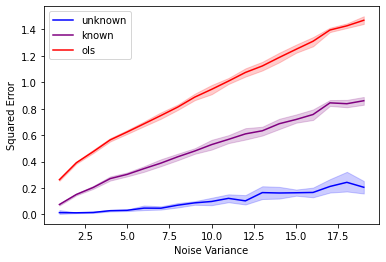

In [13]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [21]:
store.close()

In [ ]:
print("hi")

In [9]:
store.close()